# Real Hardware Fitting

In [2]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_maps import *
from quantum_tools import *
from experiments import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Two Qubit POVM

In [55]:
n = 2
d = 2**n

input_map_list, counts_map_list, counts_rep_list, counts_corr_list = pickle.load(open("../../data/twoQubits_pauliStrings_corrMat_mock.p", "rb"))

targets_map = counts_to_probs(counts_map_list)
corr_matrix = sum([generate_corruption_matrix(counts_corr_list[i*d: (i+1)*d]) for i in range(d)])/d

In [56]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_model = SPAM(
                  d=d,
                  init = init_ideal(n),
                  povm = corr_mat_to_povm(corr_matrix),
                  )

In [57]:
rank = d**2

circuit_target = variational_circuit(n).reverse_bits()
U = Operator(circuit_target).data

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_model = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       spam = spam_model,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

In [58]:
model.train(inputs = input_map_list,
            targets = targets_map,
            inputs_val = input_map_list,
            targets_val = targets_map,
            num_iter = 1000,
            N = 324
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.52552, val: 0.52552
Step:1, train: 0.51973, val: 0.51973
Step:2, train: 0.51395, val: 0.51395
Step:3, train: 0.50816, val: 0.50816
Step:4, train: 0.50238, val: 0.50238
Step:5, train: 0.49659, val: 0.49659
Step:6, train: 0.49082, val: 0.49082
Step:7, train: 0.48504, val: 0.48504
Step:8, train: 0.47926, val: 0.47926
Step:9, train: 0.47348, val: 0.47348
Step:10, train: 0.46770, val: 0.46770
Step:11, train: 0.46191, val: 0.46191
Step:12, train: 0.45612, val: 0.45612
Step:13, train: 0.45033, val: 0.45033
Step:14, train: 0.44452, val: 0.44452
Step:15, train: 0.43872, val: 0.43872
Step:16, train: 0.43291, val: 0.43291
Step:17, train: 0.42710, val: 0.42710
Step:18, train: 0.42128, val: 0.42128
Step:19, train: 0.41545, val: 0.41545
Step:20, train: 0.40960, val: 0.40960
Step:21, train: 0.40373, val: 0.40373
Step:22, train: 0.39786, val: 0.39786
Step:23, train: 0.39198, val: 0.39198
Step:24, train: 0.38609, val: 0.38609
Step:25, train: 0.38019, val: 0.38019
Step:26, train: 0.3742

Step:213, train: 0.00284, val: 0.00284
Step:214, train: 0.00279, val: 0.00279
Step:215, train: 0.00274, val: 0.00274
Step:216, train: 0.00269, val: 0.00269
Step:217, train: 0.00265, val: 0.00265
Step:218, train: 0.00260, val: 0.00260
Step:219, train: 0.00255, val: 0.00255
Step:220, train: 0.00251, val: 0.00251
Step:221, train: 0.00247, val: 0.00247
Step:222, train: 0.00242, val: 0.00242
Step:223, train: 0.00238, val: 0.00238
Step:224, train: 0.00234, val: 0.00234
Step:225, train: 0.00230, val: 0.00230
Step:226, train: 0.00226, val: 0.00226
Step:227, train: 0.00223, val: 0.00223
Step:228, train: 0.00219, val: 0.00219
Step:229, train: 0.00215, val: 0.00215
Step:230, train: 0.00212, val: 0.00212
Step:231, train: 0.00208, val: 0.00208
Step:232, train: 0.00205, val: 0.00205
Step:233, train: 0.00201, val: 0.00201
Step:234, train: 0.00198, val: 0.00198
Step:235, train: 0.00195, val: 0.00195
Step:236, train: 0.00192, val: 0.00192
Step:237, train: 0.00189, val: 0.00189
Step:238, train: 0.00186,

Step:425, train: 0.00030, val: 0.00030
Step:426, train: 0.00030, val: 0.00030
Step:427, train: 0.00029, val: 0.00029
Step:428, train: 0.00029, val: 0.00029
Step:429, train: 0.00029, val: 0.00029
Step:430, train: 0.00029, val: 0.00029
Step:431, train: 0.00029, val: 0.00029
Step:432, train: 0.00029, val: 0.00029
Step:433, train: 0.00029, val: 0.00029
Step:434, train: 0.00028, val: 0.00028
Step:435, train: 0.00028, val: 0.00028
Step:436, train: 0.00028, val: 0.00028
Step:437, train: 0.00028, val: 0.00028
Step:438, train: 0.00028, val: 0.00028
Step:439, train: 0.00028, val: 0.00028
Step:440, train: 0.00028, val: 0.00028
Step:441, train: 0.00028, val: 0.00028
Step:442, train: 0.00028, val: 0.00028
Step:443, train: 0.00027, val: 0.00027
Step:444, train: 0.00027, val: 0.00027
Step:445, train: 0.00027, val: 0.00027
Step:446, train: 0.00027, val: 0.00027
Step:447, train: 0.00027, val: 0.00027
Step:448, train: 0.00027, val: 0.00027
Step:449, train: 0.00027, val: 0.00027
Step:450, train: 0.00027,

Step:636, train: 0.00018, val: 0.00018
Step:637, train: 0.00018, val: 0.00018
Step:638, train: 0.00018, val: 0.00018
Step:639, train: 0.00018, val: 0.00018
Step:640, train: 0.00018, val: 0.00018
Step:641, train: 0.00018, val: 0.00018
Step:642, train: 0.00018, val: 0.00018
Step:643, train: 0.00018, val: 0.00018
Step:644, train: 0.00018, val: 0.00018
Step:645, train: 0.00018, val: 0.00018
Step:646, train: 0.00018, val: 0.00018
Step:647, train: 0.00018, val: 0.00018
Step:648, train: 0.00018, val: 0.00018
Step:649, train: 0.00018, val: 0.00018
Step:650, train: 0.00018, val: 0.00018
Step:651, train: 0.00018, val: 0.00018
Step:652, train: 0.00018, val: 0.00018
Step:653, train: 0.00018, val: 0.00018
Step:654, train: 0.00018, val: 0.00018
Step:655, train: 0.00018, val: 0.00018
Step:656, train: 0.00018, val: 0.00018
Step:657, train: 0.00018, val: 0.00018
Step:658, train: 0.00018, val: 0.00018
Step:659, train: 0.00018, val: 0.00018
Step:660, train: 0.00018, val: 0.00018
Step:661, train: 0.00018,

Step:847, train: 0.00015, val: 0.00015
Step:848, train: 0.00015, val: 0.00015
Step:849, train: 0.00015, val: 0.00015
Step:850, train: 0.00015, val: 0.00015
Step:851, train: 0.00015, val: 0.00015
Step:852, train: 0.00015, val: 0.00015
Step:853, train: 0.00015, val: 0.00015
Step:854, train: 0.00015, val: 0.00015
Step:855, train: 0.00015, val: 0.00015
Step:856, train: 0.00015, val: 0.00015
Step:857, train: 0.00015, val: 0.00015
Step:858, train: 0.00015, val: 0.00015
Step:859, train: 0.00015, val: 0.00015
Step:860, train: 0.00015, val: 0.00015
Step:861, train: 0.00015, val: 0.00015
Step:862, train: 0.00015, val: 0.00015
Step:863, train: 0.00015, val: 0.00015
Step:864, train: 0.00015, val: 0.00015
Step:865, train: 0.00015, val: 0.00015
Step:866, train: 0.00015, val: 0.00015
Step:867, train: 0.00015, val: 0.00015
Step:868, train: 0.00015, val: 0.00015
Step:869, train: 0.00015, val: 0.00015
Step:870, train: 0.00015, val: 0.00015
Step:871, train: 0.00015, val: 0.00015
Step:872, train: 0.00015,

In [59]:
state_unitary = state_model = tf.expand_dims(model.q_map.spam.init, axis=0)

observ = np.zeros((1, d))
observ[0, 0] = 1
observ = tf.cast(observ, dtype=tf.complex128)
model_expectation_list = []
unitary_expectation_list = []

probs = counts_to_probs(counts_rep_list)
                        
target_test = expectation_value(probs, observ).numpy()

for i in range(20):
    state_model = model.q_map.apply_map(state_model)
    probs = measurement(state_model, povm=model.q_map.spam.povm)
    model_expectation_list.append(expectation_value(probs, observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(measurement(state_unitary, povm=model.q_map.spam.povm), observ))

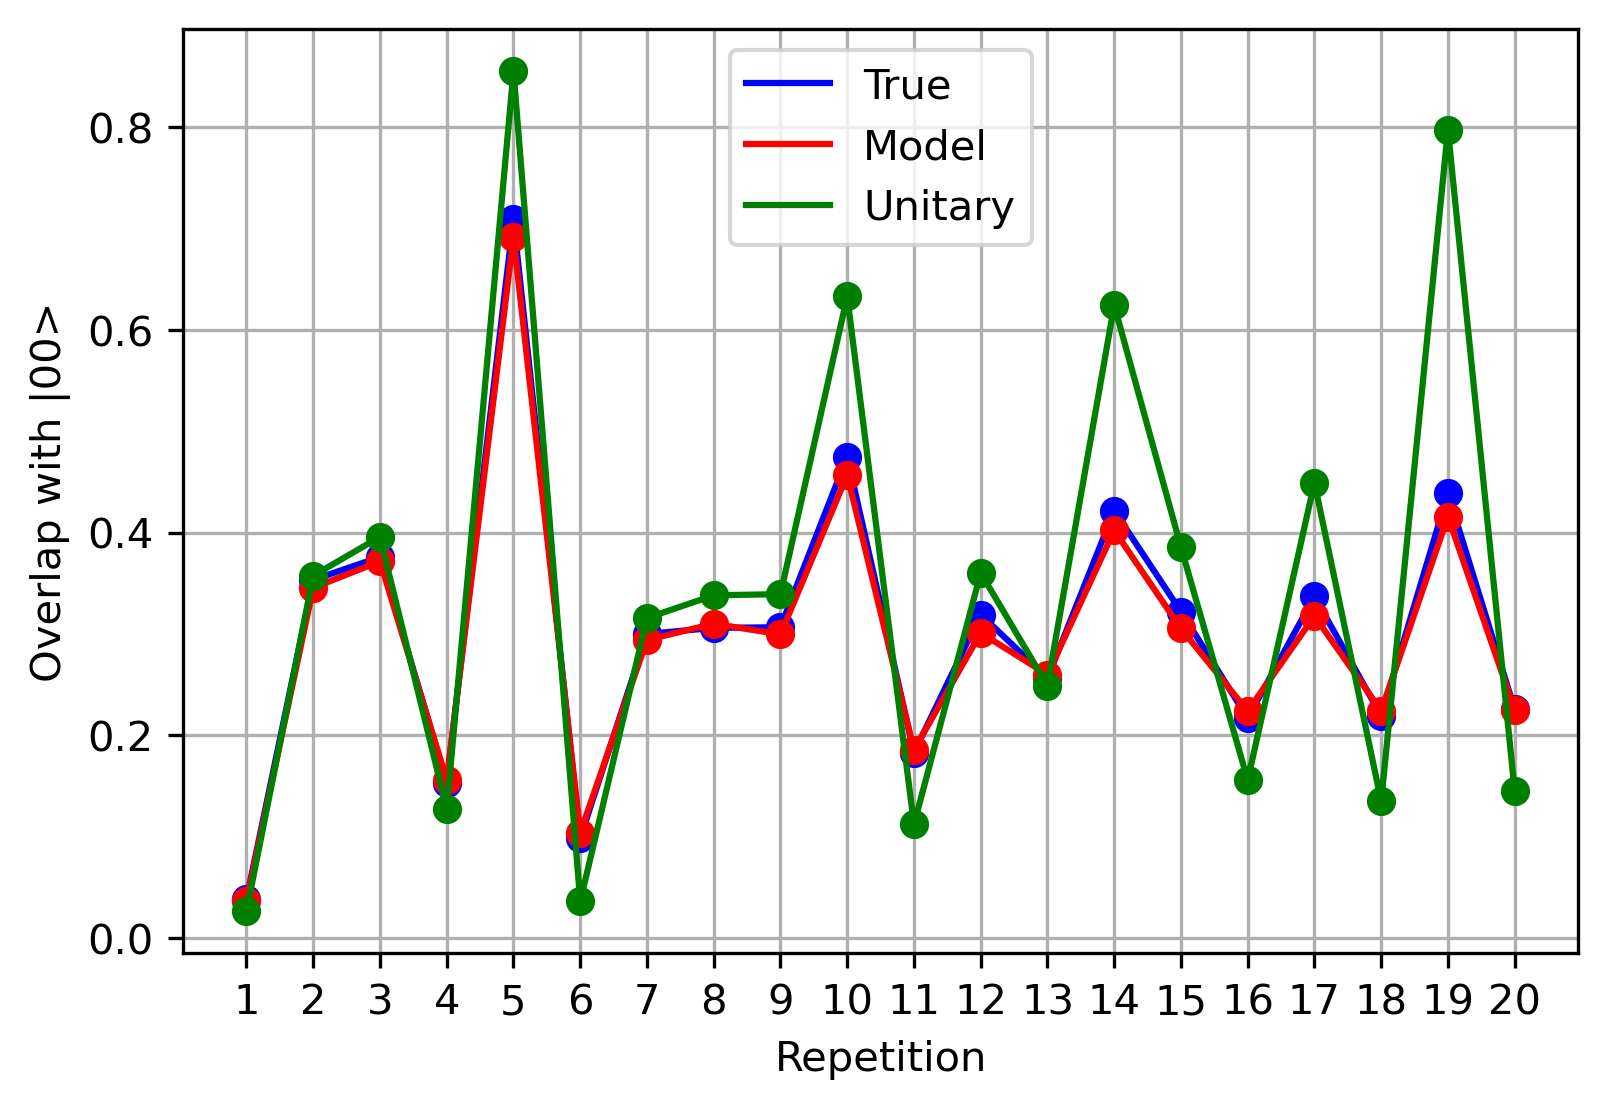

In [60]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")

plt.xticks(list(range(1,21)))
plt.legend()
plt.grid()
plt.show()

      ┌────────────┐ ┌───┐┌─────────────┐     
q_0: ─┤ Ry(2.8319) ├─┤ X ├┤ Rx(0.61989) ├──■──
     ┌┴────────────┴┐└─┬─┘└┬────────────┤┌─┴─┐
q_1: ┤ Ry(-0.78829) ├──■───┤ Rx(1.4577) ├┤ X ├
     └──────────────┘      └────────────┘└───┘


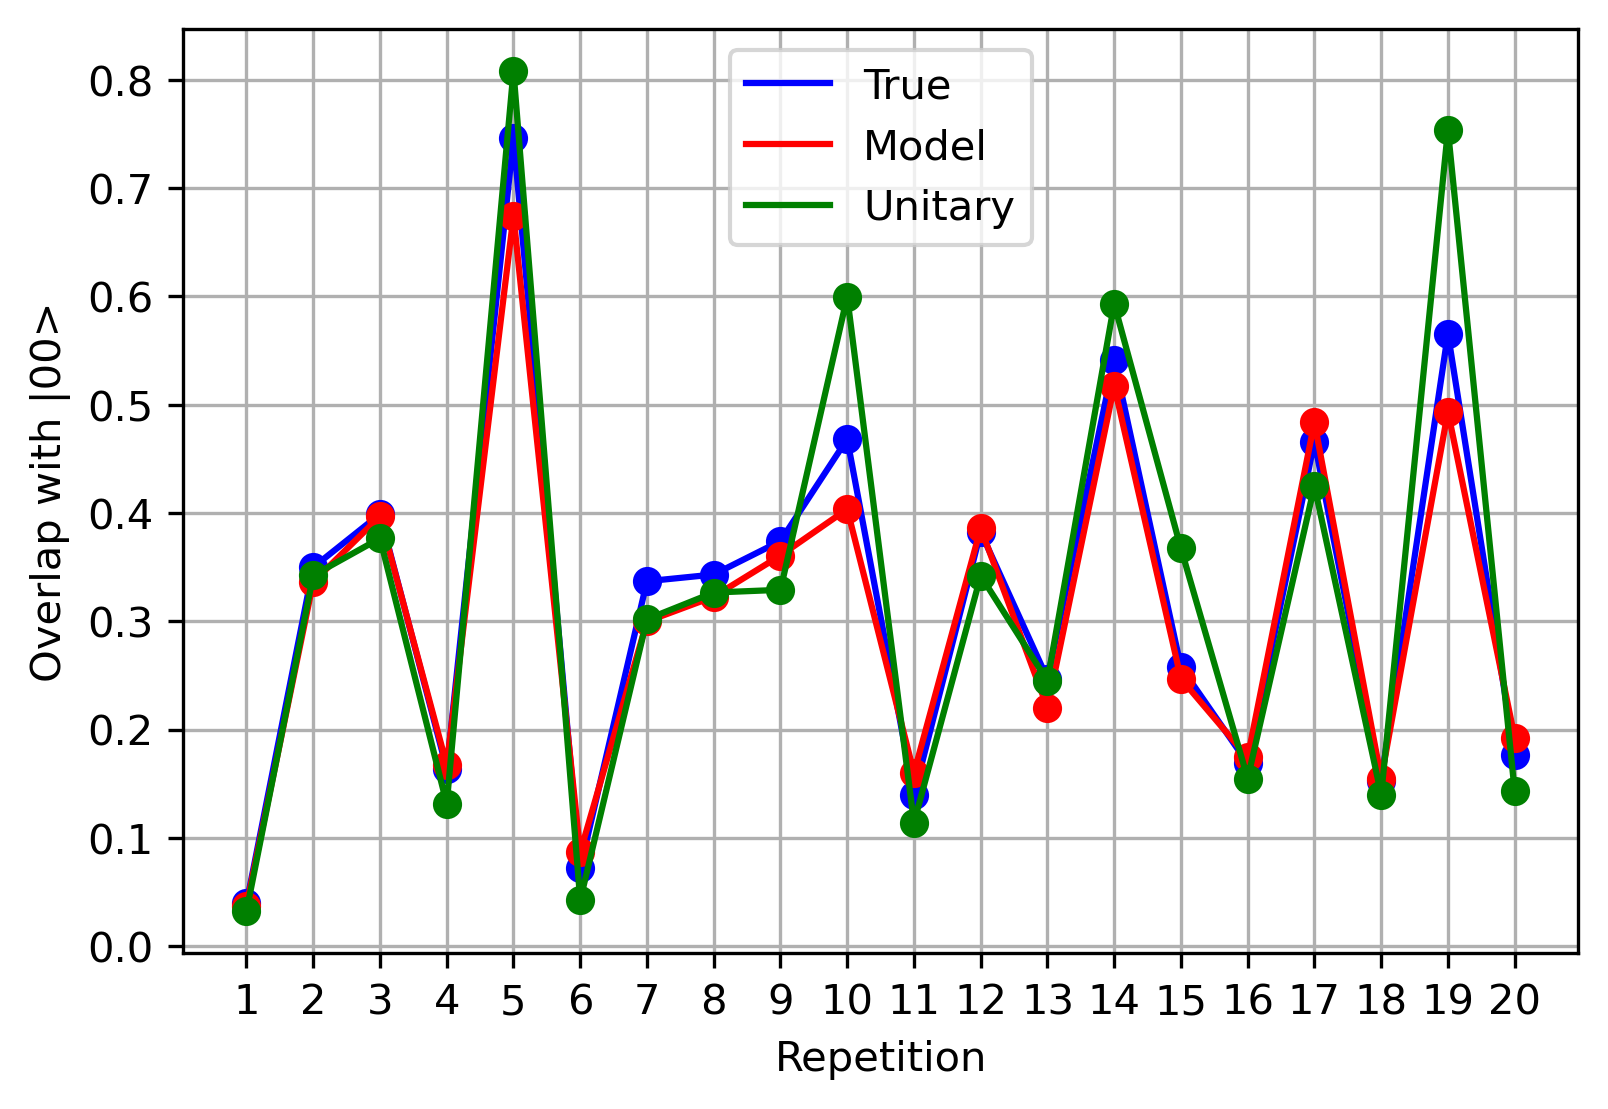

In [32]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")

plt.xticks(list(range(1,21)))
plt.legend()
plt.grid()
plt.show()

## Three Qubits 

In [74]:
n = 3
d = 2**n

input_map_list, counts_map_list, counts_rep_list, counts_corr_list = pickle.load(open("../../data/threeQubits_pauliStrings_corrMat.p", "rb"))

targets_map = counts_to_probs(counts_map_list)
corr_matrix = sum([generate_corruption_matrix(counts_corr_list[i*d: (i+1)*d]) for i in range(d)])/d

IndexError: list index out of range

In [75]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_model = SPAM(
                  d=d,
                  init = init_ideal(n),
                  povm = corr_mat_to_povm(corr_matrix),
                  )

In [69]:
rank = d**2

circuit_target = variational_circuit(n).reverse_bits()
U = Operator(circuit_target).data

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_model = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       spam = spam_model,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

In [70]:
model.train(inputs = input_map_list,
            targets = targets_map,
            inputs_val = None,
            targets_val = None,
            num_iter = 1000,
            N = 500
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.58796, val: 0.00000
Step:1, train: 0.58113, val: 0.00000
Step:2, train: 0.53410, val: 0.00000
Step:3, train: 0.56050, val: 0.00000
Step:4, train: 0.56358, val: 0.00000
Step:5, train: 0.57345, val: 0.00000
Step:6, train: 0.53418, val: 0.00000
Step:7, train: 0.54634, val: 0.00000
Step:8, train: 0.54215, val: 0.00000
Step:9, train: 0.54963, val: 0.00000
Step:10, train: 0.53685, val: 0.00000
Step:11, train: 0.52081, val: 0.00000
Step:12, train: 0.49562, val: 0.00000
Step:13, train: 0.52324, val: 0.00000
Step:14, train: 0.50869, val: 0.00000
Step:15, train: 0.49598, val: 0.00000
Step:16, train: 0.49777, val: 0.00000
Step:17, train: 0.47855, val: 0.00000
Step:18, train: 0.51016, val: 0.00000
Step:19, train: 0.47966, val: 0.00000
Step:20, train: 0.47472, val: 0.00000
Step:21, train: 0.45984, val: 0.00000
Step:22, train: 0.44820, val: 0.00000
Step:23, train: 0.45913, val: 0.00000
Step:24, train: 0.45724, val: 0.00000
Step:25, train: 0.46681, val: 0.00000
Step:26, train: 0.4494

Step:213, train: 0.00552, val: 0.00000
Step:214, train: 0.00517, val: 0.00000
Step:215, train: 0.00494, val: 0.00000
Step:216, train: 0.00502, val: 0.00000
Step:217, train: 0.00480, val: 0.00000
Step:218, train: 0.00461, val: 0.00000
Step:219, train: 0.00458, val: 0.00000
Step:220, train: 0.00460, val: 0.00000
Step:221, train: 0.00483, val: 0.00000
Step:222, train: 0.00438, val: 0.00000
Step:223, train: 0.00432, val: 0.00000
Step:224, train: 0.00417, val: 0.00000
Step:225, train: 0.00426, val: 0.00000
Step:226, train: 0.00400, val: 0.00000
Step:227, train: 0.00406, val: 0.00000
Step:228, train: 0.00389, val: 0.00000
Step:229, train: 0.00388, val: 0.00000
Step:230, train: 0.00380, val: 0.00000
Step:231, train: 0.00383, val: 0.00000
Step:232, train: 0.00382, val: 0.00000
Step:233, train: 0.00360, val: 0.00000
Step:234, train: 0.00355, val: 0.00000
Step:235, train: 0.00355, val: 0.00000
Step:236, train: 0.00348, val: 0.00000
Step:237, train: 0.00340, val: 0.00000
Step:238, train: 0.00336,

Step:424, train: 0.00062, val: 0.00000
Step:425, train: 0.00065, val: 0.00000
Step:426, train: 0.00059, val: 0.00000
Step:427, train: 0.00061, val: 0.00000
Step:428, train: 0.00063, val: 0.00000
Step:429, train: 0.00061, val: 0.00000
Step:430, train: 0.00061, val: 0.00000
Step:431, train: 0.00061, val: 0.00000
Step:432, train: 0.00061, val: 0.00000
Step:433, train: 0.00061, val: 0.00000
Step:434, train: 0.00059, val: 0.00000
Step:435, train: 0.00060, val: 0.00000
Step:436, train: 0.00059, val: 0.00000
Step:437, train: 0.00060, val: 0.00000
Step:438, train: 0.00059, val: 0.00000
Step:439, train: 0.00058, val: 0.00000
Step:440, train: 0.00057, val: 0.00000
Step:441, train: 0.00059, val: 0.00000
Step:442, train: 0.00058, val: 0.00000
Step:443, train: 0.00060, val: 0.00000
Step:444, train: 0.00058, val: 0.00000
Step:445, train: 0.00059, val: 0.00000
Step:446, train: 0.00057, val: 0.00000
Step:447, train: 0.00059, val: 0.00000
Step:448, train: 0.00060, val: 0.00000
Step:449, train: 0.00056,

Step:635, train: 0.00042, val: 0.00000
Step:636, train: 0.00044, val: 0.00000
Step:637, train: 0.00043, val: 0.00000
Step:638, train: 0.00044, val: 0.00000
Step:639, train: 0.00043, val: 0.00000
Step:640, train: 0.00043, val: 0.00000
Step:641, train: 0.00043, val: 0.00000
Step:642, train: 0.00044, val: 0.00000
Step:643, train: 0.00044, val: 0.00000
Step:644, train: 0.00043, val: 0.00000
Step:645, train: 0.00043, val: 0.00000
Step:646, train: 0.00042, val: 0.00000
Step:647, train: 0.00042, val: 0.00000
Step:648, train: 0.00044, val: 0.00000
Step:649, train: 0.00043, val: 0.00000
Step:650, train: 0.00042, val: 0.00000
Step:651, train: 0.00043, val: 0.00000
Step:652, train: 0.00043, val: 0.00000
Step:653, train: 0.00041, val: 0.00000
Step:654, train: 0.00043, val: 0.00000
Step:655, train: 0.00043, val: 0.00000
Step:656, train: 0.00043, val: 0.00000
Step:657, train: 0.00043, val: 0.00000
Step:658, train: 0.00043, val: 0.00000
Step:659, train: 0.00043, val: 0.00000
Step:660, train: 0.00042,

Step:846, train: 0.00035, val: 0.00000
Step:847, train: 0.00036, val: 0.00000
Step:848, train: 0.00036, val: 0.00000
Step:849, train: 0.00037, val: 0.00000
Step:850, train: 0.00037, val: 0.00000
Step:851, train: 0.00035, val: 0.00000
Step:852, train: 0.00036, val: 0.00000
Step:853, train: 0.00037, val: 0.00000
Step:854, train: 0.00035, val: 0.00000
Step:855, train: 0.00037, val: 0.00000
Step:856, train: 0.00036, val: 0.00000
Step:857, train: 0.00036, val: 0.00000
Step:858, train: 0.00036, val: 0.00000
Step:859, train: 0.00037, val: 0.00000
Step:860, train: 0.00038, val: 0.00000
Step:861, train: 0.00038, val: 0.00000
Step:862, train: 0.00035, val: 0.00000
Step:863, train: 0.00037, val: 0.00000
Step:864, train: 0.00035, val: 0.00000
Step:865, train: 0.00037, val: 0.00000
Step:866, train: 0.00036, val: 0.00000
Step:867, train: 0.00036, val: 0.00000
Step:868, train: 0.00037, val: 0.00000
Step:869, train: 0.00037, val: 0.00000
Step:870, train: 0.00036, val: 0.00000
Step:871, train: 0.00035,

In [65]:
state_unitary = state_model = tf.expand_dims(model.q_map.spam.init, axis=0)

observ = np.zeros((1, d))
observ[0, 0] = 1
observ = tf.cast(observ, dtype=tf.complex128)
model_expectation_list = []
unitary_expectation_list = []

probs = counts_to_probs(counts_rep_list)
                        
target_test = expectation_value(probs, observ).numpy()

for i in range(20):
    state_model = model.q_map.apply_map(state_model)
    probs = measurement(state_model, povm=model.q_map.spam.povm)
    model_expectation_list.append(expectation_value(probs, observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(measurement(state_unitary, povm=model.q_map.spam.povm), observ))

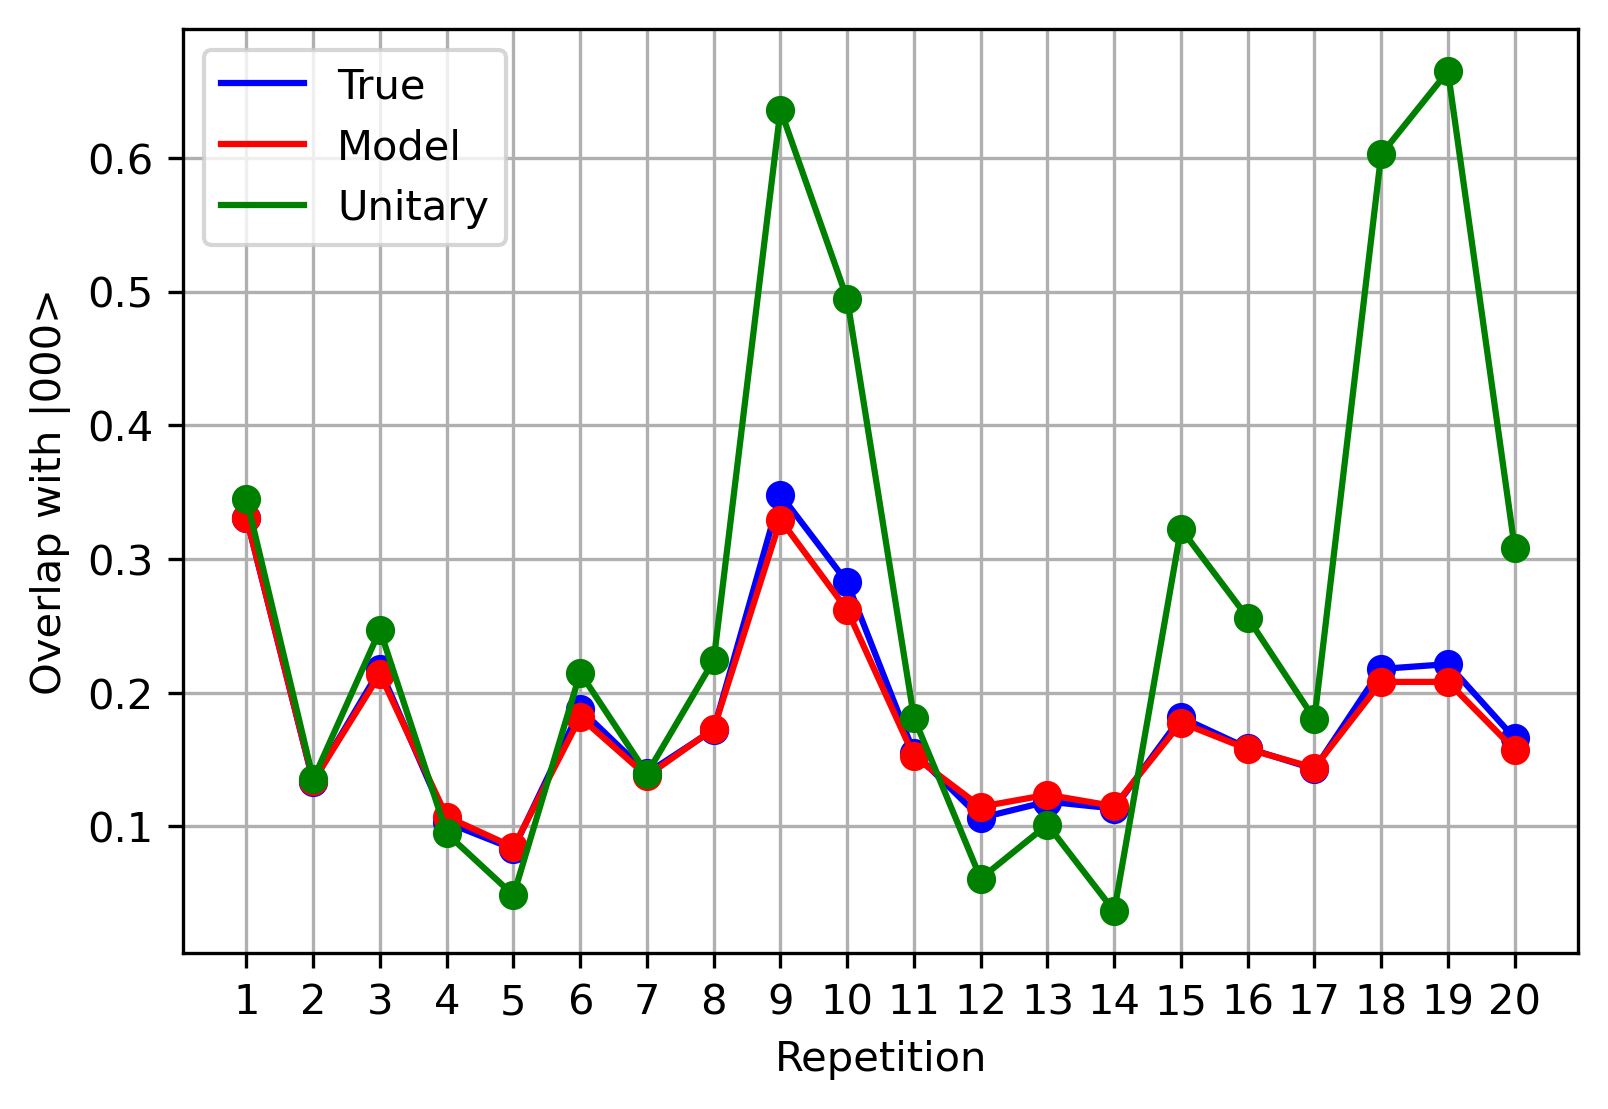

In [66]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |000>")

plt.xticks(list(range(1,21)))
plt.legend()
plt.grid()
plt.show()

      ┌────────────┐           ┌───┐     ┌─────────────┐          
q_0: ─┤ Ry(1.4577) ├───────────┤ X ├─────┤ Rx(-2.1615) ├──■───────
      ├────────────┤ ┌───┐     └─┬─┘     ├─────────────┤┌─┴─┐     
q_1: ─┤ Ry(2.8319) ├─┤ X ├───────■───────┤ Rx(-2.1613) ├┤ X ├──■──
     ┌┴────────────┴┐└─┬─┘┌─────────────┐└─────────────┘└───┘┌─┴─┐
q_2: ┤ Ry(-0.78829) ├──■──┤ Rx(0.61989) ├────────────────────┤ X ├
     └──────────────┘     └─────────────┘                    └───┘


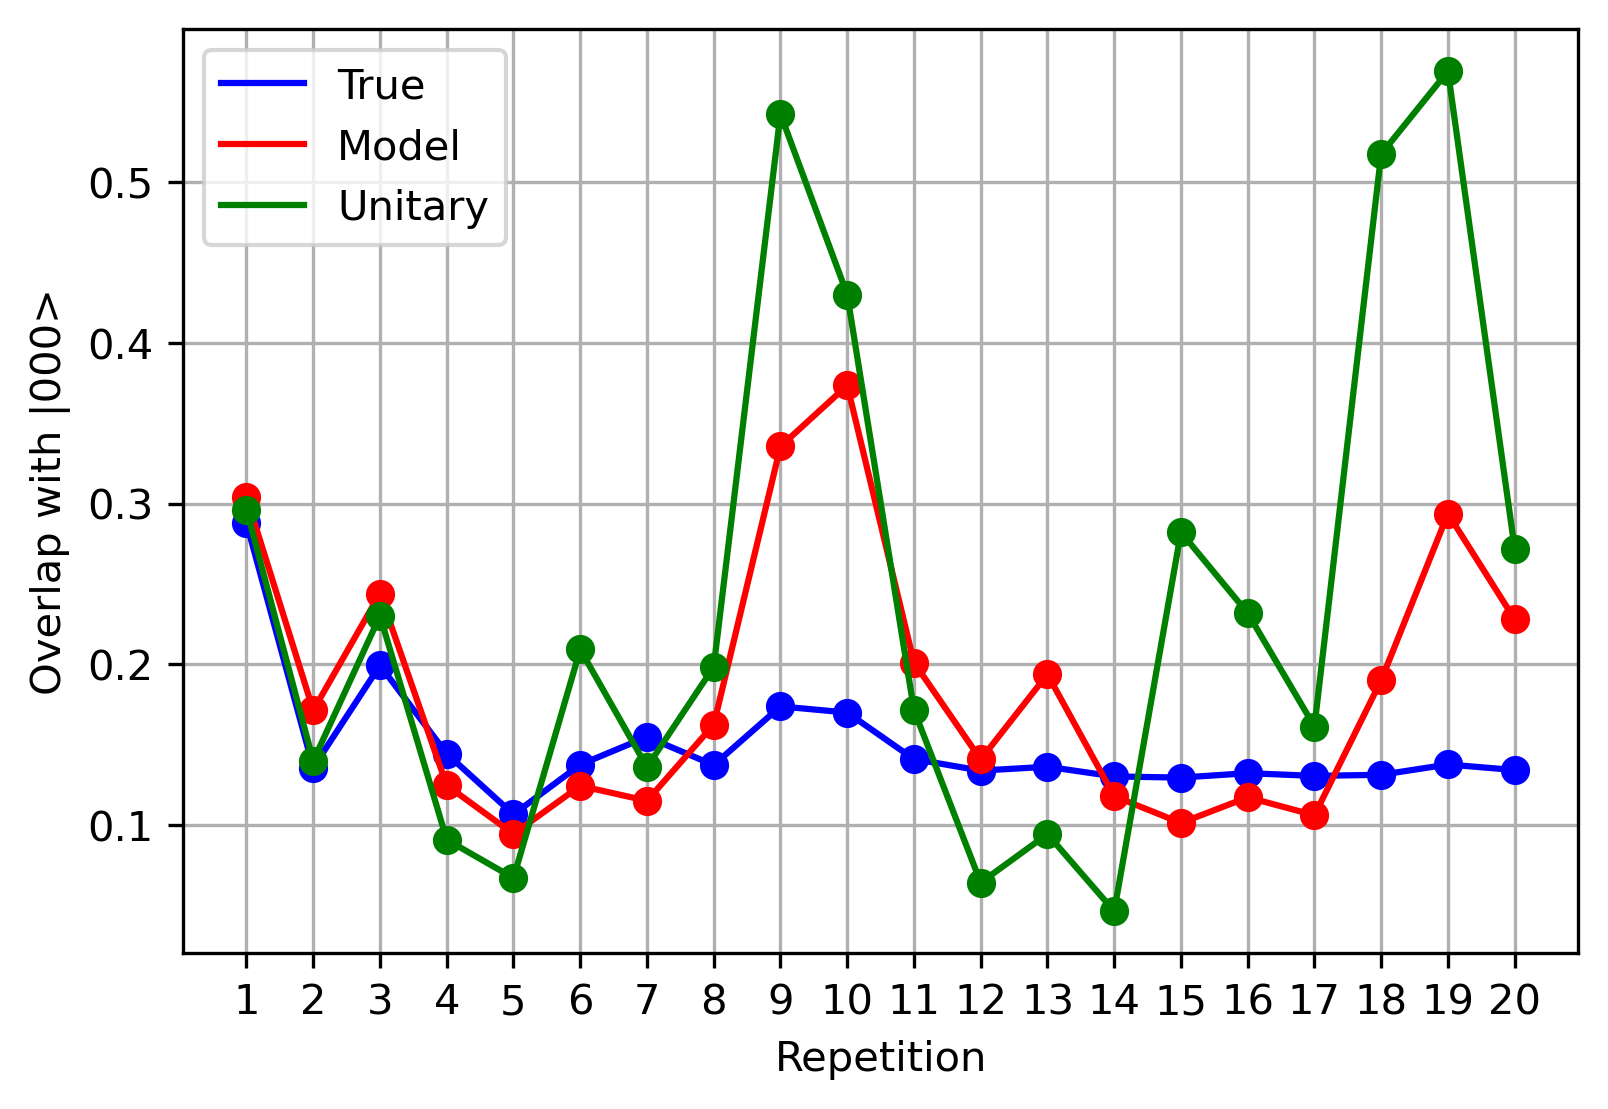

In [54]:
print(circuit_target)

fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |000>")

plt.xticks(list(range(1,21)))
plt.legend()
plt.grid()
plt.show()

In [8]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 2
d = 2**n

spam_model = SPAM(
                  d=d,
                  #init = init_ideal(n),
                  #povm = corr_mat_to_povm(corr_matrix),
                  )

In [9]:
spam_model.pretrain(num_iter = 1000, targets = [init_ideal(n), povm_ideal(n)])

  0%|          | 0/1000 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'apply_gradients'

## Three Qubit QFT

In [3]:
def qft(n):
    circuit = qk.QuantumCircuit(n)
    for i in range(n):
        circuit.h(i)
        for j in range(i+1, n):
            circuit.cp(2*np.pi/2**(j-i+1), j, i)
            
    return circuit

In [110]:
n = 3
d = 2**n

U = circuit_to_matrix(qft(n))

inputs_map, inputs_spam, counts_map_list =  pickle.load(open("../../data/threeQubits_QFT_3.p", "rb"))
targets_map = counts_to_probs(counts_map_list[:1500-6**n])
targets_spam = counts_to_probs(counts_map_list[1500-6**n:])

In [111]:
spam_model = SPAM(d=d,
                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                    num_iter = 1000,
                    verbose = False,
                    )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 3000,
                )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0 0.012380495178093448
1 0.006293593211400705
2 0.0034259203979510756
3 0.0032531266470181997
4 0.003639699255121545
5 0.0038669432655029285
6 0.0038752115096014486
7 0.0035972631699232364
8 0.003043767855252522
9 0.0024360562908672073
10 0.002023304468030295
11 0.0018188622753286879
12 0.0017097963181748588
13 0.0016526048049436846
14 0.0016145048679308337
15 0.0015826155368148054
16 0.001541283727524898
17 0.0014701851767482269
18 0.0014062773617166961
19 0.001372849609786893
20 0.0013632420187425658
21 0.00134625437218703
22 0.0013235097078084252
23 0.0012934644104899125
24 0.0012493782236605302
25 0.0011982272146200269
26 0.0011455784782521273
27 0.001105832161199075
28 0.001077651614746957
29 0.0010655703903258607
30 0.0010563552524120881
31 0.0010529579249513323
32 0.0010464128892672426
33 0.0010269572682166286
34 0.0009993823473513812
35 0.000974990270133329
36 0.0009500852730187495
37 0.0009309389122331191
38 0.0009242965516417332
39 0.0009216234942806243
40 0.00092092732775729

321 0.00046211179070229305
322 0.00046195297749791693
323 0.0004616063269626697
324 0.0004612155948016909
325 0.00046137099730974635
326 0.00046154084739636535
327 0.00046172637689390793
328 0.0004612103419734294
329 0.0004610379219779253
330 0.000460592598438572
331 0.0004611721004669811
332 0.0004614335715706388
333 0.00046090422006426514
334 0.0004609304779061888
335 0.0004608793932185468
336 0.0004608677715936693
337 0.00046036900641352024
338 0.00046068766889533115
339 0.00046079204209330444
340 0.0004608597939246673
341 0.0004604558559850846
342 0.00046029095301119917
343 0.00046039970597392543
344 0.00046026703091621007
345 0.00046000460606697495
346 0.00045969934717850816
347 0.0004596659734674817
348 0.0004597565667875394
349 0.00045966380502434804
350 0.00045947458966163004
351 0.0004592984005979316
352 0.00045924473229518904
353 0.0004591556550051607
354 0.00045941996668517
355 0.00045956214192572275
356 0.00045929540470428617
357 0.00045939888897548526
358 0.000459240113653

633 0.0004574414268023386
634 0.00045732790190297846
635 0.0004572297710434735
636 0.00045744562586441976
637 0.0004571924104263892
638 0.0004570987711508325
639 0.00045786416417694514
640 0.0004575802267908481
641 0.0004574958513704729
642 0.0004579948456523352
643 0.0004575839907688291
644 0.0004575701107236992
645 0.000457782581710142
646 0.00045736432290011206
647 0.0004574766587241172
648 0.0004576473643635242
649 0.0004571333851408436
650 0.0004571079006586168
651 0.0004577586689579385
652 0.0004572250636966591
653 0.00045786227647736153
654 0.00045794384330788906
655 0.00045747870317646263
656 0.0004580726872432599
657 0.0004583733610272102
658 0.0004575736621845147
659 0.0004578118729374294
660 0.00045822903656414054
661 0.0004578704137399999
662 0.00045775682566468053
663 0.00045870189762074374
664 0.0004588836426056331
665 0.00045788939992715764
666 0.0004582916643023261
667 0.00045874134996684373
668 0.00045816732841350575
669 0.00045784813202229176
670 0.0004583806034075019

950 0.0004604269529306248
951 0.0004599003095807611
952 0.0004596895190262051
953 0.00046038492738068596
954 0.000459959239963715
955 0.0004605925122315196
956 0.0004608916286921705
957 0.0004605201974872293
958 0.00046028592315720026
959 0.0004606330947957716
960 0.0004604758144627947
961 0.00046088591425799035
962 0.00046042120525788114
963 0.0004614418635408208
964 0.00046082082826077883
965 0.00046122361684250126
966 0.0004619857358042632
967 0.00046121983828085816
968 0.0004616755992793689
969 0.00046200002348345873
970 0.0004620258577682613
971 0.0004618616889271215
972 0.0004615599674961665
973 0.00046236779186258607
974 0.00046208339684455907
975 0.0004619379561298886
976 0.0004633785495245493
977 0.0004631978696852214
978 0.00046292567694990606
979 0.00046391394536678885
980 0.00046373169845441756
981 0.0004634128512847679
982 0.0004647476160604281
983 0.00046491569184557415
984 0.0004640642342529325
985 0.00046489713352173786
986 0.00046494636298865784
987 0.00046511527038779

1261 0.0016712374602487188
1262 0.0016740838574549836
1263 0.0016685442298797187
1264 0.001655830035905727
1265 0.0016379415705184493
1266 0.0016178718499973866
1267 0.0015970250853610507
1268 0.0015780393924205152
1269 0.001561097156271967
1270 0.0015470765820108465
1271 0.001536698849761884
1272 0.0015304073879261891
1273 0.0015263771572070547
1274 0.0015269046458139775
1275 0.0015304426306208263
1276 0.001536708647243364
1277 0.001546210821122796
1278 0.0015546705020470606
1279 0.0015638225386269313
1280 0.0015706105125172915
1281 0.0015736786422590628
1282 0.0015714848988395535
1283 0.001563008414890922
1284 0.0015496623353940908
1285 0.0015317738209345139
1286 0.001511597852516333
1287 0.0014915157894832137
1288 0.0014722383315314534
1289 0.0014545070091717288
1290 0.0014393005397938313
1291 0.0014259400966951164
1292 0.0014157261410472622
1293 0.001408862793968842
1294 0.0014043340958495808
1295 0.0014024889045383356
1296 0.00140280626795768
1297 0.0014048877594803936
1298 0.0014

1571 0.0004947225404138115
1572 0.0004934613436073237
1573 0.0004935470781747773
1574 0.0004931773350180627
1575 0.0004932205159545656
1576 0.0004915611295483889
1577 0.0004920640051026011
1578 0.000491735919856615
1579 0.0004908357855572484
1580 0.000490777620142312
1581 0.0004905976558301275
1582 0.0004897670428813983
1583 0.0004902159735959271
1584 0.0004893010889254281
1585 0.0004889471966241894
1586 0.0004891414395237864
1587 0.0004882187150501714
1588 0.0004886700133569329
1589 0.0004881323479865658
1590 0.00048785316390114874
1591 0.00048783026819871776
1592 0.0004874125323776839
1593 0.0004867305322113578
1594 0.00048657482958620234
1595 0.00048690292176589006
1596 0.00048548034994632804
1597 0.0004857452284401119
1598 0.00048551750749494335
1599 0.00048547138474193196
1600 0.0004848411596717397
1601 0.0004847507495570632
1602 0.0004852962848431249
1603 0.00048499099990244473
1604 0.0004837704204458873
1605 0.00048466960935031377
1606 0.00048394550692303404
1607 0.0004832672447

1875 0.00046540436817744897
1876 0.00046596909186131385
1877 0.0004648549338057732
1878 0.00046638724566738625
1879 0.00046846259232594556
1880 0.00046778166044084314
1881 0.0004671979269775404
1882 0.00046766212276538166
1883 0.0004656195615428689
1884 0.0004657025107093384
1885 0.0004682479402512963
1886 0.00046637304693039063
1887 0.00046542821880300224
1888 0.00046585025782679417
1889 0.0004659863910887447
1890 0.0004660037816322988
1891 0.00046700338411999147
1892 0.00046518516626939616
1893 0.000465431314417312
1894 0.000465712244579745
1895 0.0004646882513669713
1896 0.0004646105481400708
1897 0.0004645294934942106
1898 0.0004641285111803839
1899 0.0004655081417197409
1900 0.0004653539795445171
1901 0.0004652149857142248
1902 0.00046507843157121795
1903 0.0004648341390744306
1904 0.00046394710224986296
1905 0.00046421690093619017
1906 0.00046432833865184394
1907 0.0004647367428809454
1908 0.0004643960204358963
1909 0.00046424011478249464
1910 0.0004652904060118821
1911 0.0004655

2181 0.0004671046775679478
2182 0.00046653783368226276
2183 0.0004679907485388165
2184 0.0004678311860327145
2185 0.00046637188041079666
2186 0.00046713662922082626
2187 0.00046609737319459194
2188 0.00046704749298431527
2189 0.0004670951306390678
2190 0.00046613670981990795
2191 0.0004665537331711349
2192 0.0004670269791539774
2193 0.000466058272411819
2194 0.0004656112702530368
2195 0.000466296069822727
2196 0.000465717408362856
2197 0.0004662362140248443
2198 0.0004661344141339391
2199 0.00046608592198246036
2200 0.00046611095365623297
2201 0.00046561571183891855
2202 0.0004648744180478875
2203 0.00046758700070940936
2204 0.0004673434731586593
2205 0.00046750125935690406
2206 0.00046898517108027164
2207 0.00046769542249855346
2208 0.0004668883064689827
2209 0.00046762646201580366
2210 0.0004684965274252315
2211 0.00046656657741779296
2212 0.00046726167188096597
2213 0.0004690181966553994
2214 0.0004673226718996848
2215 0.00046658910582395794
2216 0.00046884484067730115
2217 0.000467

2485 0.0005145620830626051
2486 0.0005142004343020524
2487 0.0005137936574872747
2488 0.000515083280762674
2489 0.0005152947863746583
2490 0.0005172773878641352
2491 0.000517607230562014
2492 0.000516807793758085
2493 0.0005202632520638059
2494 0.0005212356492143897
2495 0.0005191167624602848
2496 0.0005228471434164776
2497 0.0005243021659167387
2498 0.0005227329288050497
2499 0.0005248787945855853
2500 0.0005257009764978531
2501 0.0005255614861513607
2502 0.0005252262172271262
2503 0.0005276118109386278
2504 0.0005260544144738539
2505 0.0005280481191746935
2506 0.0005292688627435497
2507 0.0005280620944836334
2508 0.0005285567854077111
2509 0.0005301084476080989
2510 0.000531196761787935
2511 0.0005322259095346507
2512 0.0005329397120507462
2513 0.0005338936034616868
2514 0.0005346427819117121
2515 0.0005359652464047873
2516 0.0005365046140527191
2517 0.0005388560687054327
2518 0.0005385639918398725
2519 0.0005393258017685964
2520 0.0005396473036952668
2521 0.0005396576774502553
2522 

2795 0.0010171095059722198
2796 0.001021919429323121
2797 0.0010260974653524782
2798 0.0010339914124163185
2799 0.0010412713403400158
2800 0.0010482227149813728
2801 0.0010542868306237837
2802 0.0010558043009036343
2803 0.0010560132355754372
2804 0.0010520498603698194
2805 0.0010452562437468103
2806 0.001034691191335365
2807 0.0010240190679562894
2808 0.0010140795952406024
2809 0.0010044186477115556
2810 0.0009954198547595368
2811 0.0009896292998069272
2812 0.0009836157311587227
2813 0.0009807407936494863
2814 0.0009801349962317825
2815 0.0009805523348977887
2816 0.0009825525314259634
2817 0.0009859146652260046
2818 0.0009919902215764595
2819 0.0009969348412507367
2820 0.0010012400233473822
2821 0.0010063428979211373
2822 0.0010090281639007707
2823 0.0010077828033900821
2824 0.0010042695070938625
2825 0.0009984594779898948
2826 0.0009901211152346919
2827 0.0009818617910844812
2828 0.000972303872280841
2829 0.0009638266360865311
2830 0.0009541066172468631
2831 0.0009483549872262742
2832

In [79]:
#train kraus model
kraus_model_unitary = KrausMap(d = d, 
                               rank = 1,
                               spam = spam_model,
                              )

model = ModelQuantumMap(
                        q_map = kraus_model_unitary,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model.train(inputs = inputs_map,
            targets = targets_map,
            num_iter = 3000,
            N = 1000
            )

  0%|          | 0/3000 [00:00<?, ?it/s]

Step:0, train: 1.13386, val: 0.00000
Step:1, train: 1.13678, val: 0.00000
Step:2, train: 1.10410, val: 0.00000
Step:3, train: 1.10767, val: 0.00000
Step:4, train: 1.08066, val: 0.00000
Step:5, train: 1.08083, val: 0.00000
Step:6, train: 1.04635, val: 0.00000
Step:7, train: 1.05665, val: 0.00000
Step:8, train: 1.06304, val: 0.00000
Step:9, train: 1.05343, val: 0.00000
Step:10, train: 1.05402, val: 0.00000
Step:11, train: 1.03670, val: 0.00000
Step:12, train: 1.03211, val: 0.00000
Step:13, train: 1.02247, val: 0.00000
Step:14, train: 0.99569, val: 0.00000
Step:15, train: 1.01563, val: 0.00000
Step:16, train: 1.00107, val: 0.00000
Step:17, train: 1.00452, val: 0.00000
Step:18, train: 0.99780, val: 0.00000
Step:19, train: 0.99107, val: 0.00000
Step:20, train: 0.98324, val: 0.00000
Step:21, train: 0.97520, val: 0.00000
Step:22, train: 0.96356, val: 0.00000
Step:23, train: 0.97334, val: 0.00000
Step:24, train: 0.95881, val: 0.00000
Step:25, train: 0.95806, val: 0.00000
Step:26, train: 0.9382

Step:217, train: 0.21467, val: 0.00000
Step:218, train: 0.21867, val: 0.00000
Step:219, train: 0.21498, val: 0.00000
Step:220, train: 0.21276, val: 0.00000
Step:221, train: 0.21088, val: 0.00000
Step:222, train: 0.20939, val: 0.00000
Step:223, train: 0.20470, val: 0.00000
Step:224, train: 0.20797, val: 0.00000
Step:225, train: 0.20395, val: 0.00000
Step:226, train: 0.19757, val: 0.00000
Step:227, train: 0.20137, val: 0.00000
Step:228, train: 0.20070, val: 0.00000
Step:229, train: 0.19293, val: 0.00000
Step:230, train: 0.19566, val: 0.00000
Step:231, train: 0.19488, val: 0.00000
Step:232, train: 0.19008, val: 0.00000
Step:233, train: 0.19359, val: 0.00000
Step:234, train: 0.19186, val: 0.00000
Step:235, train: 0.18819, val: 0.00000
Step:236, train: 0.18885, val: 0.00000
Step:237, train: 0.18086, val: 0.00000
Step:238, train: 0.18380, val: 0.00000
Step:239, train: 0.17984, val: 0.00000
Step:240, train: 0.18202, val: 0.00000
Step:241, train: 0.17965, val: 0.00000
Step:242, train: 0.17688,

Step:428, train: 0.08402, val: 0.00000
Step:429, train: 0.08165, val: 0.00000
Step:430, train: 0.08117, val: 0.00000
Step:431, train: 0.08302, val: 0.00000
Step:432, train: 0.08090, val: 0.00000
Step:433, train: 0.08307, val: 0.00000
Step:434, train: 0.08369, val: 0.00000
Step:435, train: 0.08157, val: 0.00000
Step:436, train: 0.08229, val: 0.00000
Step:437, train: 0.08376, val: 0.00000
Step:438, train: 0.08260, val: 0.00000
Step:439, train: 0.08255, val: 0.00000
Step:440, train: 0.08533, val: 0.00000
Step:441, train: 0.08169, val: 0.00000
Step:442, train: 0.08134, val: 0.00000
Step:443, train: 0.08157, val: 0.00000
Step:444, train: 0.08250, val: 0.00000
Step:445, train: 0.08492, val: 0.00000
Step:446, train: 0.08408, val: 0.00000
Step:447, train: 0.08343, val: 0.00000
Step:448, train: 0.08397, val: 0.00000
Step:449, train: 0.08394, val: 0.00000
Step:450, train: 0.08331, val: 0.00000
Step:451, train: 0.08283, val: 0.00000
Step:452, train: 0.08311, val: 0.00000
Step:453, train: 0.08582,

Step:640, train: 0.07307, val: 0.00000
Step:641, train: 0.07300, val: 0.00000
Step:642, train: 0.07114, val: 0.00000
Step:643, train: 0.07542, val: 0.00000
Step:644, train: 0.07326, val: 0.00000
Step:645, train: 0.07502, val: 0.00000
Step:646, train: 0.07457, val: 0.00000
Step:647, train: 0.07271, val: 0.00000
Step:648, train: 0.07432, val: 0.00000
Step:649, train: 0.07239, val: 0.00000
Step:650, train: 0.07310, val: 0.00000
Step:651, train: 0.07480, val: 0.00000
Step:652, train: 0.07335, val: 0.00000
Step:653, train: 0.07311, val: 0.00000
Step:654, train: 0.07262, val: 0.00000
Step:655, train: 0.07282, val: 0.00000
Step:656, train: 0.07515, val: 0.00000
Step:657, train: 0.07462, val: 0.00000
Step:658, train: 0.07420, val: 0.00000
Step:659, train: 0.07351, val: 0.00000
Step:660, train: 0.07391, val: 0.00000
Step:661, train: 0.07274, val: 0.00000
Step:662, train: 0.07381, val: 0.00000
Step:663, train: 0.07132, val: 0.00000
Step:664, train: 0.07119, val: 0.00000
Step:665, train: 0.07300,

Step:851, train: 0.07213, val: 0.00000
Step:852, train: 0.07256, val: 0.00000
Step:853, train: 0.07214, val: 0.00000
Step:854, train: 0.07347, val: 0.00000
Step:855, train: 0.07429, val: 0.00000
Step:856, train: 0.07229, val: 0.00000
Step:857, train: 0.07261, val: 0.00000
Step:858, train: 0.07299, val: 0.00000
Step:859, train: 0.07238, val: 0.00000
Step:860, train: 0.07092, val: 0.00000
Step:861, train: 0.07480, val: 0.00000
Step:862, train: 0.07135, val: 0.00000
Step:863, train: 0.07172, val: 0.00000
Step:864, train: 0.07185, val: 0.00000
Step:865, train: 0.06965, val: 0.00000
Step:866, train: 0.07447, val: 0.00000
Step:867, train: 0.07366, val: 0.00000
Step:868, train: 0.07266, val: 0.00000
Step:869, train: 0.07435, val: 0.00000
Step:870, train: 0.07417, val: 0.00000
Step:871, train: 0.07219, val: 0.00000
Step:872, train: 0.07336, val: 0.00000
Step:873, train: 0.07269, val: 0.00000
Step:874, train: 0.07403, val: 0.00000
Step:875, train: 0.07259, val: 0.00000
Step:876, train: 0.07212,

Step:1061, train: 0.07130, val: 0.00000
Step:1062, train: 0.07252, val: 0.00000
Step:1063, train: 0.07271, val: 0.00000
Step:1064, train: 0.07137, val: 0.00000
Step:1065, train: 0.07252, val: 0.00000
Step:1066, train: 0.07211, val: 0.00000
Step:1067, train: 0.07295, val: 0.00000
Step:1068, train: 0.07276, val: 0.00000
Step:1069, train: 0.07299, val: 0.00000
Step:1070, train: 0.07243, val: 0.00000
Step:1071, train: 0.07244, val: 0.00000
Step:1072, train: 0.07313, val: 0.00000
Step:1073, train: 0.07328, val: 0.00000
Step:1074, train: 0.07205, val: 0.00000
Step:1075, train: 0.07038, val: 0.00000
Step:1076, train: 0.07109, val: 0.00000
Step:1077, train: 0.07400, val: 0.00000
Step:1078, train: 0.07337, val: 0.00000
Step:1079, train: 0.07292, val: 0.00000
Step:1080, train: 0.07326, val: 0.00000
Step:1081, train: 0.07217, val: 0.00000
Step:1082, train: 0.07302, val: 0.00000
Step:1083, train: 0.07241, val: 0.00000
Step:1084, train: 0.07517, val: 0.00000
Step:1085, train: 0.07133, val: 0.00000


Step:1268, train: 0.07132, val: 0.00000
Step:1269, train: 0.07171, val: 0.00000
Step:1270, train: 0.07295, val: 0.00000
Step:1271, train: 0.07191, val: 0.00000
Step:1272, train: 0.07331, val: 0.00000
Step:1273, train: 0.07372, val: 0.00000
Step:1274, train: 0.07319, val: 0.00000
Step:1275, train: 0.07257, val: 0.00000
Step:1276, train: 0.07313, val: 0.00000
Step:1277, train: 0.07450, val: 0.00000
Step:1278, train: 0.07430, val: 0.00000
Step:1279, train: 0.07272, val: 0.00000
Step:1280, train: 0.07326, val: 0.00000
Step:1281, train: 0.07248, val: 0.00000
Step:1282, train: 0.07298, val: 0.00000
Step:1283, train: 0.07192, val: 0.00000
Step:1284, train: 0.07321, val: 0.00000
Step:1285, train: 0.07133, val: 0.00000
Step:1286, train: 0.07366, val: 0.00000
Step:1287, train: 0.07365, val: 0.00000
Step:1288, train: 0.07343, val: 0.00000
Step:1289, train: 0.07320, val: 0.00000
Step:1290, train: 0.07316, val: 0.00000
Step:1291, train: 0.07354, val: 0.00000
Step:1292, train: 0.07216, val: 0.00000


Step:1473, train: 0.07148, val: 0.00000
Step:1474, train: 0.07228, val: 0.00000
Step:1475, train: 0.07474, val: 0.00000
Step:1476, train: 0.07190, val: 0.00000
Step:1477, train: 0.07373, val: 0.00000
Step:1478, train: 0.07324, val: 0.00000
Step:1479, train: 0.07412, val: 0.00000
Step:1480, train: 0.07370, val: 0.00000
Step:1481, train: 0.07426, val: 0.00000
Step:1482, train: 0.07290, val: 0.00000
Step:1483, train: 0.07190, val: 0.00000
Step:1484, train: 0.07287, val: 0.00000
Step:1485, train: 0.07069, val: 0.00000
Step:1486, train: 0.07139, val: 0.00000
Step:1487, train: 0.07354, val: 0.00000
Step:1488, train: 0.07283, val: 0.00000
Step:1489, train: 0.07374, val: 0.00000
Step:1490, train: 0.07319, val: 0.00000
Step:1491, train: 0.07265, val: 0.00000
Step:1492, train: 0.07159, val: 0.00000
Step:1493, train: 0.07253, val: 0.00000
Step:1494, train: 0.07136, val: 0.00000
Step:1495, train: 0.07472, val: 0.00000
Step:1496, train: 0.07331, val: 0.00000
Step:1497, train: 0.07477, val: 0.00000


Step:1679, train: 0.07300, val: 0.00000
Step:1680, train: 0.07277, val: 0.00000
Step:1681, train: 0.07253, val: 0.00000
Step:1682, train: 0.06932, val: 0.00000
Step:1683, train: 0.07156, val: 0.00000
Step:1684, train: 0.07192, val: 0.00000
Step:1685, train: 0.07279, val: 0.00000
Step:1686, train: 0.07118, val: 0.00000
Step:1687, train: 0.07161, val: 0.00000
Step:1688, train: 0.07383, val: 0.00000
Step:1689, train: 0.07382, val: 0.00000
Step:1690, train: 0.07073, val: 0.00000
Step:1691, train: 0.07129, val: 0.00000
Step:1692, train: 0.07306, val: 0.00000
Step:1693, train: 0.07251, val: 0.00000
Step:1694, train: 0.07242, val: 0.00000
Step:1695, train: 0.06980, val: 0.00000
Step:1696, train: 0.07309, val: 0.00000
Step:1697, train: 0.07434, val: 0.00000
Step:1698, train: 0.07255, val: 0.00000
Step:1699, train: 0.07251, val: 0.00000
Step:1700, train: 0.07175, val: 0.00000
Step:1701, train: 0.07359, val: 0.00000
Step:1702, train: 0.07039, val: 0.00000
Step:1703, train: 0.07302, val: 0.00000


Step:1884, train: 0.07156, val: 0.00000
Step:1885, train: 0.07187, val: 0.00000
Step:1886, train: 0.07152, val: 0.00000
Step:1887, train: 0.07384, val: 0.00000
Step:1888, train: 0.07380, val: 0.00000
Step:1889, train: 0.07407, val: 0.00000
Step:1890, train: 0.07294, val: 0.00000
Step:1891, train: 0.07205, val: 0.00000
Step:1892, train: 0.07260, val: 0.00000
Step:1893, train: 0.07150, val: 0.00000
Step:1894, train: 0.07246, val: 0.00000
Step:1895, train: 0.07249, val: 0.00000
Step:1896, train: 0.07228, val: 0.00000
Step:1897, train: 0.07271, val: 0.00000
Step:1898, train: 0.07150, val: 0.00000
Step:1899, train: 0.07223, val: 0.00000
Step:1900, train: 0.07259, val: 0.00000
Step:1901, train: 0.07319, val: 0.00000
Step:1902, train: 0.07138, val: 0.00000
Step:1903, train: 0.07082, val: 0.00000
Step:1904, train: 0.07006, val: 0.00000
Step:1905, train: 0.07406, val: 0.00000
Step:1906, train: 0.07256, val: 0.00000
Step:1907, train: 0.07333, val: 0.00000
Step:1908, train: 0.07345, val: 0.00000


Step:2089, train: 0.07352, val: 0.00000
Step:2090, train: 0.07399, val: 0.00000
Step:2091, train: 0.07448, val: 0.00000
Step:2092, train: 0.07149, val: 0.00000
Step:2093, train: 0.07397, val: 0.00000
Step:2094, train: 0.07204, val: 0.00000
Step:2095, train: 0.07178, val: 0.00000
Step:2096, train: 0.07491, val: 0.00000
Step:2097, train: 0.07442, val: 0.00000
Step:2098, train: 0.07169, val: 0.00000
Step:2099, train: 0.07220, val: 0.00000
Step:2100, train: 0.07240, val: 0.00000
Step:2101, train: 0.07500, val: 0.00000
Step:2102, train: 0.07338, val: 0.00000
Step:2103, train: 0.07173, val: 0.00000
Step:2104, train: 0.07222, val: 0.00000
Step:2105, train: 0.07155, val: 0.00000
Step:2106, train: 0.07366, val: 0.00000
Step:2107, train: 0.07403, val: 0.00000
Step:2108, train: 0.07454, val: 0.00000
Step:2109, train: 0.07442, val: 0.00000
Step:2110, train: 0.07285, val: 0.00000
Step:2111, train: 0.07592, val: 0.00000
Step:2112, train: 0.07526, val: 0.00000
Step:2113, train: 0.07188, val: 0.00000


Step:2295, train: 0.07283, val: 0.00000
Step:2296, train: 0.07327, val: 0.00000
Step:2297, train: 0.07049, val: 0.00000
Step:2298, train: 0.07236, val: 0.00000
Step:2299, train: 0.07293, val: 0.00000
Step:2300, train: 0.07222, val: 0.00000
Step:2301, train: 0.07120, val: 0.00000
Step:2302, train: 0.07199, val: 0.00000
Step:2303, train: 0.07471, val: 0.00000
Step:2304, train: 0.07057, val: 0.00000
Step:2305, train: 0.07217, val: 0.00000
Step:2306, train: 0.07166, val: 0.00000
Step:2307, train: 0.07449, val: 0.00000
Step:2308, train: 0.07246, val: 0.00000
Step:2309, train: 0.07264, val: 0.00000
Step:2310, train: 0.07196, val: 0.00000
Step:2311, train: 0.07284, val: 0.00000
Step:2312, train: 0.07328, val: 0.00000
Step:2313, train: 0.07281, val: 0.00000
Step:2314, train: 0.07381, val: 0.00000
Step:2315, train: 0.07326, val: 0.00000
Step:2316, train: 0.07212, val: 0.00000
Step:2317, train: 0.07518, val: 0.00000
Step:2318, train: 0.07270, val: 0.00000
Step:2319, train: 0.07056, val: 0.00000


Step:2501, train: 0.07431, val: 0.00000
Step:2502, train: 0.07208, val: 0.00000
Step:2503, train: 0.07185, val: 0.00000
Step:2504, train: 0.07345, val: 0.00000
Step:2505, train: 0.07303, val: 0.00000
Step:2506, train: 0.07134, val: 0.00000
Step:2507, train: 0.07205, val: 0.00000
Step:2508, train: 0.07290, val: 0.00000
Step:2509, train: 0.07458, val: 0.00000
Step:2510, train: 0.07255, val: 0.00000
Step:2511, train: 0.07201, val: 0.00000
Step:2512, train: 0.07319, val: 0.00000
Step:2513, train: 0.07333, val: 0.00000
Step:2514, train: 0.07312, val: 0.00000
Step:2515, train: 0.07189, val: 0.00000
Step:2516, train: 0.07429, val: 0.00000
Step:2517, train: 0.07178, val: 0.00000
Step:2518, train: 0.07247, val: 0.00000
Step:2519, train: 0.07300, val: 0.00000
Step:2520, train: 0.07014, val: 0.00000
Step:2521, train: 0.07332, val: 0.00000
Step:2522, train: 0.07116, val: 0.00000
Step:2523, train: 0.06969, val: 0.00000
Step:2524, train: 0.07267, val: 0.00000
Step:2525, train: 0.07271, val: 0.00000


Step:2706, train: 0.07280, val: 0.00000
Step:2707, train: 0.07449, val: 0.00000
Step:2708, train: 0.07445, val: 0.00000
Step:2709, train: 0.07390, val: 0.00000
Step:2710, train: 0.07396, val: 0.00000
Step:2711, train: 0.07471, val: 0.00000
Step:2712, train: 0.07290, val: 0.00000
Step:2713, train: 0.07076, val: 0.00000
Step:2714, train: 0.07091, val: 0.00000
Step:2715, train: 0.07423, val: 0.00000
Step:2716, train: 0.07395, val: 0.00000
Step:2717, train: 0.07304, val: 0.00000
Step:2718, train: 0.07295, val: 0.00000
Step:2719, train: 0.07129, val: 0.00000
Step:2720, train: 0.07199, val: 0.00000
Step:2721, train: 0.07316, val: 0.00000
Step:2722, train: 0.07184, val: 0.00000
Step:2723, train: 0.07078, val: 0.00000
Step:2724, train: 0.07369, val: 0.00000
Step:2725, train: 0.07339, val: 0.00000
Step:2726, train: 0.07415, val: 0.00000
Step:2727, train: 0.07294, val: 0.00000
Step:2728, train: 0.07164, val: 0.00000
Step:2729, train: 0.07432, val: 0.00000
Step:2730, train: 0.07486, val: 0.00000


Step:2911, train: 0.07379, val: 0.00000
Step:2912, train: 0.07075, val: 0.00000
Step:2913, train: 0.07094, val: 0.00000
Step:2914, train: 0.07448, val: 0.00000
Step:2915, train: 0.07277, val: 0.00000
Step:2916, train: 0.07210, val: 0.00000
Step:2917, train: 0.07179, val: 0.00000
Step:2918, train: 0.07139, val: 0.00000
Step:2919, train: 0.07420, val: 0.00000
Step:2920, train: 0.07161, val: 0.00000
Step:2921, train: 0.07017, val: 0.00000
Step:2922, train: 0.07394, val: 0.00000
Step:2923, train: 0.07193, val: 0.00000
Step:2924, train: 0.07420, val: 0.00000
Step:2925, train: 0.07350, val: 0.00000
Step:2926, train: 0.07402, val: 0.00000
Step:2927, train: 0.07302, val: 0.00000
Step:2928, train: 0.07262, val: 0.00000
Step:2929, train: 0.07199, val: 0.00000
Step:2930, train: 0.07168, val: 0.00000
Step:2931, train: 0.07305, val: 0.00000
Step:2932, train: 0.07254, val: 0.00000
Step:2933, train: 0.07476, val: 0.00000
Step:2934, train: 0.07242, val: 0.00000
Step:2935, train: 0.07107, val: 0.00000


In [80]:
#train kraus model
kraus_model_lowRank = KrausMap(d = d, 
                               rank = 4,
                               spam = spam_model,
                              )

model = ModelQuantumMap(
                        q_map = kraus_model_lowRank,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model.train(inputs = inputs_map,
            targets = targets_map,
            num_iter = 3000,
            N = 1000
            )

  0%|          | 0/3000 [00:00<?, ?it/s]

Step:0, train: 0.69749, val: 0.00000
Step:1, train: 0.68552, val: 0.00000
Step:2, train: 0.67671, val: 0.00000
Step:3, train: 0.66693, val: 0.00000
Step:4, train: 0.67014, val: 0.00000
Step:5, train: 0.67208, val: 0.00000
Step:6, train: 0.65087, val: 0.00000
Step:7, train: 0.64121, val: 0.00000
Step:8, train: 0.62752, val: 0.00000
Step:9, train: 0.62417, val: 0.00000
Step:10, train: 0.61616, val: 0.00000
Step:11, train: 0.59930, val: 0.00000
Step:12, train: 0.59951, val: 0.00000
Step:13, train: 0.58034, val: 0.00000
Step:14, train: 0.58220, val: 0.00000
Step:15, train: 0.56602, val: 0.00000
Step:16, train: 0.57299, val: 0.00000
Step:17, train: 0.56595, val: 0.00000
Step:18, train: 0.55685, val: 0.00000
Step:19, train: 0.55774, val: 0.00000
Step:20, train: 0.54478, val: 0.00000
Step:21, train: 0.54383, val: 0.00000
Step:22, train: 0.53405, val: 0.00000
Step:23, train: 0.51756, val: 0.00000
Step:24, train: 0.51533, val: 0.00000
Step:25, train: 0.51480, val: 0.00000
Step:26, train: 0.5065

Step:213, train: 0.02143, val: 0.00000
Step:214, train: 0.02130, val: 0.00000
Step:215, train: 0.02155, val: 0.00000
Step:216, train: 0.02105, val: 0.00000
Step:217, train: 0.02118, val: 0.00000
Step:218, train: 0.02071, val: 0.00000
Step:219, train: 0.02113, val: 0.00000
Step:220, train: 0.02077, val: 0.00000
Step:221, train: 0.02026, val: 0.00000
Step:222, train: 0.02010, val: 0.00000
Step:223, train: 0.02053, val: 0.00000
Step:224, train: 0.02032, val: 0.00000
Step:225, train: 0.02028, val: 0.00000
Step:226, train: 0.02002, val: 0.00000
Step:227, train: 0.02009, val: 0.00000
Step:228, train: 0.01963, val: 0.00000
Step:229, train: 0.01988, val: 0.00000
Step:230, train: 0.01968, val: 0.00000
Step:231, train: 0.01938, val: 0.00000
Step:232, train: 0.01944, val: 0.00000
Step:233, train: 0.01972, val: 0.00000
Step:234, train: 0.01897, val: 0.00000
Step:235, train: 0.01921, val: 0.00000
Step:236, train: 0.01901, val: 0.00000
Step:237, train: 0.01882, val: 0.00000
Step:238, train: 0.01876,

Step:425, train: 0.01296, val: 0.00000
Step:426, train: 0.01278, val: 0.00000
Step:427, train: 0.01288, val: 0.00000
Step:428, train: 0.01283, val: 0.00000
Step:429, train: 0.01297, val: 0.00000
Step:430, train: 0.01273, val: 0.00000
Step:431, train: 0.01265, val: 0.00000
Step:432, train: 0.01280, val: 0.00000
Step:433, train: 0.01272, val: 0.00000
Step:434, train: 0.01257, val: 0.00000
Step:435, train: 0.01275, val: 0.00000
Step:436, train: 0.01264, val: 0.00000
Step:437, train: 0.01281, val: 0.00000
Step:438, train: 0.01255, val: 0.00000
Step:439, train: 0.01261, val: 0.00000
Step:440, train: 0.01278, val: 0.00000
Step:441, train: 0.01258, val: 0.00000
Step:442, train: 0.01260, val: 0.00000
Step:443, train: 0.01271, val: 0.00000
Step:444, train: 0.01265, val: 0.00000
Step:445, train: 0.01250, val: 0.00000
Step:446, train: 0.01286, val: 0.00000
Step:447, train: 0.01241, val: 0.00000
Step:448, train: 0.01252, val: 0.00000
Step:449, train: 0.01256, val: 0.00000
Step:450, train: 0.01268,

Step:637, train: 0.01048, val: 0.00000
Step:638, train: 0.01062, val: 0.00000
Step:639, train: 0.01079, val: 0.00000
Step:640, train: 0.01070, val: 0.00000
Step:641, train: 0.01094, val: 0.00000
Step:642, train: 0.01075, val: 0.00000
Step:643, train: 0.01092, val: 0.00000
Step:644, train: 0.01082, val: 0.00000
Step:645, train: 0.01063, val: 0.00000
Step:646, train: 0.01055, val: 0.00000
Step:647, train: 0.01058, val: 0.00000
Step:648, train: 0.01060, val: 0.00000
Step:649, train: 0.01074, val: 0.00000
Step:650, train: 0.01068, val: 0.00000
Step:651, train: 0.01092, val: 0.00000
Step:652, train: 0.01052, val: 0.00000
Step:653, train: 0.01073, val: 0.00000
Step:654, train: 0.01044, val: 0.00000
Step:655, train: 0.01067, val: 0.00000
Step:656, train: 0.01049, val: 0.00000
Step:657, train: 0.01076, val: 0.00000
Step:658, train: 0.01069, val: 0.00000
Step:659, train: 0.01050, val: 0.00000
Step:660, train: 0.01060, val: 0.00000
Step:661, train: 0.01047, val: 0.00000
Step:662, train: 0.01054,

Step:849, train: 0.01003, val: 0.00000
Step:850, train: 0.00988, val: 0.00000
Step:851, train: 0.00981, val: 0.00000
Step:852, train: 0.00997, val: 0.00000
Step:853, train: 0.00979, val: 0.00000
Step:854, train: 0.00985, val: 0.00000
Step:855, train: 0.00989, val: 0.00000
Step:856, train: 0.00985, val: 0.00000
Step:857, train: 0.00983, val: 0.00000
Step:858, train: 0.00978, val: 0.00000
Step:859, train: 0.00993, val: 0.00000
Step:860, train: 0.00982, val: 0.00000
Step:861, train: 0.00984, val: 0.00000
Step:862, train: 0.00988, val: 0.00000
Step:863, train: 0.00976, val: 0.00000
Step:864, train: 0.01007, val: 0.00000
Step:865, train: 0.00990, val: 0.00000
Step:866, train: 0.00983, val: 0.00000
Step:867, train: 0.00983, val: 0.00000
Step:868, train: 0.00985, val: 0.00000
Step:869, train: 0.00994, val: 0.00000
Step:870, train: 0.00990, val: 0.00000
Step:871, train: 0.00969, val: 0.00000
Step:872, train: 0.00981, val: 0.00000
Step:873, train: 0.00975, val: 0.00000
Step:874, train: 0.00985,

Step:1058, train: 0.00968, val: 0.00000
Step:1059, train: 0.00932, val: 0.00000
Step:1060, train: 0.00946, val: 0.00000
Step:1061, train: 0.00953, val: 0.00000
Step:1062, train: 0.00942, val: 0.00000
Step:1063, train: 0.00945, val: 0.00000
Step:1064, train: 0.00954, val: 0.00000
Step:1065, train: 0.00953, val: 0.00000
Step:1066, train: 0.00942, val: 0.00000
Step:1067, train: 0.00949, val: 0.00000
Step:1068, train: 0.00937, val: 0.00000
Step:1069, train: 0.00949, val: 0.00000
Step:1070, train: 0.00938, val: 0.00000
Step:1071, train: 0.00956, val: 0.00000
Step:1072, train: 0.00949, val: 0.00000
Step:1073, train: 0.00940, val: 0.00000
Step:1074, train: 0.00933, val: 0.00000
Step:1075, train: 0.00948, val: 0.00000
Step:1076, train: 0.00949, val: 0.00000
Step:1077, train: 0.00942, val: 0.00000
Step:1078, train: 0.00947, val: 0.00000
Step:1079, train: 0.00959, val: 0.00000
Step:1080, train: 0.00953, val: 0.00000
Step:1081, train: 0.00945, val: 0.00000
Step:1082, train: 0.00964, val: 0.00000


Step:1263, train: 0.00935, val: 0.00000
Step:1264, train: 0.00948, val: 0.00000
Step:1265, train: 0.00931, val: 0.00000
Step:1266, train: 0.00927, val: 0.00000
Step:1267, train: 0.00927, val: 0.00000
Step:1268, train: 0.00942, val: 0.00000
Step:1269, train: 0.00946, val: 0.00000
Step:1270, train: 0.00912, val: 0.00000
Step:1271, train: 0.00939, val: 0.00000
Step:1272, train: 0.00941, val: 0.00000
Step:1273, train: 0.00935, val: 0.00000
Step:1274, train: 0.00921, val: 0.00000
Step:1275, train: 0.00930, val: 0.00000
Step:1276, train: 0.00922, val: 0.00000
Step:1277, train: 0.00937, val: 0.00000
Step:1278, train: 0.00937, val: 0.00000
Step:1279, train: 0.00932, val: 0.00000
Step:1280, train: 0.00957, val: 0.00000
Step:1281, train: 0.00922, val: 0.00000
Step:1282, train: 0.00941, val: 0.00000
Step:1283, train: 0.00945, val: 0.00000
Step:1284, train: 0.00929, val: 0.00000
Step:1285, train: 0.00925, val: 0.00000
Step:1286, train: 0.00931, val: 0.00000
Step:1287, train: 0.00945, val: 0.00000


Step:1468, train: 0.00931, val: 0.00000
Step:1469, train: 0.00939, val: 0.00000
Step:1470, train: 0.00919, val: 0.00000
Step:1471, train: 0.00933, val: 0.00000
Step:1472, train: 0.00932, val: 0.00000
Step:1473, train: 0.00920, val: 0.00000
Step:1474, train: 0.00932, val: 0.00000
Step:1475, train: 0.00924, val: 0.00000
Step:1476, train: 0.00924, val: 0.00000
Step:1477, train: 0.00912, val: 0.00000
Step:1478, train: 0.00910, val: 0.00000
Step:1479, train: 0.00916, val: 0.00000
Step:1480, train: 0.00928, val: 0.00000
Step:1481, train: 0.00911, val: 0.00000
Step:1482, train: 0.00924, val: 0.00000
Step:1483, train: 0.00924, val: 0.00000
Step:1484, train: 0.00925, val: 0.00000
Step:1485, train: 0.00919, val: 0.00000
Step:1486, train: 0.00931, val: 0.00000
Step:1487, train: 0.00909, val: 0.00000
Step:1488, train: 0.00913, val: 0.00000
Step:1489, train: 0.00911, val: 0.00000
Step:1490, train: 0.00939, val: 0.00000
Step:1491, train: 0.00910, val: 0.00000
Step:1492, train: 0.00922, val: 0.00000


Step:1674, train: 0.00924, val: 0.00000
Step:1675, train: 0.00933, val: 0.00000
Step:1676, train: 0.00900, val: 0.00000
Step:1677, train: 0.00909, val: 0.00000
Step:1678, train: 0.00918, val: 0.00000
Step:1679, train: 0.00916, val: 0.00000
Step:1680, train: 0.00921, val: 0.00000
Step:1681, train: 0.00920, val: 0.00000
Step:1682, train: 0.00928, val: 0.00000
Step:1683, train: 0.00918, val: 0.00000
Step:1684, train: 0.00919, val: 0.00000
Step:1685, train: 0.00911, val: 0.00000
Step:1686, train: 0.00915, val: 0.00000
Step:1687, train: 0.00913, val: 0.00000
Step:1688, train: 0.00922, val: 0.00000
Step:1689, train: 0.00908, val: 0.00000
Step:1690, train: 0.00912, val: 0.00000
Step:1691, train: 0.00911, val: 0.00000
Step:1692, train: 0.00906, val: 0.00000
Step:1693, train: 0.00914, val: 0.00000
Step:1694, train: 0.00922, val: 0.00000
Step:1695, train: 0.00902, val: 0.00000
Step:1696, train: 0.00903, val: 0.00000
Step:1697, train: 0.00918, val: 0.00000
Step:1698, train: 0.00928, val: 0.00000


Step:1880, train: 0.00899, val: 0.00000
Step:1881, train: 0.00891, val: 0.00000
Step:1882, train: 0.00917, val: 0.00000
Step:1883, train: 0.00912, val: 0.00000
Step:1884, train: 0.00901, val: 0.00000
Step:1885, train: 0.00910, val: 0.00000
Step:1886, train: 0.00896, val: 0.00000
Step:1887, train: 0.00902, val: 0.00000
Step:1888, train: 0.00924, val: 0.00000
Step:1889, train: 0.00907, val: 0.00000
Step:1890, train: 0.00906, val: 0.00000
Step:1891, train: 0.00905, val: 0.00000
Step:1892, train: 0.00909, val: 0.00000
Step:1893, train: 0.00908, val: 0.00000
Step:1894, train: 0.00928, val: 0.00000
Step:1895, train: 0.00902, val: 0.00000
Step:1896, train: 0.00920, val: 0.00000
Step:1897, train: 0.00902, val: 0.00000
Step:1898, train: 0.00894, val: 0.00000
Step:1899, train: 0.00912, val: 0.00000
Step:1900, train: 0.00900, val: 0.00000
Step:1901, train: 0.00905, val: 0.00000
Step:1902, train: 0.00915, val: 0.00000
Step:1903, train: 0.00912, val: 0.00000
Step:1904, train: 0.00912, val: 0.00000


Step:2087, train: 0.00920, val: 0.00000
Step:2088, train: 0.00908, val: 0.00000
Step:2089, train: 0.00912, val: 0.00000
Step:2090, train: 0.00900, val: 0.00000
Step:2091, train: 0.00914, val: 0.00000
Step:2092, train: 0.00916, val: 0.00000
Step:2093, train: 0.00914, val: 0.00000
Step:2094, train: 0.00915, val: 0.00000
Step:2095, train: 0.00909, val: 0.00000
Step:2096, train: 0.00908, val: 0.00000
Step:2097, train: 0.00892, val: 0.00000
Step:2098, train: 0.00899, val: 0.00000
Step:2099, train: 0.00915, val: 0.00000
Step:2100, train: 0.00902, val: 0.00000
Step:2101, train: 0.00877, val: 0.00000
Step:2102, train: 0.00888, val: 0.00000
Step:2103, train: 0.00905, val: 0.00000
Step:2104, train: 0.00913, val: 0.00000
Step:2105, train: 0.00902, val: 0.00000
Step:2106, train: 0.00895, val: 0.00000
Step:2107, train: 0.00917, val: 0.00000
Step:2108, train: 0.00898, val: 0.00000
Step:2109, train: 0.00895, val: 0.00000
Step:2110, train: 0.00909, val: 0.00000
Step:2111, train: 0.00919, val: 0.00000


Step:2294, train: 0.00901, val: 0.00000
Step:2295, train: 0.00907, val: 0.00000
Step:2296, train: 0.00901, val: 0.00000
Step:2297, train: 0.00887, val: 0.00000
Step:2298, train: 0.00889, val: 0.00000
Step:2299, train: 0.00881, val: 0.00000
Step:2300, train: 0.00884, val: 0.00000
Step:2301, train: 0.00895, val: 0.00000
Step:2302, train: 0.00918, val: 0.00000
Step:2303, train: 0.00894, val: 0.00000
Step:2304, train: 0.00885, val: 0.00000
Step:2305, train: 0.00891, val: 0.00000
Step:2306, train: 0.00909, val: 0.00000
Step:2307, train: 0.00916, val: 0.00000
Step:2308, train: 0.00903, val: 0.00000
Step:2309, train: 0.00894, val: 0.00000
Step:2310, train: 0.00910, val: 0.00000
Step:2311, train: 0.00892, val: 0.00000
Step:2312, train: 0.00892, val: 0.00000
Step:2313, train: 0.00891, val: 0.00000
Step:2314, train: 0.00902, val: 0.00000
Step:2315, train: 0.00901, val: 0.00000
Step:2316, train: 0.00894, val: 0.00000
Step:2317, train: 0.00905, val: 0.00000
Step:2318, train: 0.00914, val: 0.00000


Step:2499, train: 0.00906, val: 0.00000
Step:2500, train: 0.00892, val: 0.00000
Step:2501, train: 0.00891, val: 0.00000
Step:2502, train: 0.00887, val: 0.00000
Step:2503, train: 0.00908, val: 0.00000
Step:2504, train: 0.00874, val: 0.00000
Step:2505, train: 0.00900, val: 0.00000
Step:2506, train: 0.00869, val: 0.00000
Step:2507, train: 0.00903, val: 0.00000
Step:2508, train: 0.00915, val: 0.00000
Step:2509, train: 0.00903, val: 0.00000
Step:2510, train: 0.00893, val: 0.00000
Step:2511, train: 0.00892, val: 0.00000
Step:2512, train: 0.00905, val: 0.00000
Step:2513, train: 0.00895, val: 0.00000
Step:2514, train: 0.00898, val: 0.00000
Step:2515, train: 0.00890, val: 0.00000
Step:2516, train: 0.00903, val: 0.00000
Step:2517, train: 0.00899, val: 0.00000
Step:2518, train: 0.00874, val: 0.00000
Step:2519, train: 0.00875, val: 0.00000
Step:2520, train: 0.00891, val: 0.00000
Step:2521, train: 0.00888, val: 0.00000
Step:2522, train: 0.00883, val: 0.00000
Step:2523, train: 0.00886, val: 0.00000


Step:2707, train: 0.00876, val: 0.00000
Step:2708, train: 0.00882, val: 0.00000
Step:2709, train: 0.00872, val: 0.00000
Step:2710, train: 0.00872, val: 0.00000
Step:2711, train: 0.00887, val: 0.00000
Step:2712, train: 0.00876, val: 0.00000
Step:2713, train: 0.00881, val: 0.00000
Step:2714, train: 0.00877, val: 0.00000
Step:2715, train: 0.00888, val: 0.00000
Step:2716, train: 0.00878, val: 0.00000
Step:2717, train: 0.00877, val: 0.00000
Step:2718, train: 0.00874, val: 0.00000
Step:2719, train: 0.00895, val: 0.00000
Step:2720, train: 0.00873, val: 0.00000
Step:2721, train: 0.00878, val: 0.00000
Step:2722, train: 0.00876, val: 0.00000
Step:2723, train: 0.00878, val: 0.00000
Step:2724, train: 0.00880, val: 0.00000
Step:2725, train: 0.00878, val: 0.00000
Step:2726, train: 0.00874, val: 0.00000
Step:2727, train: 0.00882, val: 0.00000
Step:2728, train: 0.00874, val: 0.00000
Step:2729, train: 0.00874, val: 0.00000
Step:2730, train: 0.00899, val: 0.00000
Step:2731, train: 0.00873, val: 0.00000


Step:2912, train: 0.00861, val: 0.00000
Step:2913, train: 0.00852, val: 0.00000
Step:2914, train: 0.00873, val: 0.00000
Step:2915, train: 0.00883, val: 0.00000
Step:2916, train: 0.00856, val: 0.00000
Step:2917, train: 0.00869, val: 0.00000
Step:2918, train: 0.00850, val: 0.00000
Step:2919, train: 0.00860, val: 0.00000
Step:2920, train: 0.00871, val: 0.00000
Step:2921, train: 0.00860, val: 0.00000
Step:2922, train: 0.00857, val: 0.00000
Step:2923, train: 0.00875, val: 0.00000
Step:2924, train: 0.00881, val: 0.00000
Step:2925, train: 0.00862, val: 0.00000
Step:2926, train: 0.00870, val: 0.00000
Step:2927, train: 0.00885, val: 0.00000
Step:2928, train: 0.00859, val: 0.00000
Step:2929, train: 0.00870, val: 0.00000
Step:2930, train: 0.00858, val: 0.00000
Step:2931, train: 0.00867, val: 0.00000
Step:2932, train: 0.00864, val: 0.00000
Step:2933, train: 0.00861, val: 0.00000
Step:2934, train: 0.00859, val: 0.00000
Step:2935, train: 0.00864, val: 0.00000
Step:2936, train: 0.00865, val: 0.00000


In [81]:
#train kraus model
kraus_model_midRank = KrausMap(d = d, 
                               rank = 16,
                               spam = spam_model,
                              )

model2 = ModelQuantumMap(
                        q_map = kraus_model_midRank,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model2.train(inputs = inputs_map,
            targets = targets_map,
            num_iter = 3000,
            N = 1000
            )

  0%|          | 0/3000 [00:00<?, ?it/s]

Step:0, train: 0.57007, val: 0.00000
Step:1, train: 0.57055, val: 0.00000
Step:2, train: 0.57174, val: 0.00000
Step:3, train: 0.54879, val: 0.00000
Step:4, train: 0.56172, val: 0.00000
Step:5, train: 0.54005, val: 0.00000
Step:6, train: 0.54412, val: 0.00000
Step:7, train: 0.53571, val: 0.00000
Step:8, train: 0.51567, val: 0.00000
Step:9, train: 0.50636, val: 0.00000
Step:10, train: 0.49298, val: 0.00000
Step:11, train: 0.49914, val: 0.00000
Step:12, train: 0.49550, val: 0.00000
Step:13, train: 0.49231, val: 0.00000
Step:14, train: 0.48121, val: 0.00000
Step:15, train: 0.48668, val: 0.00000
Step:16, train: 0.46774, val: 0.00000
Step:17, train: 0.47064, val: 0.00000
Step:18, train: 0.45940, val: 0.00000
Step:19, train: 0.44808, val: 0.00000
Step:20, train: 0.44634, val: 0.00000
Step:21, train: 0.43203, val: 0.00000
Step:22, train: 0.43393, val: 0.00000
Step:23, train: 0.42419, val: 0.00000
Step:24, train: 0.42522, val: 0.00000
Step:25, train: 0.42009, val: 0.00000
Step:26, train: 0.4104

Step:216, train: 0.01132, val: 0.00000
Step:217, train: 0.01165, val: 0.00000
Step:218, train: 0.01118, val: 0.00000
Step:219, train: 0.01092, val: 0.00000
Step:220, train: 0.01119, val: 0.00000
Step:221, train: 0.01156, val: 0.00000
Step:222, train: 0.01107, val: 0.00000
Step:223, train: 0.01109, val: 0.00000
Step:224, train: 0.01104, val: 0.00000
Step:225, train: 0.01059, val: 0.00000
Step:226, train: 0.01090, val: 0.00000
Step:227, train: 0.01086, val: 0.00000
Step:228, train: 0.01070, val: 0.00000
Step:229, train: 0.01041, val: 0.00000
Step:230, train: 0.01063, val: 0.00000
Step:231, train: 0.01011, val: 0.00000
Step:232, train: 0.01041, val: 0.00000
Step:233, train: 0.01039, val: 0.00000
Step:234, train: 0.01019, val: 0.00000
Step:235, train: 0.01025, val: 0.00000
Step:236, train: 0.01024, val: 0.00000
Step:237, train: 0.00998, val: 0.00000
Step:238, train: 0.00990, val: 0.00000
Step:239, train: 0.01004, val: 0.00000
Step:240, train: 0.01005, val: 0.00000
Step:241, train: 0.00981,

Step:427, train: 0.00628, val: 0.00000
Step:428, train: 0.00651, val: 0.00000
Step:429, train: 0.00635, val: 0.00000
Step:430, train: 0.00645, val: 0.00000
Step:431, train: 0.00625, val: 0.00000
Step:432, train: 0.00641, val: 0.00000
Step:433, train: 0.00628, val: 0.00000
Step:434, train: 0.00646, val: 0.00000
Step:435, train: 0.00633, val: 0.00000
Step:436, train: 0.00634, val: 0.00000
Step:437, train: 0.00636, val: 0.00000
Step:438, train: 0.00633, val: 0.00000
Step:439, train: 0.00616, val: 0.00000
Step:440, train: 0.00639, val: 0.00000
Step:441, train: 0.00621, val: 0.00000
Step:442, train: 0.00612, val: 0.00000
Step:443, train: 0.00625, val: 0.00000
Step:444, train: 0.00609, val: 0.00000
Step:445, train: 0.00613, val: 0.00000
Step:446, train: 0.00625, val: 0.00000
Step:447, train: 0.00614, val: 0.00000
Step:448, train: 0.00621, val: 0.00000
Step:449, train: 0.00603, val: 0.00000
Step:450, train: 0.00617, val: 0.00000
Step:451, train: 0.00622, val: 0.00000
Step:452, train: 0.00613,

Step:638, train: 0.00548, val: 0.00000
Step:639, train: 0.00559, val: 0.00000
Step:640, train: 0.00557, val: 0.00000
Step:641, train: 0.00547, val: 0.00000
Step:642, train: 0.00556, val: 0.00000
Step:643, train: 0.00551, val: 0.00000
Step:644, train: 0.00561, val: 0.00000
Step:645, train: 0.00557, val: 0.00000
Step:646, train: 0.00544, val: 0.00000
Step:647, train: 0.00547, val: 0.00000
Step:648, train: 0.00562, val: 0.00000
Step:649, train: 0.00546, val: 0.00000
Step:650, train: 0.00550, val: 0.00000
Step:651, train: 0.00546, val: 0.00000
Step:652, train: 0.00558, val: 0.00000
Step:653, train: 0.00555, val: 0.00000
Step:654, train: 0.00556, val: 0.00000
Step:655, train: 0.00552, val: 0.00000
Step:656, train: 0.00550, val: 0.00000
Step:657, train: 0.00550, val: 0.00000
Step:658, train: 0.00549, val: 0.00000
Step:659, train: 0.00548, val: 0.00000
Step:660, train: 0.00553, val: 0.00000
Step:661, train: 0.00536, val: 0.00000
Step:662, train: 0.00562, val: 0.00000
Step:663, train: 0.00552,

Step:851, train: 0.00506, val: 0.00000
Step:852, train: 0.00519, val: 0.00000
Step:853, train: 0.00507, val: 0.00000
Step:854, train: 0.00512, val: 0.00000
Step:855, train: 0.00513, val: 0.00000
Step:856, train: 0.00511, val: 0.00000
Step:857, train: 0.00519, val: 0.00000
Step:858, train: 0.00520, val: 0.00000
Step:859, train: 0.00506, val: 0.00000
Step:860, train: 0.00519, val: 0.00000
Step:861, train: 0.00521, val: 0.00000
Step:862, train: 0.00507, val: 0.00000
Step:863, train: 0.00506, val: 0.00000
Step:864, train: 0.00502, val: 0.00000
Step:865, train: 0.00519, val: 0.00000
Step:866, train: 0.00512, val: 0.00000
Step:867, train: 0.00508, val: 0.00000
Step:868, train: 0.00522, val: 0.00000
Step:869, train: 0.00520, val: 0.00000
Step:870, train: 0.00527, val: 0.00000
Step:871, train: 0.00506, val: 0.00000
Step:872, train: 0.00512, val: 0.00000
Step:873, train: 0.00506, val: 0.00000
Step:874, train: 0.00506, val: 0.00000
Step:875, train: 0.00517, val: 0.00000
Step:876, train: 0.00514,

Step:1060, train: 0.00508, val: 0.00000
Step:1061, train: 0.00495, val: 0.00000
Step:1062, train: 0.00496, val: 0.00000
Step:1063, train: 0.00493, val: 0.00000
Step:1064, train: 0.00491, val: 0.00000
Step:1065, train: 0.00497, val: 0.00000
Step:1066, train: 0.00490, val: 0.00000
Step:1067, train: 0.00488, val: 0.00000
Step:1068, train: 0.00498, val: 0.00000
Step:1069, train: 0.00484, val: 0.00000
Step:1070, train: 0.00479, val: 0.00000
Step:1071, train: 0.00502, val: 0.00000
Step:1072, train: 0.00483, val: 0.00000
Step:1073, train: 0.00492, val: 0.00000
Step:1074, train: 0.00497, val: 0.00000
Step:1075, train: 0.00502, val: 0.00000
Step:1076, train: 0.00502, val: 0.00000
Step:1077, train: 0.00493, val: 0.00000
Step:1078, train: 0.00494, val: 0.00000
Step:1079, train: 0.00496, val: 0.00000
Step:1080, train: 0.00493, val: 0.00000
Step:1081, train: 0.00482, val: 0.00000
Step:1082, train: 0.00494, val: 0.00000
Step:1083, train: 0.00479, val: 0.00000
Step:1084, train: 0.00497, val: 0.00000


Step:1265, train: 0.00482, val: 0.00000
Step:1266, train: 0.00488, val: 0.00000
Step:1267, train: 0.00478, val: 0.00000
Step:1268, train: 0.00479, val: 0.00000
Step:1269, train: 0.00485, val: 0.00000
Step:1270, train: 0.00476, val: 0.00000
Step:1271, train: 0.00470, val: 0.00000
Step:1272, train: 0.00485, val: 0.00000
Step:1273, train: 0.00482, val: 0.00000
Step:1274, train: 0.00475, val: 0.00000
Step:1275, train: 0.00481, val: 0.00000
Step:1276, train: 0.00492, val: 0.00000
Step:1277, train: 0.00480, val: 0.00000
Step:1278, train: 0.00488, val: 0.00000
Step:1279, train: 0.00499, val: 0.00000
Step:1280, train: 0.00468, val: 0.00000
Step:1281, train: 0.00471, val: 0.00000
Step:1282, train: 0.00475, val: 0.00000
Step:1283, train: 0.00471, val: 0.00000
Step:1284, train: 0.00484, val: 0.00000
Step:1285, train: 0.00478, val: 0.00000
Step:1286, train: 0.00477, val: 0.00000
Step:1287, train: 0.00478, val: 0.00000
Step:1288, train: 0.00486, val: 0.00000
Step:1289, train: 0.00483, val: 0.00000


Step:1471, train: 0.00467, val: 0.00000
Step:1472, train: 0.00477, val: 0.00000
Step:1473, train: 0.00468, val: 0.00000
Step:1474, train: 0.00471, val: 0.00000
Step:1475, train: 0.00467, val: 0.00000
Step:1476, train: 0.00472, val: 0.00000
Step:1477, train: 0.00495, val: 0.00000
Step:1478, train: 0.00479, val: 0.00000
Step:1479, train: 0.00472, val: 0.00000
Step:1480, train: 0.00479, val: 0.00000
Step:1481, train: 0.00475, val: 0.00000
Step:1482, train: 0.00478, val: 0.00000
Step:1483, train: 0.00469, val: 0.00000
Step:1484, train: 0.00467, val: 0.00000
Step:1485, train: 0.00463, val: 0.00000
Step:1486, train: 0.00477, val: 0.00000
Step:1487, train: 0.00467, val: 0.00000
Step:1488, train: 0.00474, val: 0.00000
Step:1489, train: 0.00479, val: 0.00000
Step:1490, train: 0.00477, val: 0.00000
Step:1491, train: 0.00471, val: 0.00000
Step:1492, train: 0.00462, val: 0.00000
Step:1493, train: 0.00462, val: 0.00000
Step:1494, train: 0.00483, val: 0.00000
Step:1495, train: 0.00472, val: 0.00000


Step:1677, train: 0.00478, val: 0.00000
Step:1678, train: 0.00478, val: 0.00000
Step:1679, train: 0.00462, val: 0.00000
Step:1680, train: 0.00469, val: 0.00000
Step:1681, train: 0.00471, val: 0.00000
Step:1682, train: 0.00466, val: 0.00000
Step:1683, train: 0.00459, val: 0.00000
Step:1684, train: 0.00466, val: 0.00000
Step:1685, train: 0.00463, val: 0.00000
Step:1686, train: 0.00480, val: 0.00000
Step:1687, train: 0.00457, val: 0.00000
Step:1688, train: 0.00456, val: 0.00000
Step:1689, train: 0.00460, val: 0.00000
Step:1690, train: 0.00445, val: 0.00000
Step:1691, train: 0.00463, val: 0.00000
Step:1692, train: 0.00470, val: 0.00000
Step:1693, train: 0.00453, val: 0.00000
Step:1694, train: 0.00459, val: 0.00000
Step:1695, train: 0.00468, val: 0.00000
Step:1696, train: 0.00467, val: 0.00000
Step:1697, train: 0.00465, val: 0.00000
Step:1698, train: 0.00457, val: 0.00000
Step:1699, train: 0.00463, val: 0.00000
Step:1700, train: 0.00460, val: 0.00000
Step:1701, train: 0.00483, val: 0.00000


Step:1882, train: 0.00478, val: 0.00000
Step:1883, train: 0.00464, val: 0.00000
Step:1884, train: 0.00456, val: 0.00000
Step:1885, train: 0.00477, val: 0.00000
Step:1886, train: 0.00455, val: 0.00000
Step:1887, train: 0.00474, val: 0.00000
Step:1888, train: 0.00477, val: 0.00000
Step:1889, train: 0.00460, val: 0.00000
Step:1890, train: 0.00465, val: 0.00000
Step:1891, train: 0.00456, val: 0.00000
Step:1892, train: 0.00462, val: 0.00000
Step:1893, train: 0.00468, val: 0.00000
Step:1894, train: 0.00456, val: 0.00000
Step:1895, train: 0.00460, val: 0.00000
Step:1896, train: 0.00450, val: 0.00000
Step:1897, train: 0.00467, val: 0.00000
Step:1898, train: 0.00459, val: 0.00000
Step:1899, train: 0.00469, val: 0.00000
Step:1900, train: 0.00455, val: 0.00000
Step:1901, train: 0.00466, val: 0.00000
Step:1902, train: 0.00466, val: 0.00000
Step:1903, train: 0.00465, val: 0.00000
Step:1904, train: 0.00459, val: 0.00000
Step:1905, train: 0.00462, val: 0.00000
Step:1906, train: 0.00450, val: 0.00000


Step:2088, train: 0.00459, val: 0.00000
Step:2089, train: 0.00463, val: 0.00000
Step:2090, train: 0.00459, val: 0.00000
Step:2091, train: 0.00462, val: 0.00000
Step:2092, train: 0.00463, val: 0.00000
Step:2093, train: 0.00458, val: 0.00000
Step:2094, train: 0.00462, val: 0.00000
Step:2095, train: 0.00459, val: 0.00000
Step:2096, train: 0.00461, val: 0.00000
Step:2097, train: 0.00450, val: 0.00000
Step:2098, train: 0.00451, val: 0.00000
Step:2099, train: 0.00466, val: 0.00000
Step:2100, train: 0.00458, val: 0.00000
Step:2101, train: 0.00462, val: 0.00000
Step:2102, train: 0.00455, val: 0.00000
Step:2103, train: 0.00459, val: 0.00000
Step:2104, train: 0.00466, val: 0.00000
Step:2105, train: 0.00459, val: 0.00000
Step:2106, train: 0.00466, val: 0.00000
Step:2107, train: 0.00455, val: 0.00000
Step:2108, train: 0.00458, val: 0.00000
Step:2109, train: 0.00460, val: 0.00000
Step:2110, train: 0.00463, val: 0.00000
Step:2111, train: 0.00459, val: 0.00000
Step:2112, train: 0.00450, val: 0.00000


Step:2295, train: 0.00469, val: 0.00000
Step:2296, train: 0.00462, val: 0.00000
Step:2297, train: 0.00464, val: 0.00000
Step:2298, train: 0.00458, val: 0.00000
Step:2299, train: 0.00449, val: 0.00000
Step:2300, train: 0.00471, val: 0.00000
Step:2301, train: 0.00461, val: 0.00000
Step:2302, train: 0.00459, val: 0.00000
Step:2303, train: 0.00458, val: 0.00000
Step:2304, train: 0.00456, val: 0.00000
Step:2305, train: 0.00468, val: 0.00000
Step:2306, train: 0.00456, val: 0.00000
Step:2307, train: 0.00443, val: 0.00000
Step:2308, train: 0.00455, val: 0.00000
Step:2309, train: 0.00460, val: 0.00000
Step:2310, train: 0.00463, val: 0.00000
Step:2311, train: 0.00461, val: 0.00000
Step:2312, train: 0.00453, val: 0.00000
Step:2313, train: 0.00455, val: 0.00000
Step:2314, train: 0.00450, val: 0.00000
Step:2315, train: 0.00465, val: 0.00000
Step:2316, train: 0.00455, val: 0.00000
Step:2317, train: 0.00460, val: 0.00000
Step:2318, train: 0.00453, val: 0.00000
Step:2319, train: 0.00461, val: 0.00000


Step:2501, train: 0.00450, val: 0.00000
Step:2502, train: 0.00450, val: 0.00000
Step:2503, train: 0.00455, val: 0.00000
Step:2504, train: 0.00444, val: 0.00000
Step:2505, train: 0.00462, val: 0.00000
Step:2506, train: 0.00452, val: 0.00000
Step:2507, train: 0.00470, val: 0.00000
Step:2508, train: 0.00459, val: 0.00000
Step:2509, train: 0.00454, val: 0.00000
Step:2510, train: 0.00458, val: 0.00000
Step:2511, train: 0.00457, val: 0.00000
Step:2512, train: 0.00459, val: 0.00000
Step:2513, train: 0.00443, val: 0.00000
Step:2514, train: 0.00459, val: 0.00000
Step:2515, train: 0.00448, val: 0.00000
Step:2516, train: 0.00451, val: 0.00000
Step:2517, train: 0.00458, val: 0.00000
Step:2518, train: 0.00451, val: 0.00000
Step:2519, train: 0.00453, val: 0.00000
Step:2520, train: 0.00456, val: 0.00000
Step:2521, train: 0.00454, val: 0.00000
Step:2522, train: 0.00461, val: 0.00000
Step:2523, train: 0.00467, val: 0.00000
Step:2524, train: 0.00447, val: 0.00000
Step:2525, train: 0.00447, val: 0.00000


Step:2708, train: 0.00449, val: 0.00000
Step:2709, train: 0.00448, val: 0.00000
Step:2710, train: 0.00451, val: 0.00000
Step:2711, train: 0.00450, val: 0.00000
Step:2712, train: 0.00454, val: 0.00000
Step:2713, train: 0.00458, val: 0.00000
Step:2714, train: 0.00464, val: 0.00000
Step:2715, train: 0.00454, val: 0.00000
Step:2716, train: 0.00459, val: 0.00000
Step:2717, train: 0.00461, val: 0.00000
Step:2718, train: 0.00450, val: 0.00000
Step:2719, train: 0.00443, val: 0.00000
Step:2720, train: 0.00463, val: 0.00000
Step:2721, train: 0.00459, val: 0.00000
Step:2722, train: 0.00463, val: 0.00000
Step:2723, train: 0.00450, val: 0.00000
Step:2724, train: 0.00448, val: 0.00000
Step:2725, train: 0.00440, val: 0.00000
Step:2726, train: 0.00448, val: 0.00000
Step:2727, train: 0.00450, val: 0.00000
Step:2728, train: 0.00460, val: 0.00000
Step:2729, train: 0.00451, val: 0.00000
Step:2730, train: 0.00458, val: 0.00000
Step:2731, train: 0.00450, val: 0.00000
Step:2732, train: 0.00452, val: 0.00000


Step:2917, train: 0.00446, val: 0.00000
Step:2918, train: 0.00447, val: 0.00000
Step:2919, train: 0.00447, val: 0.00000
Step:2920, train: 0.00439, val: 0.00000
Step:2921, train: 0.00460, val: 0.00000
Step:2922, train: 0.00445, val: 0.00000
Step:2923, train: 0.00455, val: 0.00000
Step:2924, train: 0.00451, val: 0.00000
Step:2925, train: 0.00448, val: 0.00000
Step:2926, train: 0.00453, val: 0.00000
Step:2927, train: 0.00451, val: 0.00000
Step:2928, train: 0.00448, val: 0.00000
Step:2929, train: 0.00467, val: 0.00000
Step:2930, train: 0.00458, val: 0.00000
Step:2931, train: 0.00453, val: 0.00000
Step:2932, train: 0.00443, val: 0.00000
Step:2933, train: 0.00457, val: 0.00000
Step:2934, train: 0.00455, val: 0.00000
Step:2935, train: 0.00446, val: 0.00000
Step:2936, train: 0.00443, val: 0.00000
Step:2937, train: 0.00459, val: 0.00000
Step:2938, train: 0.00444, val: 0.00000
Step:2939, train: 0.00439, val: 0.00000
Step:2940, train: 0.00444, val: 0.00000
Step:2941, train: 0.00441, val: 0.00000


In [82]:
#train kraus model
kraus_model_highRank = KrausMap(d = d, 
                                rank = 64,
                                spam = spam_model,
                                )

model3 = ModelQuantumMap(
                        q_map = kraus_model_highRank,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model3.train(inputs = inputs_map,
             targets = targets_map,
             num_iter = 3000,
             N = 1000
             )

  0%|          | 0/3000 [00:00<?, ?it/s]

Step:0, train: 0.55623, val: 0.00000
Step:1, train: 0.54500, val: 0.00000
Step:2, train: 0.54398, val: 0.00000
Step:3, train: 0.53114, val: 0.00000
Step:4, train: 0.53978, val: 0.00000
Step:5, train: 0.53129, val: 0.00000
Step:6, train: 0.52236, val: 0.00000
Step:7, train: 0.51732, val: 0.00000
Step:8, train: 0.50435, val: 0.00000
Step:9, train: 0.49861, val: 0.00000
Step:10, train: 0.49532, val: 0.00000
Step:11, train: 0.49131, val: 0.00000
Step:12, train: 0.48610, val: 0.00000
Step:13, train: 0.47834, val: 0.00000
Step:14, train: 0.46124, val: 0.00000
Step:15, train: 0.45837, val: 0.00000
Step:16, train: 0.46068, val: 0.00000
Step:17, train: 0.44252, val: 0.00000
Step:18, train: 0.44727, val: 0.00000
Step:19, train: 0.43892, val: 0.00000
Step:20, train: 0.43305, val: 0.00000
Step:21, train: 0.43266, val: 0.00000
Step:22, train: 0.41484, val: 0.00000
Step:23, train: 0.41838, val: 0.00000
Step:24, train: 0.40988, val: 0.00000
Step:25, train: 0.39787, val: 0.00000
Step:26, train: 0.4030

Step:213, train: 0.00960, val: 0.00000
Step:214, train: 0.00970, val: 0.00000
Step:215, train: 0.00925, val: 0.00000
Step:216, train: 0.00927, val: 0.00000
Step:217, train: 0.00920, val: 0.00000
Step:218, train: 0.00914, val: 0.00000
Step:219, train: 0.00915, val: 0.00000
Step:220, train: 0.00911, val: 0.00000
Step:221, train: 0.00889, val: 0.00000
Step:222, train: 0.00911, val: 0.00000
Step:223, train: 0.00888, val: 0.00000
Step:224, train: 0.00882, val: 0.00000
Step:225, train: 0.00896, val: 0.00000
Step:226, train: 0.00855, val: 0.00000
Step:227, train: 0.00865, val: 0.00000
Step:228, train: 0.00879, val: 0.00000
Step:229, train: 0.00864, val: 0.00000
Step:230, train: 0.00869, val: 0.00000
Step:231, train: 0.00843, val: 0.00000
Step:232, train: 0.00863, val: 0.00000
Step:233, train: 0.00837, val: 0.00000
Step:234, train: 0.00816, val: 0.00000
Step:235, train: 0.00832, val: 0.00000
Step:236, train: 0.00818, val: 0.00000
Step:237, train: 0.00807, val: 0.00000
Step:238, train: 0.00829,

Step:425, train: 0.00566, val: 0.00000
Step:426, train: 0.00560, val: 0.00000
Step:427, train: 0.00563, val: 0.00000
Step:428, train: 0.00567, val: 0.00000
Step:429, train: 0.00553, val: 0.00000
Step:430, train: 0.00560, val: 0.00000
Step:431, train: 0.00562, val: 0.00000
Step:432, train: 0.00564, val: 0.00000
Step:433, train: 0.00560, val: 0.00000
Step:434, train: 0.00541, val: 0.00000
Step:435, train: 0.00556, val: 0.00000
Step:436, train: 0.00553, val: 0.00000
Step:437, train: 0.00548, val: 0.00000
Step:438, train: 0.00554, val: 0.00000
Step:439, train: 0.00541, val: 0.00000
Step:440, train: 0.00561, val: 0.00000
Step:441, train: 0.00553, val: 0.00000
Step:442, train: 0.00556, val: 0.00000
Step:443, train: 0.00554, val: 0.00000
Step:444, train: 0.00557, val: 0.00000
Step:445, train: 0.00559, val: 0.00000
Step:446, train: 0.00560, val: 0.00000
Step:447, train: 0.00548, val: 0.00000
Step:448, train: 0.00556, val: 0.00000
Step:449, train: 0.00534, val: 0.00000
Step:450, train: 0.00551,

Step:636, train: 0.00498, val: 0.00000
Step:637, train: 0.00515, val: 0.00000
Step:638, train: 0.00505, val: 0.00000
Step:639, train: 0.00523, val: 0.00000
Step:640, train: 0.00517, val: 0.00000
Step:641, train: 0.00499, val: 0.00000
Step:642, train: 0.00501, val: 0.00000
Step:643, train: 0.00519, val: 0.00000
Step:644, train: 0.00518, val: 0.00000
Step:645, train: 0.00484, val: 0.00000
Step:646, train: 0.00496, val: 0.00000
Step:647, train: 0.00496, val: 0.00000
Step:648, train: 0.00497, val: 0.00000
Step:649, train: 0.00512, val: 0.00000
Step:650, train: 0.00504, val: 0.00000
Step:651, train: 0.00489, val: 0.00000
Step:652, train: 0.00501, val: 0.00000
Step:653, train: 0.00500, val: 0.00000
Step:654, train: 0.00509, val: 0.00000
Step:655, train: 0.00494, val: 0.00000
Step:656, train: 0.00487, val: 0.00000
Step:657, train: 0.00503, val: 0.00000
Step:658, train: 0.00511, val: 0.00000
Step:659, train: 0.00502, val: 0.00000
Step:660, train: 0.00498, val: 0.00000
Step:661, train: 0.00513,

Step:848, train: 0.00482, val: 0.00000
Step:849, train: 0.00490, val: 0.00000
Step:850, train: 0.00484, val: 0.00000
Step:851, train: 0.00484, val: 0.00000
Step:852, train: 0.00471, val: 0.00000
Step:853, train: 0.00491, val: 0.00000
Step:854, train: 0.00486, val: 0.00000
Step:855, train: 0.00474, val: 0.00000
Step:856, train: 0.00482, val: 0.00000
Step:857, train: 0.00486, val: 0.00000
Step:858, train: 0.00492, val: 0.00000
Step:859, train: 0.00472, val: 0.00000
Step:860, train: 0.00479, val: 0.00000
Step:861, train: 0.00474, val: 0.00000
Step:862, train: 0.00495, val: 0.00000
Step:863, train: 0.00496, val: 0.00000
Step:864, train: 0.00480, val: 0.00000
Step:865, train: 0.00491, val: 0.00000
Step:866, train: 0.00477, val: 0.00000
Step:867, train: 0.00487, val: 0.00000
Step:868, train: 0.00485, val: 0.00000
Step:869, train: 0.00489, val: 0.00000
Step:870, train: 0.00471, val: 0.00000
Step:871, train: 0.00472, val: 0.00000
Step:872, train: 0.00466, val: 0.00000
Step:873, train: 0.00474,

Step:1057, train: 0.00465, val: 0.00000
Step:1058, train: 0.00464, val: 0.00000
Step:1059, train: 0.00469, val: 0.00000
Step:1060, train: 0.00471, val: 0.00000
Step:1061, train: 0.00472, val: 0.00000
Step:1062, train: 0.00469, val: 0.00000
Step:1063, train: 0.00460, val: 0.00000
Step:1064, train: 0.00457, val: 0.00000
Step:1065, train: 0.00474, val: 0.00000
Step:1066, train: 0.00468, val: 0.00000
Step:1067, train: 0.00465, val: 0.00000
Step:1068, train: 0.00463, val: 0.00000
Step:1069, train: 0.00477, val: 0.00000
Step:1070, train: 0.00463, val: 0.00000
Step:1071, train: 0.00469, val: 0.00000
Step:1072, train: 0.00463, val: 0.00000
Step:1073, train: 0.00469, val: 0.00000
Step:1074, train: 0.00477, val: 0.00000
Step:1075, train: 0.00469, val: 0.00000
Step:1076, train: 0.00468, val: 0.00000
Step:1077, train: 0.00457, val: 0.00000
Step:1078, train: 0.00468, val: 0.00000
Step:1079, train: 0.00458, val: 0.00000
Step:1080, train: 0.00473, val: 0.00000
Step:1081, train: 0.00461, val: 0.00000


Step:1263, train: 0.00461, val: 0.00000
Step:1264, train: 0.00470, val: 0.00000
Step:1265, train: 0.00463, val: 0.00000
Step:1266, train: 0.00466, val: 0.00000
Step:1267, train: 0.00444, val: 0.00000
Step:1268, train: 0.00451, val: 0.00000
Step:1269, train: 0.00463, val: 0.00000
Step:1270, train: 0.00469, val: 0.00000
Step:1271, train: 0.00465, val: 0.00000
Step:1272, train: 0.00450, val: 0.00000
Step:1273, train: 0.00466, val: 0.00000
Step:1274, train: 0.00462, val: 0.00000
Step:1275, train: 0.00464, val: 0.00000
Step:1276, train: 0.00452, val: 0.00000
Step:1277, train: 0.00458, val: 0.00000
Step:1278, train: 0.00462, val: 0.00000
Step:1279, train: 0.00450, val: 0.00000
Step:1280, train: 0.00466, val: 0.00000
Step:1281, train: 0.00459, val: 0.00000
Step:1282, train: 0.00463, val: 0.00000
Step:1283, train: 0.00458, val: 0.00000
Step:1284, train: 0.00457, val: 0.00000
Step:1285, train: 0.00454, val: 0.00000
Step:1286, train: 0.00460, val: 0.00000
Step:1287, train: 0.00458, val: 0.00000


Step:1469, train: 0.00438, val: 0.00000
Step:1470, train: 0.00445, val: 0.00000
Step:1471, train: 0.00443, val: 0.00000
Step:1472, train: 0.00465, val: 0.00000
Step:1473, train: 0.00450, val: 0.00000
Step:1474, train: 0.00459, val: 0.00000
Step:1475, train: 0.00463, val: 0.00000
Step:1476, train: 0.00460, val: 0.00000
Step:1477, train: 0.00455, val: 0.00000
Step:1478, train: 0.00449, val: 0.00000
Step:1479, train: 0.00462, val: 0.00000
Step:1480, train: 0.00470, val: 0.00000
Step:1481, train: 0.00463, val: 0.00000
Step:1482, train: 0.00450, val: 0.00000
Step:1483, train: 0.00456, val: 0.00000
Step:1484, train: 0.00450, val: 0.00000
Step:1485, train: 0.00453, val: 0.00000
Step:1486, train: 0.00463, val: 0.00000
Step:1487, train: 0.00439, val: 0.00000
Step:1488, train: 0.00460, val: 0.00000
Step:1489, train: 0.00450, val: 0.00000
Step:1490, train: 0.00473, val: 0.00000
Step:1491, train: 0.00454, val: 0.00000
Step:1492, train: 0.00447, val: 0.00000
Step:1493, train: 0.00454, val: 0.00000


Step:1674, train: 0.00446, val: 0.00000
Step:1675, train: 0.00456, val: 0.00000
Step:1676, train: 0.00450, val: 0.00000
Step:1677, train: 0.00455, val: 0.00000
Step:1678, train: 0.00439, val: 0.00000
Step:1679, train: 0.00447, val: 0.00000
Step:1680, train: 0.00440, val: 0.00000
Step:1681, train: 0.00438, val: 0.00000
Step:1682, train: 0.00441, val: 0.00000
Step:1683, train: 0.00444, val: 0.00000
Step:1684, train: 0.00440, val: 0.00000
Step:1685, train: 0.00461, val: 0.00000
Step:1686, train: 0.00454, val: 0.00000
Step:1687, train: 0.00442, val: 0.00000
Step:1688, train: 0.00464, val: 0.00000
Step:1689, train: 0.00448, val: 0.00000
Step:1690, train: 0.00448, val: 0.00000
Step:1691, train: 0.00453, val: 0.00000
Step:1692, train: 0.00449, val: 0.00000
Step:1693, train: 0.00447, val: 0.00000
Step:1694, train: 0.00448, val: 0.00000
Step:1695, train: 0.00443, val: 0.00000
Step:1696, train: 0.00451, val: 0.00000
Step:1697, train: 0.00448, val: 0.00000
Step:1698, train: 0.00456, val: 0.00000


Step:1879, train: 0.00458, val: 0.00000
Step:1880, train: 0.00442, val: 0.00000
Step:1881, train: 0.00451, val: 0.00000
Step:1882, train: 0.00447, val: 0.00000
Step:1883, train: 0.00437, val: 0.00000
Step:1884, train: 0.00454, val: 0.00000
Step:1885, train: 0.00442, val: 0.00000
Step:1886, train: 0.00452, val: 0.00000
Step:1887, train: 0.00437, val: 0.00000
Step:1888, train: 0.00432, val: 0.00000
Step:1889, train: 0.00452, val: 0.00000
Step:1890, train: 0.00451, val: 0.00000
Step:1891, train: 0.00449, val: 0.00000
Step:1892, train: 0.00451, val: 0.00000
Step:1893, train: 0.00441, val: 0.00000
Step:1894, train: 0.00442, val: 0.00000
Step:1895, train: 0.00463, val: 0.00000
Step:1896, train: 0.00451, val: 0.00000
Step:1897, train: 0.00454, val: 0.00000
Step:1898, train: 0.00444, val: 0.00000
Step:1899, train: 0.00445, val: 0.00000
Step:1900, train: 0.00452, val: 0.00000
Step:1901, train: 0.00450, val: 0.00000
Step:1902, train: 0.00455, val: 0.00000
Step:1903, train: 0.00455, val: 0.00000


Step:2085, train: 0.00439, val: 0.00000
Step:2086, train: 0.00449, val: 0.00000
Step:2087, train: 0.00450, val: 0.00000
Step:2088, train: 0.00461, val: 0.00000
Step:2089, train: 0.00457, val: 0.00000
Step:2090, train: 0.00451, val: 0.00000
Step:2091, train: 0.00455, val: 0.00000
Step:2092, train: 0.00449, val: 0.00000
Step:2093, train: 0.00445, val: 0.00000
Step:2094, train: 0.00450, val: 0.00000
Step:2095, train: 0.00450, val: 0.00000
Step:2096, train: 0.00462, val: 0.00000
Step:2097, train: 0.00452, val: 0.00000
Step:2098, train: 0.00448, val: 0.00000
Step:2099, train: 0.00461, val: 0.00000
Step:2100, train: 0.00438, val: 0.00000
Step:2101, train: 0.00465, val: 0.00000
Step:2102, train: 0.00443, val: 0.00000
Step:2103, train: 0.00442, val: 0.00000
Step:2104, train: 0.00451, val: 0.00000
Step:2105, train: 0.00443, val: 0.00000
Step:2106, train: 0.00442, val: 0.00000
Step:2107, train: 0.00444, val: 0.00000
Step:2108, train: 0.00447, val: 0.00000
Step:2109, train: 0.00454, val: 0.00000


Step:2290, train: 0.00438, val: 0.00000
Step:2291, train: 0.00442, val: 0.00000
Step:2292, train: 0.00456, val: 0.00000
Step:2293, train: 0.00428, val: 0.00000
Step:2294, train: 0.00464, val: 0.00000
Step:2295, train: 0.00453, val: 0.00000
Step:2296, train: 0.00447, val: 0.00000
Step:2297, train: 0.00446, val: 0.00000
Step:2298, train: 0.00449, val: 0.00000
Step:2299, train: 0.00443, val: 0.00000
Step:2300, train: 0.00452, val: 0.00000
Step:2301, train: 0.00441, val: 0.00000
Step:2302, train: 0.00443, val: 0.00000
Step:2303, train: 0.00438, val: 0.00000
Step:2304, train: 0.00449, val: 0.00000
Step:2305, train: 0.00455, val: 0.00000
Step:2306, train: 0.00441, val: 0.00000
Step:2307, train: 0.00448, val: 0.00000
Step:2308, train: 0.00445, val: 0.00000
Step:2309, train: 0.00446, val: 0.00000
Step:2310, train: 0.00446, val: 0.00000
Step:2311, train: 0.00457, val: 0.00000
Step:2312, train: 0.00448, val: 0.00000
Step:2313, train: 0.00443, val: 0.00000
Step:2314, train: 0.00443, val: 0.00000


Step:2496, train: 0.00444, val: 0.00000
Step:2497, train: 0.00453, val: 0.00000
Step:2498, train: 0.00443, val: 0.00000
Step:2499, train: 0.00447, val: 0.00000
Step:2500, train: 0.00442, val: 0.00000
Step:2501, train: 0.00440, val: 0.00000
Step:2502, train: 0.00449, val: 0.00000
Step:2503, train: 0.00444, val: 0.00000
Step:2504, train: 0.00440, val: 0.00000
Step:2505, train: 0.00438, val: 0.00000
Step:2506, train: 0.00451, val: 0.00000
Step:2507, train: 0.00452, val: 0.00000
Step:2508, train: 0.00450, val: 0.00000
Step:2509, train: 0.00450, val: 0.00000
Step:2510, train: 0.00447, val: 0.00000
Step:2511, train: 0.00432, val: 0.00000
Step:2512, train: 0.00449, val: 0.00000
Step:2513, train: 0.00431, val: 0.00000
Step:2514, train: 0.00433, val: 0.00000
Step:2515, train: 0.00452, val: 0.00000
Step:2516, train: 0.00444, val: 0.00000
Step:2517, train: 0.00443, val: 0.00000
Step:2518, train: 0.00459, val: 0.00000
Step:2519, train: 0.00440, val: 0.00000
Step:2520, train: 0.00441, val: 0.00000


Step:2702, train: 0.00436, val: 0.00000
Step:2703, train: 0.00439, val: 0.00000
Step:2704, train: 0.00437, val: 0.00000
Step:2705, train: 0.00451, val: 0.00000
Step:2706, train: 0.00442, val: 0.00000
Step:2707, train: 0.00432, val: 0.00000
Step:2708, train: 0.00440, val: 0.00000
Step:2709, train: 0.00460, val: 0.00000
Step:2710, train: 0.00441, val: 0.00000
Step:2711, train: 0.00448, val: 0.00000
Step:2712, train: 0.00429, val: 0.00000
Step:2713, train: 0.00450, val: 0.00000
Step:2714, train: 0.00443, val: 0.00000
Step:2715, train: 0.00445, val: 0.00000
Step:2716, train: 0.00449, val: 0.00000
Step:2717, train: 0.00453, val: 0.00000
Step:2718, train: 0.00449, val: 0.00000
Step:2719, train: 0.00446, val: 0.00000
Step:2720, train: 0.00452, val: 0.00000
Step:2721, train: 0.00445, val: 0.00000
Step:2722, train: 0.00450, val: 0.00000
Step:2723, train: 0.00439, val: 0.00000
Step:2724, train: 0.00454, val: 0.00000
Step:2725, train: 0.00447, val: 0.00000
Step:2726, train: 0.00444, val: 0.00000


Step:2908, train: 0.00444, val: 0.00000
Step:2909, train: 0.00427, val: 0.00000
Step:2910, train: 0.00421, val: 0.00000
Step:2911, train: 0.00470, val: 0.00000
Step:2912, train: 0.00447, val: 0.00000
Step:2913, train: 0.00440, val: 0.00000
Step:2914, train: 0.00444, val: 0.00000
Step:2915, train: 0.00449, val: 0.00000
Step:2916, train: 0.00446, val: 0.00000
Step:2917, train: 0.00446, val: 0.00000
Step:2918, train: 0.00453, val: 0.00000
Step:2919, train: 0.00440, val: 0.00000
Step:2920, train: 0.00425, val: 0.00000
Step:2921, train: 0.00455, val: 0.00000
Step:2922, train: 0.00439, val: 0.00000
Step:2923, train: 0.00440, val: 0.00000
Step:2924, train: 0.00434, val: 0.00000
Step:2925, train: 0.00450, val: 0.00000
Step:2926, train: 0.00446, val: 0.00000
Step:2927, train: 0.00438, val: 0.00000
Step:2928, train: 0.00450, val: 0.00000
Step:2929, train: 0.00453, val: 0.00000
Step:2930, train: 0.00423, val: 0.00000
Step:2931, train: 0.00441, val: 0.00000
Step:2932, train: 0.00443, val: 0.00000


In [83]:
choi_qft = kron(U, tf.linalg.adjoint(U))
spectrum_qft = choi_spectrum(reshuffle_choi(choi_qft))

choi_unitary = kraus_to_choi(kraus_model_unitary)
spectrum_unitary = choi_spectrum(choi_unitary)

choi1 = kraus_to_choi(kraus_model_lowRank)
spectrum1 = choi_spectrum(choi1)

choi2 = kraus_to_choi(kraus_model_midRank)
spectrum2 = choi_spectrum(choi2)

choi3 = kraus_to_choi(kraus_model_highRank)
spectrum3 = choi_spectrum(choi3)

C:\Users\krist\AppData\Local\Temp\ipykernel_6008\806840895.py:13: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002E1A4952320> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Ideal QFT", "Rank = 1", "Rank = 4","Rank = 16", "Rank = 64"])


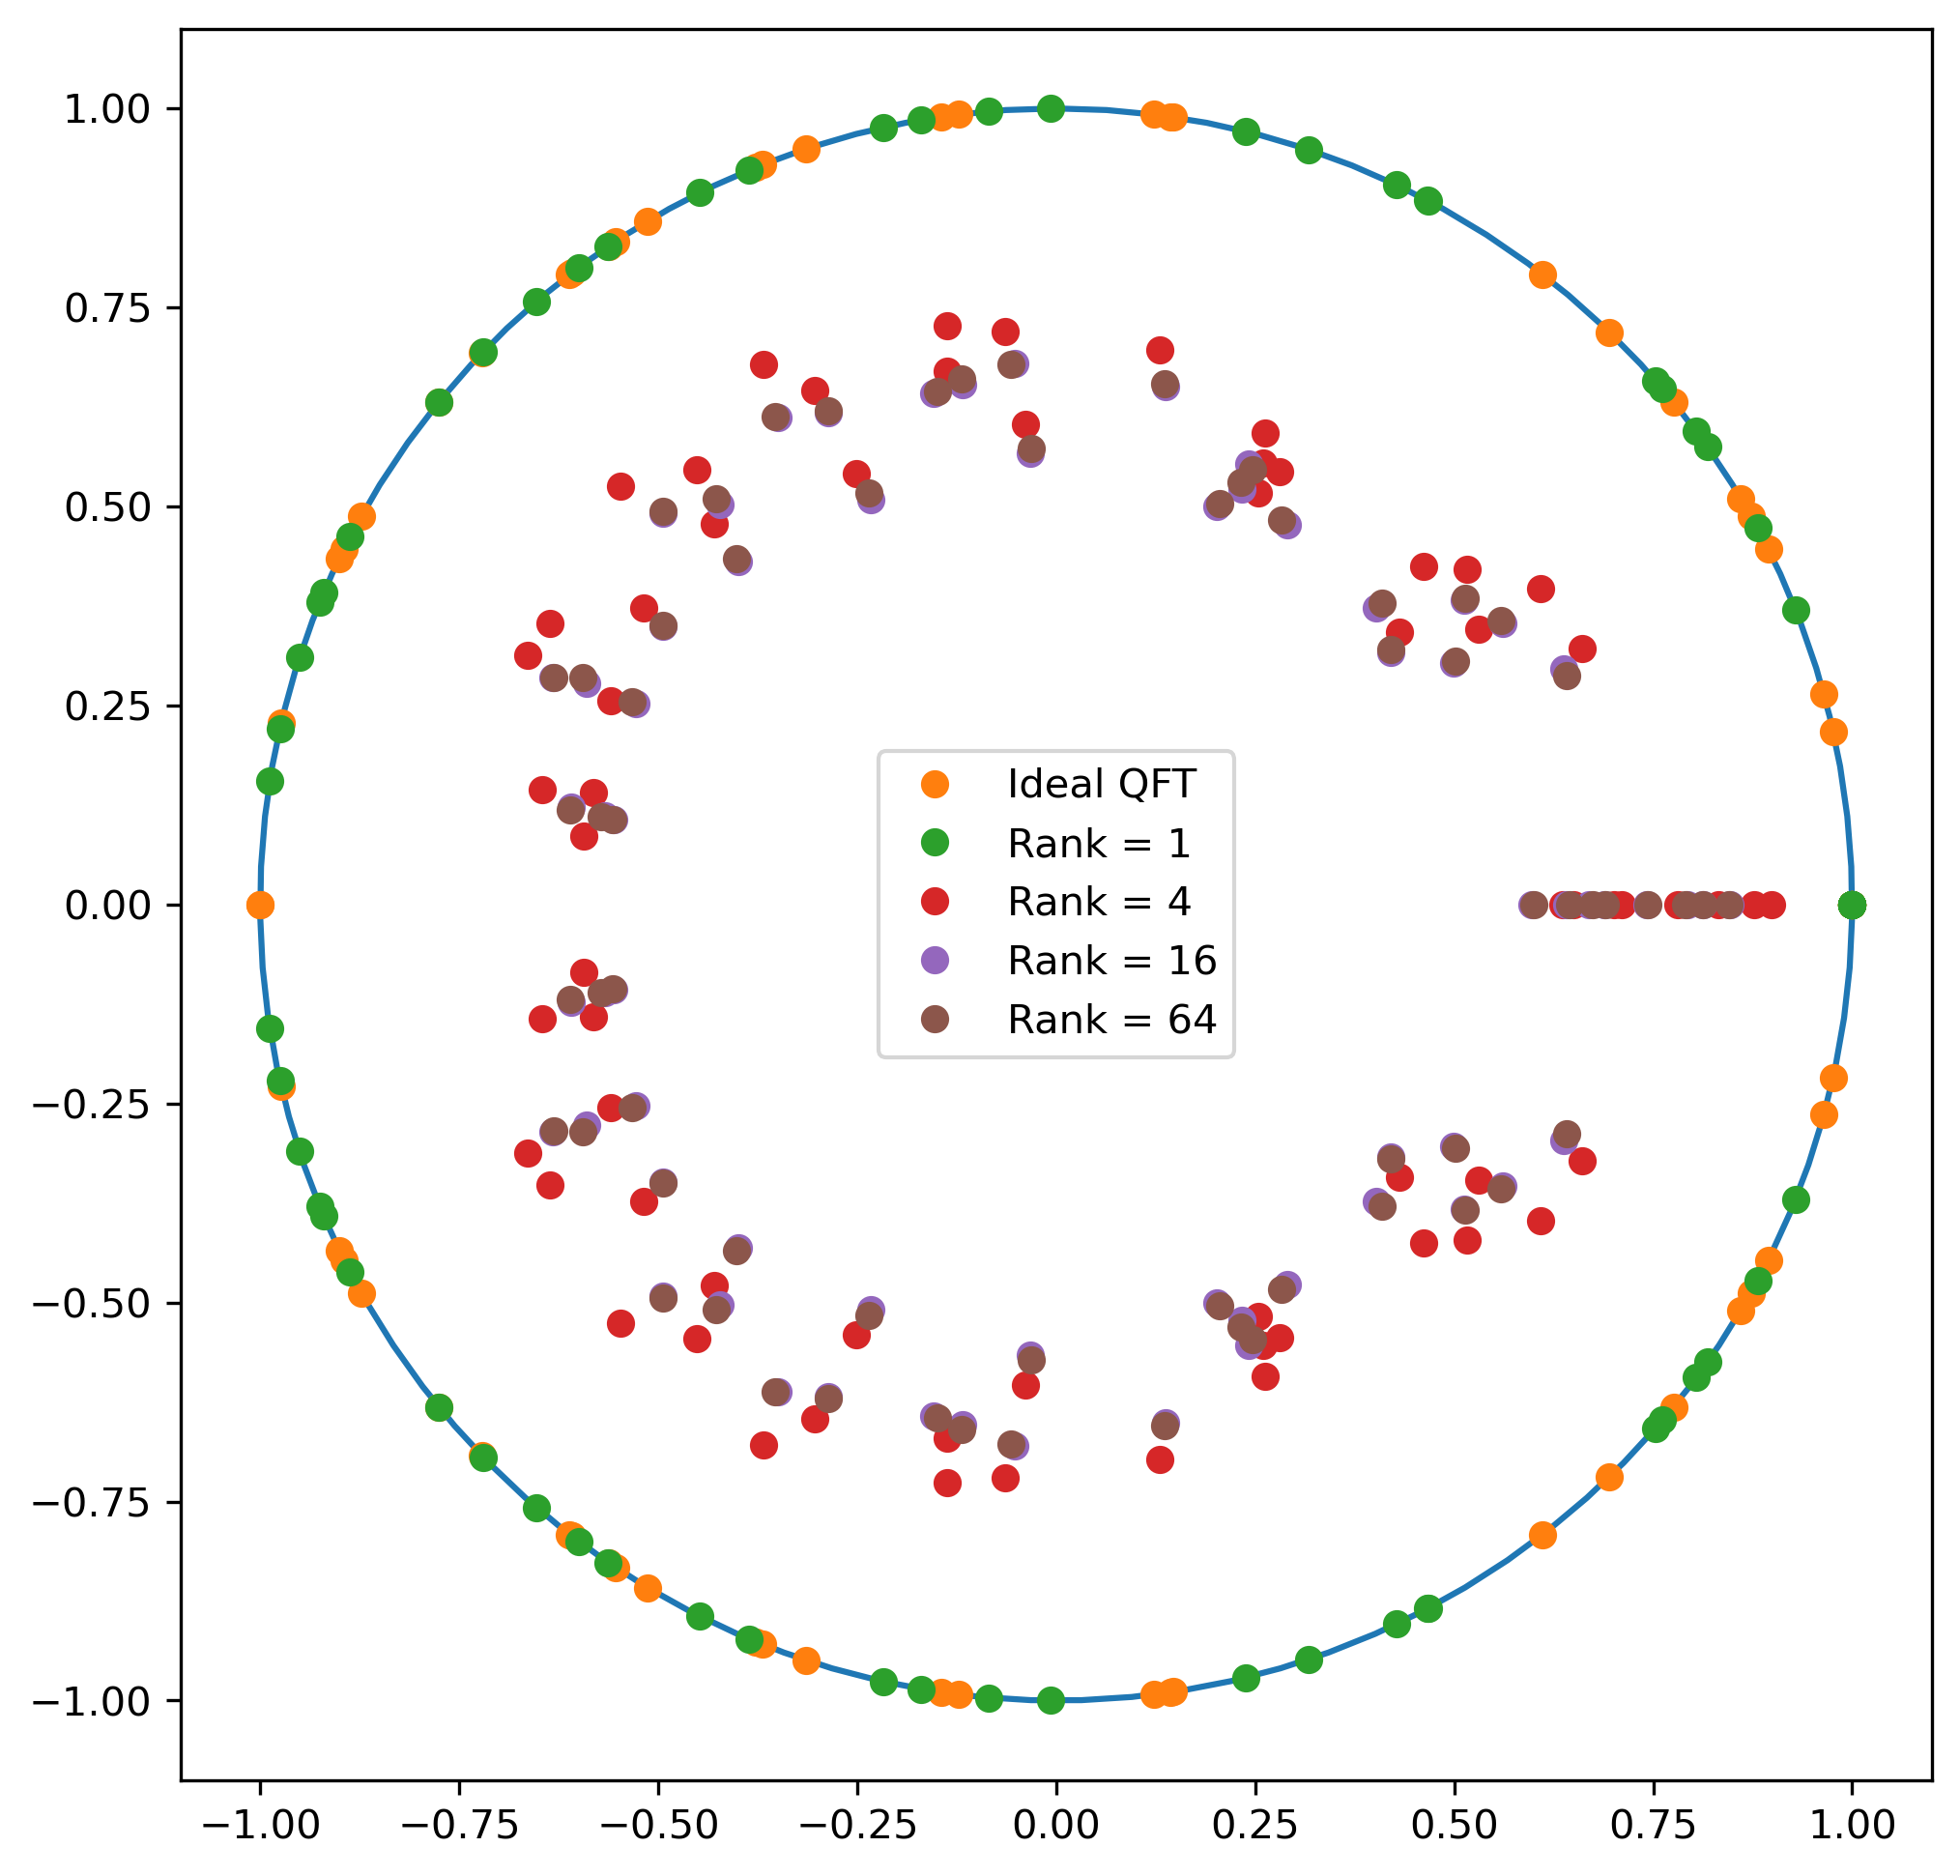

In [84]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle)
plt.plot(*spectrum_qft, "o")
plt.plot(*spectrum_unitary, "o")
plt.plot(*spectrum1, "o")
plt.plot(*spectrum2, "o")
plt.plot(*spectrum3, "o")
plt.legend(["_", "Ideal QFT", "Rank = 1", "Rank = 4","Rank = 16", "Rank = 64"])
plt.show()

In [149]:
#train kraus model
kraus_model_prior = KrausMap(U = U,
                             c = 0.9,
                             d = d, 
                             rank = 4,
                             spam = spam_model,
                             )

model = ModelQuantumMap(
                        q_map = kraus_model_prior,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model.train(inputs = inputs_map,
            targets = targets_map,
            num_iter = 3000,
            N = 1000
            )

  0%|          | 0/3000 [00:00<?, ?it/s]

Step:0, train: 0.12095, val: 0.00000
Step:1, train: 0.12206, val: 0.00000
Step:2, train: 0.12150, val: 0.00000
Step:3, train: 0.12179, val: 0.00000
Step:4, train: 0.11861, val: 0.00000
Step:5, train: 0.11984, val: 0.00000
Step:6, train: 0.12003, val: 0.00000
Step:7, train: 0.12026, val: 0.00000
Step:8, train: 0.11707, val: 0.00000
Step:9, train: 0.11372, val: 0.00000
Step:10, train: 0.11672, val: 0.00000
Step:11, train: 0.11671, val: 0.00000
Step:12, train: 0.11394, val: 0.00000
Step:13, train: 0.11358, val: 0.00000
Step:14, train: 0.11280, val: 0.00000
Step:15, train: 0.11210, val: 0.00000
Step:16, train: 0.11432, val: 0.00000
Step:17, train: 0.10943, val: 0.00000
Step:18, train: 0.11249, val: 0.00000
Step:19, train: 0.10667, val: 0.00000
Step:20, train: 0.11240, val: 0.00000
Step:21, train: 0.11063, val: 0.00000
Step:22, train: 0.10802, val: 0.00000
Step:23, train: 0.10590, val: 0.00000
Step:24, train: 0.10680, val: 0.00000
Step:25, train: 0.10480, val: 0.00000
Step:26, train: 0.1071

Step:213, train: 0.01174, val: 0.00000
Step:214, train: 0.01182, val: 0.00000
Step:215, train: 0.01170, val: 0.00000
Step:216, train: 0.01155, val: 0.00000
Step:217, train: 0.01155, val: 0.00000
Step:218, train: 0.01156, val: 0.00000
Step:219, train: 0.01120, val: 0.00000
Step:220, train: 0.01133, val: 0.00000
Step:221, train: 0.01160, val: 0.00000
Step:222, train: 0.01103, val: 0.00000
Step:223, train: 0.01094, val: 0.00000
Step:224, train: 0.01113, val: 0.00000
Step:225, train: 0.01113, val: 0.00000
Step:226, train: 0.01127, val: 0.00000
Step:227, train: 0.01114, val: 0.00000
Step:228, train: 0.01128, val: 0.00000
Step:229, train: 0.01097, val: 0.00000
Step:230, train: 0.01116, val: 0.00000
Step:231, train: 0.01114, val: 0.00000
Step:232, train: 0.01097, val: 0.00000
Step:233, train: 0.01085, val: 0.00000
Step:234, train: 0.01070, val: 0.00000
Step:235, train: 0.01101, val: 0.00000
Step:236, train: 0.01059, val: 0.00000
Step:237, train: 0.01067, val: 0.00000
Step:238, train: 0.01064,

Step:426, train: 0.00838, val: 0.00000
Step:427, train: 0.00859, val: 0.00000
Step:428, train: 0.00832, val: 0.00000
Step:429, train: 0.00840, val: 0.00000
Step:430, train: 0.00822, val: 0.00000
Step:431, train: 0.00840, val: 0.00000
Step:432, train: 0.00845, val: 0.00000
Step:433, train: 0.00824, val: 0.00000
Step:434, train: 0.00833, val: 0.00000
Step:435, train: 0.00832, val: 0.00000
Step:436, train: 0.00826, val: 0.00000
Step:437, train: 0.00834, val: 0.00000
Step:438, train: 0.00838, val: 0.00000
Step:439, train: 0.00835, val: 0.00000
Step:440, train: 0.00842, val: 0.00000
Step:441, train: 0.00836, val: 0.00000
Step:442, train: 0.00819, val: 0.00000
Step:443, train: 0.00840, val: 0.00000
Step:444, train: 0.00833, val: 0.00000
Step:445, train: 0.00851, val: 0.00000
Step:446, train: 0.00835, val: 0.00000
Step:447, train: 0.00826, val: 0.00000
Step:448, train: 0.00825, val: 0.00000
Step:449, train: 0.00835, val: 0.00000
Step:450, train: 0.00831, val: 0.00000
Step:451, train: 0.00818,

Step:637, train: 0.00774, val: 0.00000
Step:638, train: 0.00757, val: 0.00000
Step:639, train: 0.00764, val: 0.00000
Step:640, train: 0.00781, val: 0.00000
Step:641, train: 0.00761, val: 0.00000
Step:642, train: 0.00766, val: 0.00000
Step:643, train: 0.00771, val: 0.00000
Step:644, train: 0.00773, val: 0.00000
Step:645, train: 0.00764, val: 0.00000
Step:646, train: 0.00771, val: 0.00000
Step:647, train: 0.00783, val: 0.00000
Step:648, train: 0.00760, val: 0.00000
Step:649, train: 0.00769, val: 0.00000
Step:650, train: 0.00784, val: 0.00000
Step:651, train: 0.00777, val: 0.00000
Step:652, train: 0.00756, val: 0.00000
Step:653, train: 0.00762, val: 0.00000
Step:654, train: 0.00777, val: 0.00000
Step:655, train: 0.00770, val: 0.00000
Step:656, train: 0.00780, val: 0.00000
Step:657, train: 0.00764, val: 0.00000
Step:658, train: 0.00778, val: 0.00000
Step:659, train: 0.00775, val: 0.00000
Step:660, train: 0.00756, val: 0.00000
Step:661, train: 0.00782, val: 0.00000
Step:662, train: 0.00766,

Step:848, train: 0.00730, val: 0.00000
Step:849, train: 0.00743, val: 0.00000
Step:850, train: 0.00747, val: 0.00000
Step:851, train: 0.00732, val: 0.00000
Step:852, train: 0.00739, val: 0.00000
Step:853, train: 0.00736, val: 0.00000
Step:854, train: 0.00742, val: 0.00000
Step:855, train: 0.00737, val: 0.00000
Step:856, train: 0.00742, val: 0.00000
Step:857, train: 0.00746, val: 0.00000
Step:858, train: 0.00730, val: 0.00000
Step:859, train: 0.00726, val: 0.00000
Step:860, train: 0.00727, val: 0.00000
Step:861, train: 0.00757, val: 0.00000
Step:862, train: 0.00743, val: 0.00000
Step:863, train: 0.00727, val: 0.00000
Step:864, train: 0.00724, val: 0.00000
Step:865, train: 0.00728, val: 0.00000
Step:866, train: 0.00741, val: 0.00000
Step:867, train: 0.00743, val: 0.00000
Step:868, train: 0.00729, val: 0.00000
Step:869, train: 0.00745, val: 0.00000
Step:870, train: 0.00742, val: 0.00000
Step:871, train: 0.00740, val: 0.00000
Step:872, train: 0.00747, val: 0.00000
Step:873, train: 0.00739,

Step:1058, train: 0.00744, val: 0.00000
Step:1059, train: 0.00739, val: 0.00000
Step:1060, train: 0.00713, val: 0.00000
Step:1061, train: 0.00734, val: 0.00000
Step:1062, train: 0.00730, val: 0.00000
Step:1063, train: 0.00739, val: 0.00000
Step:1064, train: 0.00731, val: 0.00000
Step:1065, train: 0.00734, val: 0.00000
Step:1066, train: 0.00729, val: 0.00000
Step:1067, train: 0.00736, val: 0.00000
Step:1068, train: 0.00737, val: 0.00000
Step:1069, train: 0.00728, val: 0.00000
Step:1070, train: 0.00742, val: 0.00000
Step:1071, train: 0.00746, val: 0.00000
Step:1072, train: 0.00752, val: 0.00000
Step:1073, train: 0.00715, val: 0.00000
Step:1074, train: 0.00724, val: 0.00000
Step:1075, train: 0.00733, val: 0.00000
Step:1076, train: 0.00725, val: 0.00000
Step:1077, train: 0.00727, val: 0.00000
Step:1078, train: 0.00727, val: 0.00000
Step:1079, train: 0.00732, val: 0.00000
Step:1080, train: 0.00728, val: 0.00000
Step:1081, train: 0.00746, val: 0.00000
Step:1082, train: 0.00727, val: 0.00000


Step:1265, train: 0.00740, val: 0.00000
Step:1266, train: 0.00728, val: 0.00000
Step:1267, train: 0.00725, val: 0.00000
Step:1268, train: 0.00714, val: 0.00000
Step:1269, train: 0.00722, val: 0.00000
Step:1270, train: 0.00718, val: 0.00000
Step:1271, train: 0.00732, val: 0.00000
Step:1272, train: 0.00737, val: 0.00000
Step:1273, train: 0.00731, val: 0.00000
Step:1274, train: 0.00723, val: 0.00000
Step:1275, train: 0.00742, val: 0.00000
Step:1276, train: 0.00740, val: 0.00000
Step:1277, train: 0.00734, val: 0.00000
Step:1278, train: 0.00729, val: 0.00000
Step:1279, train: 0.00733, val: 0.00000
Step:1280, train: 0.00750, val: 0.00000
Step:1281, train: 0.00714, val: 0.00000
Step:1282, train: 0.00737, val: 0.00000
Step:1283, train: 0.00735, val: 0.00000
Step:1284, train: 0.00717, val: 0.00000
Step:1285, train: 0.00721, val: 0.00000
Step:1286, train: 0.00731, val: 0.00000
Step:1287, train: 0.00740, val: 0.00000
Step:1288, train: 0.00715, val: 0.00000
Step:1289, train: 0.00735, val: 0.00000


Step:1471, train: 0.00738, val: 0.00000
Step:1472, train: 0.00735, val: 0.00000
Step:1473, train: 0.00716, val: 0.00000
Step:1474, train: 0.00730, val: 0.00000
Step:1475, train: 0.00734, val: 0.00000
Step:1476, train: 0.00708, val: 0.00000
Step:1477, train: 0.00729, val: 0.00000
Step:1478, train: 0.00722, val: 0.00000
Step:1479, train: 0.00727, val: 0.00000
Step:1480, train: 0.00735, val: 0.00000
Step:1481, train: 0.00729, val: 0.00000
Step:1482, train: 0.00735, val: 0.00000
Step:1483, train: 0.00733, val: 0.00000
Step:1484, train: 0.00716, val: 0.00000
Step:1485, train: 0.00731, val: 0.00000
Step:1486, train: 0.00727, val: 0.00000
Step:1487, train: 0.00732, val: 0.00000
Step:1488, train: 0.00726, val: 0.00000
Step:1489, train: 0.00739, val: 0.00000
Step:1490, train: 0.00730, val: 0.00000
Step:1491, train: 0.00728, val: 0.00000
Step:1492, train: 0.00738, val: 0.00000
Step:1493, train: 0.00718, val: 0.00000
Step:1494, train: 0.00721, val: 0.00000
Step:1495, train: 0.00739, val: 0.00000


Step:1677, train: 0.00722, val: 0.00000
Step:1678, train: 0.00721, val: 0.00000
Step:1679, train: 0.00728, val: 0.00000
Step:1680, train: 0.00737, val: 0.00000
Step:1681, train: 0.00722, val: 0.00000
Step:1682, train: 0.00734, val: 0.00000
Step:1683, train: 0.00726, val: 0.00000
Step:1684, train: 0.00734, val: 0.00000
Step:1685, train: 0.00714, val: 0.00000
Step:1686, train: 0.00738, val: 0.00000
Step:1687, train: 0.00733, val: 0.00000
Step:1688, train: 0.00731, val: 0.00000
Step:1689, train: 0.00728, val: 0.00000
Step:1690, train: 0.00728, val: 0.00000
Step:1691, train: 0.00732, val: 0.00000
Step:1692, train: 0.00730, val: 0.00000
Step:1693, train: 0.00712, val: 0.00000
Step:1694, train: 0.00719, val: 0.00000
Step:1695, train: 0.00725, val: 0.00000
Step:1696, train: 0.00732, val: 0.00000
Step:1697, train: 0.00735, val: 0.00000
Step:1698, train: 0.00703, val: 0.00000
Step:1699, train: 0.00711, val: 0.00000
Step:1700, train: 0.00726, val: 0.00000
Step:1701, train: 0.00732, val: 0.00000


Step:1882, train: 0.00738, val: 0.00000
Step:1883, train: 0.00725, val: 0.00000
Step:1884, train: 0.00733, val: 0.00000
Step:1885, train: 0.00739, val: 0.00000
Step:1886, train: 0.00722, val: 0.00000
Step:1887, train: 0.00735, val: 0.00000
Step:1888, train: 0.00753, val: 0.00000
Step:1889, train: 0.00714, val: 0.00000
Step:1890, train: 0.00727, val: 0.00000
Step:1891, train: 0.00720, val: 0.00000
Step:1892, train: 0.00724, val: 0.00000
Step:1893, train: 0.00720, val: 0.00000
Step:1894, train: 0.00723, val: 0.00000
Step:1895, train: 0.00732, val: 0.00000
Step:1896, train: 0.00744, val: 0.00000
Step:1897, train: 0.00743, val: 0.00000
Step:1898, train: 0.00719, val: 0.00000
Step:1899, train: 0.00717, val: 0.00000
Step:1900, train: 0.00732, val: 0.00000
Step:1901, train: 0.00730, val: 0.00000
Step:1902, train: 0.00725, val: 0.00000
Step:1903, train: 0.00727, val: 0.00000
Step:1904, train: 0.00719, val: 0.00000
Step:1905, train: 0.00721, val: 0.00000
Step:1906, train: 0.00738, val: 0.00000


Step:2087, train: 0.00724, val: 0.00000
Step:2088, train: 0.00723, val: 0.00000
Step:2089, train: 0.00722, val: 0.00000
Step:2090, train: 0.00740, val: 0.00000
Step:2091, train: 0.00731, val: 0.00000
Step:2092, train: 0.00723, val: 0.00000
Step:2093, train: 0.00730, val: 0.00000
Step:2094, train: 0.00718, val: 0.00000
Step:2095, train: 0.00722, val: 0.00000
Step:2096, train: 0.00720, val: 0.00000
Step:2097, train: 0.00739, val: 0.00000
Step:2098, train: 0.00716, val: 0.00000
Step:2099, train: 0.00739, val: 0.00000
Step:2100, train: 0.00734, val: 0.00000
Step:2101, train: 0.00732, val: 0.00000
Step:2102, train: 0.00735, val: 0.00000
Step:2103, train: 0.00733, val: 0.00000
Step:2104, train: 0.00730, val: 0.00000
Step:2105, train: 0.00731, val: 0.00000
Step:2106, train: 0.00739, val: 0.00000
Step:2107, train: 0.00722, val: 0.00000
Step:2108, train: 0.00733, val: 0.00000
Step:2109, train: 0.00723, val: 0.00000
Step:2110, train: 0.00733, val: 0.00000
Step:2111, train: 0.00722, val: 0.00000


Step:2292, train: 0.00729, val: 0.00000
Step:2293, train: 0.00715, val: 0.00000
Step:2294, train: 0.00731, val: 0.00000
Step:2295, train: 0.00721, val: 0.00000
Step:2296, train: 0.00725, val: 0.00000
Step:2297, train: 0.00714, val: 0.00000
Step:2298, train: 0.00731, val: 0.00000
Step:2299, train: 0.00716, val: 0.00000
Step:2300, train: 0.00724, val: 0.00000
Step:2301, train: 0.00729, val: 0.00000
Step:2302, train: 0.00732, val: 0.00000
Step:2303, train: 0.00737, val: 0.00000
Step:2304, train: 0.00712, val: 0.00000
Step:2305, train: 0.00724, val: 0.00000
Step:2306, train: 0.00714, val: 0.00000
Step:2307, train: 0.00730, val: 0.00000
Step:2308, train: 0.00739, val: 0.00000
Step:2309, train: 0.00712, val: 0.00000
Step:2310, train: 0.00726, val: 0.00000
Step:2311, train: 0.00728, val: 0.00000
Step:2312, train: 0.00724, val: 0.00000
Step:2313, train: 0.00715, val: 0.00000
Step:2314, train: 0.00714, val: 0.00000
Step:2315, train: 0.00711, val: 0.00000
Step:2316, train: 0.00724, val: 0.00000


Step:2499, train: 0.00723, val: 0.00000
Step:2500, train: 0.00728, val: 0.00000
Step:2501, train: 0.00714, val: 0.00000
Step:2502, train: 0.00729, val: 0.00000
Step:2503, train: 0.00722, val: 0.00000
Step:2504, train: 0.00717, val: 0.00000
Step:2505, train: 0.00737, val: 0.00000
Step:2506, train: 0.00735, val: 0.00000
Step:2507, train: 0.00717, val: 0.00000
Step:2508, train: 0.00721, val: 0.00000
Step:2509, train: 0.00714, val: 0.00000
Step:2510, train: 0.00724, val: 0.00000
Step:2511, train: 0.00729, val: 0.00000
Step:2512, train: 0.00710, val: 0.00000
Step:2513, train: 0.00717, val: 0.00000
Step:2514, train: 0.00721, val: 0.00000
Step:2515, train: 0.00735, val: 0.00000
Step:2516, train: 0.00727, val: 0.00000
Step:2517, train: 0.00713, val: 0.00000
Step:2518, train: 0.00721, val: 0.00000
Step:2519, train: 0.00712, val: 0.00000
Step:2520, train: 0.00729, val: 0.00000
Step:2521, train: 0.00736, val: 0.00000
Step:2522, train: 0.00727, val: 0.00000
Step:2523, train: 0.00732, val: 0.00000


Step:2704, train: 0.00725, val: 0.00000
Step:2705, train: 0.00732, val: 0.00000
Step:2706, train: 0.00728, val: 0.00000
Step:2707, train: 0.00727, val: 0.00000
Step:2708, train: 0.00725, val: 0.00000
Step:2709, train: 0.00710, val: 0.00000
Step:2710, train: 0.00712, val: 0.00000
Step:2711, train: 0.00713, val: 0.00000
Step:2712, train: 0.00717, val: 0.00000
Step:2713, train: 0.00719, val: 0.00000
Step:2714, train: 0.00706, val: 0.00000
Step:2715, train: 0.00735, val: 0.00000
Step:2716, train: 0.00731, val: 0.00000
Step:2717, train: 0.00730, val: 0.00000
Step:2718, train: 0.00715, val: 0.00000
Step:2719, train: 0.00713, val: 0.00000
Step:2720, train: 0.00739, val: 0.00000
Step:2721, train: 0.00723, val: 0.00000
Step:2722, train: 0.00725, val: 0.00000
Step:2723, train: 0.00704, val: 0.00000
Step:2724, train: 0.00730, val: 0.00000
Step:2725, train: 0.00734, val: 0.00000
Step:2726, train: 0.00721, val: 0.00000
Step:2727, train: 0.00717, val: 0.00000
Step:2728, train: 0.00722, val: 0.00000


Step:2910, train: 0.00729, val: 0.00000
Step:2911, train: 0.00735, val: 0.00000
Step:2912, train: 0.00715, val: 0.00000
Step:2913, train: 0.00713, val: 0.00000
Step:2914, train: 0.00732, val: 0.00000
Step:2915, train: 0.00727, val: 0.00000
Step:2916, train: 0.00738, val: 0.00000
Step:2917, train: 0.00740, val: 0.00000
Step:2918, train: 0.00718, val: 0.00000
Step:2919, train: 0.00727, val: 0.00000
Step:2920, train: 0.00726, val: 0.00000
Step:2921, train: 0.00715, val: 0.00000
Step:2922, train: 0.00728, val: 0.00000
Step:2923, train: 0.00725, val: 0.00000
Step:2924, train: 0.00729, val: 0.00000
Step:2925, train: 0.00716, val: 0.00000
Step:2926, train: 0.00719, val: 0.00000
Step:2927, train: 0.00728, val: 0.00000
Step:2928, train: 0.00731, val: 0.00000
Step:2929, train: 0.00718, val: 0.00000
Step:2930, train: 0.00730, val: 0.00000
Step:2931, train: 0.00724, val: 0.00000
Step:2932, train: 0.00711, val: 0.00000
Step:2933, train: 0.00700, val: 0.00000
Step:2934, train: 0.00722, val: 0.00000


In [150]:
print(kraus_model_prior.c)

tf.Tensor((0.4211196727881502-4.95775954867532e-19j), shape=(), dtype=complex128)


In [154]:
#train kraus model
kraus_model_random = KrausMap(U = U,
                             c = 0.4211196727881502,
                             d = d, 
                             rank = 4,
                             spam = spam_model,
                             )

In [155]:
choi_prior = kraus_to_choi(kraus_model_prior)
spectrum_prior = choi_spectrum(choi_prior)

choi_random = kraus_to_choi(kraus_model_random)
spectrum_random = choi_spectrum(choi_random)

C:\Users\krist\AppData\Local\Temp\ipykernel_6008\2247639571.py:11: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002E1B05DF580> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Prior", "Random"])


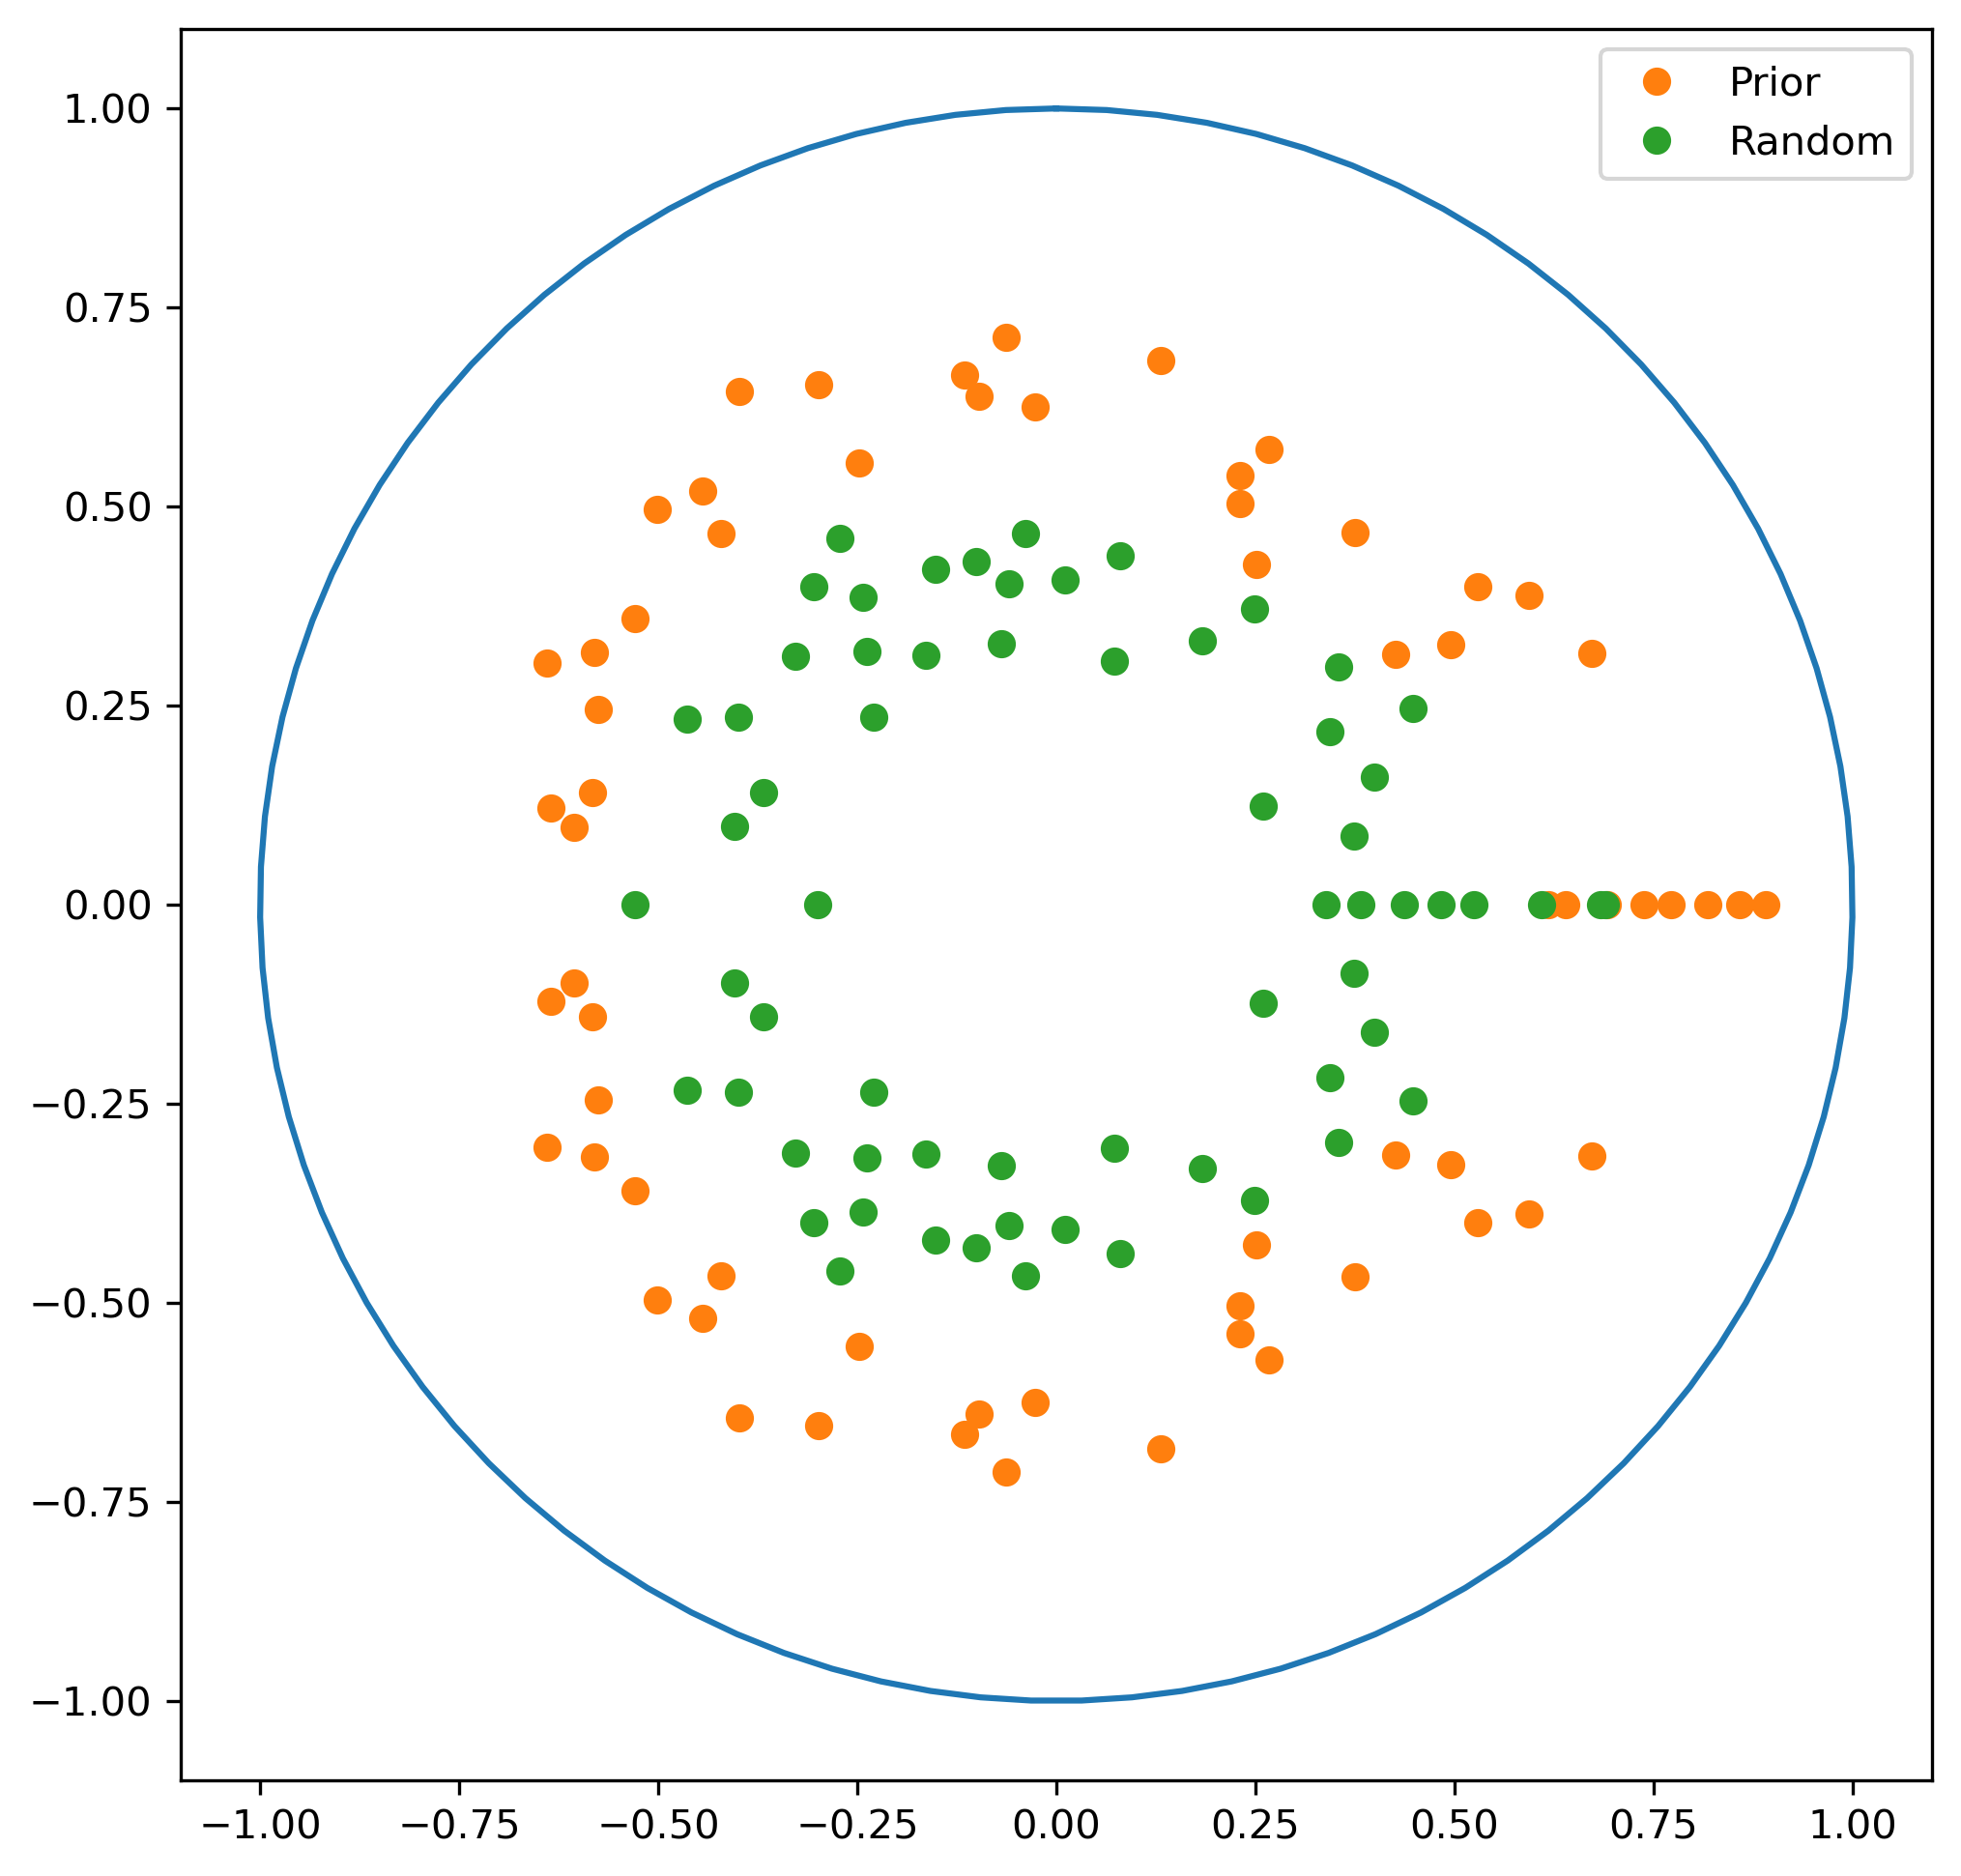

In [156]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle)
plt.plot(*spectrum_prior, "o")
plt.plot(*spectrum_random, "o")

plt.legend(["_", "Prior", "Random"])
plt.show()

## Four Qubit QTF

In [14]:
n = 4
d = 2**n

U = circuit_to_matrix(qft(n))

inputs_map1, inputs_spam, counts_map_list1 =  pickle.load(open("../../data/fourQubits_QFT.p", "rb"))
inputs_map2, counts_map_list2 =  pickle.load(open("../../data/fourQubits_QFT_more.p", "rb"))

inputs_map = [tf.concat([inputs_map1[0], inputs_map2[0]], axis=0), tf.concat([inputs_map1[1], inputs_map2[1]], axis=0)]

targets_map = counts_to_probs(counts_map_list1[:5000-6**n] + counts_map_list2)
targets_spam = counts_to_probs(counts_map_list[5000-6**n:])

In [15]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_model = SPAM(d=d,
                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                    num_iter = 1000,
                    )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 2000,
                )

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.007863060471572413
1 0.007836223626336025
2 0.007808059011934629
3 0.007779304059008658
4 0.007750208588145735
5 0.0077208802540344144
6 0.00769137047536121
7 0.007661692801127391
8 0.007631837269401748
9 0.007601793993710604
10 0.00757153858561445
11 0.0075410454083627045
12 0.007510269626112564
13 0.007479165646082902
14 0.007447703038897872
15 0.007415861642932722
16 0.007383623934275706
17 0.0073509220031291855
18 0.007317734948653188
19 0.007284001811397623
20 0.007249712976934538
21 0.007214814712909228
22 0.00717925912423531
23 0.007143008968096984
24 0.007105969694871262
25 0.007068170986384226
26 0.00702953924458989
27 0.0069899964375541405
28 0.006949474752689173
29 0.006908020354724289
30 0.0068656017361012935
31 0.006822080224780626
32 0.006777445530154113
33 0.006731666321507384
34 0.006684726827810025
35 0.00663662875304259
36 0.006587362896308326
37 0.006536880673792745
38 0.006485207152128875
39 0.0064322722149145126
40 0.0063780030379305816
41 0.006322465546782671


326 6.338789576696779e-06
327 6.285787675691829e-06
328 6.233406439403031e-06
329 6.181636241618268e-06
330 6.1304676778682956e-06
331 6.079887933426048e-06
332 6.029883460884306e-06
333 5.98044524643205e-06
334 5.931568179313676e-06
335 5.883240670541675e-06
336 5.835454407123266e-06
337 5.7882014234227945e-06
338 5.741475434318276e-06
339 5.695267092566257e-06
340 5.649566760985459e-06
341 5.604364707460837e-06
342 5.559652538327566e-06
343 5.515424522812942e-06
344 5.47167357633271e-06
345 5.428392981828961e-06
346 5.385577562191589e-06
347 5.3432229925954315e-06
348 5.3013239957803955e-06
349 5.259874969666575e-06
350 5.218849790491609e-06
351 5.178264213937184e-06
352 5.1381122280101575e-06
353 5.098348260315893e-06
354 5.05902143808462e-06
355 5.020121900960466e-06
356 4.981638458170002e-06
357 4.943560011255962e-06
358 4.905877684537109e-06
359 4.868584454971886e-06
360 4.831675508528382e-06
361 4.795147431174428e-06
362 4.758997198625646e-06
363 4.723221800189287e-06
364 4.6878

641 9.74333979546734e-07
642 9.699965338948182e-07
643 9.656841471175458e-07
644 9.613966438458734e-07
645 9.57133845538955e-07
646 9.528955705733158e-07
647 9.486816349123997e-07
648 9.44491853265748e-07
649 9.403260405942464e-07
650 9.361840137612673e-07
651 9.320655931106121e-07
652 9.279706037574288e-07
653 9.238988764188168e-07
654 9.198502476756983e-07
655 9.158245596386094e-07
656 9.118216590734804e-07
657 9.078413961156689e-07
658 9.038836227526223e-07
659 8.999481912812749e-07
660 8.960349529409131e-07
661 8.921437568955804e-07
662 8.882744496870143e-07
663 8.844268752163132e-07
664 8.806008752426648e-07
665 8.767962903219629e-07
666 8.730129610500018e-07
667 8.692507294419514e-07
668 8.65509440260276e-07
669 8.617889421170236e-07
670 8.580890882064746e-07
671 8.544097365777174e-07
672 8.507507499185247e-07
673 8.471119948876641e-07
674 8.434933410937321e-07
675 8.398946598611113e-07
676 8.363158229504768e-07
677 8.3275670140254e-07
678 8.292171646525671e-07
679 8.256970800249

964 2.9098975551677025e-07
965 2.9006358804570043e-07
966 2.8914112720314075e-07
967 2.8822235670649593e-07
968 2.873072609572573e-07
969 2.863958246482595e-07
970 2.8548803233294356e-07
971 2.845838680263757e-07
972 2.836833149050441e-07
973 2.827863551562237e-07
974 2.8189297000412735e-07
975 2.810031399119927e-07
976 2.8011684492936326e-07
977 2.7923406513032785e-07
978 2.7835478107135414e-07
979 2.7747897419334464e-07
980 2.766066271007604e-07
981 2.757377236685905e-07
982 2.74872248956851e-07
983 2.740101889433501e-07
984 2.731515301158957e-07
985 2.7229625898919134e-07
986 2.714443616262474e-07
987 2.705958232431194e-07
988 2.697506279649652e-07
989 2.6890875877606475e-07
990 2.6807019767507093e-07
991 2.672349260124727e-07
992 2.664029249561597e-07
993 2.655741760087622e-07
994 2.6474866148979373e-07
995 2.6392636490126635e-07
996 2.6310727111327994e-07
997 2.622913663355874e-07
998 2.6147863787825386e-07
999 2.606690737382638e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

0 0.02783446229398577
1 0.013305676500365769
2 0.008860207882907603
3 0.0104750092741426
4 0.011322943783447425
5 0.011364748885644167
6 0.010226844694277785
7 0.008567228357478838
8 0.006901903948109492
9 0.005679117483883417
10 0.005019184146573167
11 0.004765162634228004
12 0.004695396733994408
13 0.004680662753918526
14 0.004565776627990256
15 0.004427387299965037
16 0.004347302424307066
17 0.004263218187482238
18 0.004180508540512262
19 0.004144112220884075
20 0.004126970936883185
21 0.004027049140112359
22 0.0038647372322949116
23 0.003668573284023755
24 0.0035061740976601273
25 0.0033872003734502507
26 0.003330405659166944
27 0.00322887470802367
28 0.003158100304721073
29 0.003097532618630865
30 0.002988172481576178
31 0.00290373262283855
32 0.002876482341879653
33 0.0028644217610406973
34 0.002833491082340965
35 0.0027953616259134137
36 0.0027559197149700904
37 0.0027270395232478857
38 0.002710284296497889
39 0.002708925750695251
40 0.0027105873815441188
41 0.002716821288171750

327 0.0035727738155330387
328 0.0035959482195151073
329 0.003589096459109198
330 0.0034806980441516736
331 0.00324562068136032
332 0.0029629638166148637
333 0.0027544929097787635
334 0.0026252623648292143
335 0.002574875485441564
336 0.0025768304693855426
337 0.002622049434928928
338 0.002699879276008584
339 0.0027854379826814045
340 0.0028606931432353026
341 0.0029139210468317467
342 0.0029503982270668266
343 0.002958267287043215
344 0.00294231030885172
345 0.0029086258110714636
346 0.002867271355796215
347 0.0028279056598136255
348 0.0027968258789509027
349 0.0027763868189638876
350 0.002761294072946558
351 0.0027606468124106998
352 0.0027714808851727877
353 0.0027904597770749655
354 0.0028140404504478304
355 0.0028375299420890674
356 0.0028575825192253866
357 0.0028819812592415545
358 0.002900256885499231
359 0.0029127079495654034
360 0.0029201861032257656
361 0.0029237094259527154
362 0.0029262460260460134
363 0.0029323392416605774
364 0.0029195396054295447
365 0.002909448048833755

649 0.002320289872559696
650 0.0023207245404684228
651 0.0023187306295249102
652 0.002317098823148322
653 0.002316710102094058
654 0.0023146732044602666
655 0.002314475537783716
656 0.0023138093463972303
657 0.0023116400803905647
658 0.0023117591140893352
659 0.0023120941530660735
660 0.0023134812577057526
661 0.0023139380806240367
662 0.0023144332909684363
663 0.002316870614140257
664 0.0023176671012046586
665 0.0023202489116664364
666 0.0023204958399376543
667 0.002321268680802403
668 0.0023220930220783096
669 0.0023234328847030594
670 0.002323096208592454
671 0.0023225448078139452
672 0.0023227397128419186
673 0.0023218076319656625
674 0.0023218985727604426
675 0.002322717411701068
676 0.0023212593269557047
677 0.002321688117419352
678 0.0023241396912708754
679 0.0023235537160463562
680 0.002322095696996913
681 0.002322935579953726
682 0.0023216403464809483
683 0.0023233399201156267
684 0.002325637041722037
685 0.002327609409875534
686 0.002329387903131753
687 0.0023301820829021358


970 0.0021996686821994277
971 0.0021992452811163297
972 0.002199969667388477
973 0.0022006862911183533
974 0.00220043585247259
975 0.002200710184860895
976 0.0022011035241153633
977 0.0022001147319058193
978 0.0022020260807987585
979 0.0022012662039668195
980 0.002201599245682107
981 0.0022021421134113214
982 0.002201087966566994
983 0.0022016723242903233
984 0.0022023344160087173
985 0.0022006764343512806
986 0.0022003540711181507
987 0.0022013260509737244
988 0.002200158401228005
989 0.002200767718045999
990 0.0022018564749085516
991 0.0022011302702482274
992 0.0022016536240734605
993 0.0022030134497584646
994 0.002203170213251341
995 0.0022026348637437204
996 0.0022031623348156655
997 0.0022039315472655308
998 0.0022039464789251058
999 0.002203682046755022
1000 0.0022055603727313107
1001 0.0022049514726186575
1002 0.002205523339191661
1003 0.002204979433250203
1004 0.0022066157832647056
1005 0.002207663519011608
1006 0.002207007259288893
1007 0.0022063325234517785
1008 0.00220860176

1283 0.002469934220527837
1284 0.0024765623029817624
1285 0.0024861863574745296
1286 0.0024968689394951585
1287 0.002494798913154864
1288 0.002502126779281569
1289 0.0024965014120611447
1290 0.002492240640676717
1291 0.0024906926549722493
1292 0.0024868346054415895
1293 0.0024847469555152307
1294 0.002481911715417034
1295 0.002485276116626836
1296 0.002491203356841917
1297 0.0024914155267026865
1298 0.0025018725287512815
1299 0.0025056010042098014
1300 0.0025126796083726334
1301 0.002522871043036476
1302 0.002527597660867298
1303 0.0025285382065698666
1304 0.0025283560053635462
1305 0.0025252639174901813
1306 0.002518611918187591
1307 0.0025143408068262494
1308 0.0025077062858339387
1309 0.0025041399654830198
1310 0.002503149433719368
1311 0.0025034151391521127
1312 0.0025037486631856757
1313 0.002508137303367244
1314 0.0025130875814810883
1315 0.0025195388606414487
1316 0.002528220200224824
1317 0.0025361678284405906
1318 0.0025469139616608283
1319 0.0025493433651881383
1320 0.0025494

1592 0.0024335706407500697
1593 0.0024328005837575884
1594 0.0024301547853239616
1595 0.0024307110091297706
1596 0.002423729521723651
1597 0.002419082230632416
1598 0.0024179671079741344
1599 0.0024137207043458705
1600 0.002406202506080612
1601 0.0024060130837349116
1602 0.0024044380974134597
1603 0.002400567842725037
1604 0.0024015541366694576
1605 0.0024023944750573506
1606 0.0024062086678339565
1607 0.002409158640651219
1608 0.002411094673475377
1609 0.002412989379550264
1610 0.0024105446721077463
1611 0.0024083823885661295
1612 0.00240323041500257
1613 0.0024024253587648274
1614 0.002399385920481925
1615 0.002393157606600162
1616 0.002390153854188127
1617 0.002389739417060275
1618 0.002387313714522792
1619 0.0023824805477032124
1620 0.002386631474700353
1621 0.0023828070425969475
1622 0.0023811279208637124
1623 0.002387554143973572
1624 0.002386117299319368
1625 0.0023838239982957774
1626 0.00238709587184739
1627 0.0023883371703771823
1628 0.0023845676419955307
1629 0.0023848153125

1902 0.0022213182923698366
1903 0.0022213207519469155
1904 0.0022194348433472997
1905 0.0022217711476029225
1906 0.002220655576047234
1907 0.002220654794352268
1908 0.0022210616367617157
1909 0.002221462421287726
1910 0.002218703112816954
1911 0.0022180614030680055
1912 0.002217986984330531
1913 0.0022179847302739317
1914 0.0022146408489145545
1915 0.002216768047138118
1916 0.0022171047351748296
1917 0.002213667206135702
1918 0.0022143065757828056
1919 0.002212136249711958
1920 0.002213625456460358
1921 0.002214970687470032
1922 0.0022144744889314653
1923 0.0022143157540054654
1924 0.0022155698528914408
1925 0.002213195471462845
1926 0.0022136371393714684
1927 0.0022117260018791637
1928 0.0022105012108905612
1929 0.0022119420967983148
1930 0.0022118093770467175
1931 0.002210808713574583
1932 0.002210667048407512
1933 0.0022134053823968615
1934 0.002211856052437252
1935 0.0022105095283549915
1936 0.0022104861674327727
1937 0.0022114826392125187
1938 0.002209026782210343
1939 0.002209521

In [20]:
#train kraus model
kraus_model = KrausMap(
                       U = U,
                       c = 0.5,
                       d = d, 
                       rank = d,
                       spam = spam_model,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

In [21]:
model.train(inputs = inputs_map,
            targets = targets_map,
            num_iter = 3000,
            )

  0%|          | 0/3000 [00:00<?, ?it/s]

Step:0, train: 0.20103, val: 0.00000
Step:1, train: 0.19920, val: 0.00000
Step:2, train: 0.19496, val: 0.00000
Step:3, train: 0.19569, val: 0.00000
Step:4, train: 0.19483, val: 0.00000
Step:5, train: 0.18358, val: 0.00000
Step:6, train: 0.19481, val: 0.00000
Step:7, train: 0.18692, val: 0.00000
Step:8, train: 0.19205, val: 0.00000
Step:9, train: 0.18859, val: 0.00000
Step:10, train: 0.18654, val: 0.00000
Step:11, train: 0.17942, val: 0.00000
Step:12, train: 0.18301, val: 0.00000
Step:13, train: 0.17998, val: 0.00000
Step:14, train: 0.18256, val: 0.00000
Step:15, train: 0.17657, val: 0.00000
Step:16, train: 0.18051, val: 0.00000
Step:17, train: 0.17183, val: 0.00000
Step:18, train: 0.17744, val: 0.00000
Step:19, train: 0.17409, val: 0.00000
Step:20, train: 0.17033, val: 0.00000
Step:21, train: 0.16234, val: 0.00000
Step:22, train: 0.16807, val: 0.00000
Step:23, train: 0.16558, val: 0.00000
Step:24, train: 0.16452, val: 0.00000
Step:25, train: 0.16612, val: 0.00000
Step:26, train: 0.1624

Step:213, train: 0.02541, val: 0.00000
Step:214, train: 0.02630, val: 0.00000
Step:215, train: 0.02681, val: 0.00000
Step:216, train: 0.02596, val: 0.00000
Step:217, train: 0.02574, val: 0.00000
Step:218, train: 0.02550, val: 0.00000
Step:219, train: 0.02608, val: 0.00000
Step:220, train: 0.02476, val: 0.00000
Step:221, train: 0.02382, val: 0.00000
Step:222, train: 0.02486, val: 0.00000
Step:223, train: 0.02527, val: 0.00000
Step:224, train: 0.02522, val: 0.00000
Step:225, train: 0.02468, val: 0.00000
Step:226, train: 0.02463, val: 0.00000
Step:227, train: 0.02529, val: 0.00000
Step:228, train: 0.02543, val: 0.00000
Step:229, train: 0.02535, val: 0.00000
Step:230, train: 0.02389, val: 0.00000
Step:231, train: 0.02403, val: 0.00000
Step:232, train: 0.02475, val: 0.00000
Step:233, train: 0.02442, val: 0.00000
Step:234, train: 0.02546, val: 0.00000
Step:235, train: 0.02561, val: 0.00000
Step:236, train: 0.02492, val: 0.00000
Step:237, train: 0.02398, val: 0.00000
Step:238, train: 0.02371,

Step:424, train: 0.02119, val: 0.00000
Step:425, train: 0.02011, val: 0.00000
Step:426, train: 0.02147, val: 0.00000
Step:427, train: 0.02176, val: 0.00000
Step:428, train: 0.02093, val: 0.00000
Step:429, train: 0.02087, val: 0.00000
Step:430, train: 0.02121, val: 0.00000
Step:431, train: 0.02011, val: 0.00000
Step:432, train: 0.01977, val: 0.00000
Step:433, train: 0.02038, val: 0.00000
Step:434, train: 0.02076, val: 0.00000
Step:435, train: 0.02037, val: 0.00000
Step:436, train: 0.02117, val: 0.00000
Step:437, train: 0.02173, val: 0.00000
Step:438, train: 0.02027, val: 0.00000
Step:439, train: 0.02109, val: 0.00000
Step:440, train: 0.02083, val: 0.00000
Step:441, train: 0.02078, val: 0.00000
Step:442, train: 0.02104, val: 0.00000
Step:443, train: 0.02096, val: 0.00000
Step:444, train: 0.02101, val: 0.00000
Step:445, train: 0.02339, val: 0.00000
Step:446, train: 0.02173, val: 0.00000
Step:447, train: 0.02033, val: 0.00000
Step:448, train: 0.02030, val: 0.00000
Step:449, train: 0.02102,

Step:635, train: 0.02020, val: 0.00000
Step:636, train: 0.01998, val: 0.00000
Step:637, train: 0.01920, val: 0.00000
Step:638, train: 0.02118, val: 0.00000
Step:639, train: 0.02089, val: 0.00000
Step:640, train: 0.02018, val: 0.00000
Step:641, train: 0.01970, val: 0.00000
Step:642, train: 0.01938, val: 0.00000
Step:643, train: 0.01961, val: 0.00000
Step:644, train: 0.01995, val: 0.00000
Step:645, train: 0.02000, val: 0.00000
Step:646, train: 0.02095, val: 0.00000
Step:647, train: 0.01961, val: 0.00000
Step:648, train: 0.02049, val: 0.00000
Step:649, train: 0.01975, val: 0.00000
Step:650, train: 0.02044, val: 0.00000
Step:651, train: 0.01947, val: 0.00000
Step:652, train: 0.01987, val: 0.00000
Step:653, train: 0.02019, val: 0.00000
Step:654, train: 0.01942, val: 0.00000
Step:655, train: 0.02005, val: 0.00000
Step:656, train: 0.01990, val: 0.00000
Step:657, train: 0.02056, val: 0.00000
Step:658, train: 0.01994, val: 0.00000
Step:659, train: 0.01988, val: 0.00000
Step:660, train: 0.01901,

Step:846, train: 0.01988, val: 0.00000
Step:847, train: 0.01996, val: 0.00000
Step:848, train: 0.01984, val: 0.00000
Step:849, train: 0.01924, val: 0.00000
Step:850, train: 0.01900, val: 0.00000
Step:851, train: 0.02023, val: 0.00000
Step:852, train: 0.01980, val: 0.00000
Step:853, train: 0.01960, val: 0.00000
Step:854, train: 0.01925, val: 0.00000
Step:855, train: 0.02060, val: 0.00000
Step:856, train: 0.01833, val: 0.00000
Step:857, train: 0.01978, val: 0.00000
Step:858, train: 0.01937, val: 0.00000
Step:859, train: 0.02027, val: 0.00000
Step:860, train: 0.01860, val: 0.00000
Step:861, train: 0.01873, val: 0.00000
Step:862, train: 0.01970, val: 0.00000
Step:863, train: 0.01911, val: 0.00000
Step:864, train: 0.02072, val: 0.00000
Step:865, train: 0.01929, val: 0.00000
Step:866, train: 0.02079, val: 0.00000
Step:867, train: 0.01935, val: 0.00000
Step:868, train: 0.01986, val: 0.00000
Step:869, train: 0.02059, val: 0.00000
Step:870, train: 0.01870, val: 0.00000
Step:871, train: 0.01933,

Step:1055, train: 0.02011, val: 0.00000
Step:1056, train: 0.01943, val: 0.00000
Step:1057, train: 0.01973, val: 0.00000
Step:1058, train: 0.01853, val: 0.00000
Step:1059, train: 0.01893, val: 0.00000
Step:1060, train: 0.02004, val: 0.00000
Step:1061, train: 0.01997, val: 0.00000
Step:1062, train: 0.01928, val: 0.00000
Step:1063, train: 0.01924, val: 0.00000
Step:1064, train: 0.01897, val: 0.00000
Step:1065, train: 0.01843, val: 0.00000
Step:1066, train: 0.02000, val: 0.00000
Step:1067, train: 0.01882, val: 0.00000
Step:1068, train: 0.01879, val: 0.00000
Step:1069, train: 0.01945, val: 0.00000
Step:1070, train: 0.01966, val: 0.00000
Step:1071, train: 0.01951, val: 0.00000
Step:1072, train: 0.01957, val: 0.00000
Step:1073, train: 0.01899, val: 0.00000
Step:1074, train: 0.01891, val: 0.00000
Step:1075, train: 0.01993, val: 0.00000
Step:1076, train: 0.01900, val: 0.00000
Step:1077, train: 0.01896, val: 0.00000
Step:1078, train: 0.01944, val: 0.00000
Step:1079, train: 0.01837, val: 0.00000


Step:1260, train: 0.01833, val: 0.00000
Step:1261, train: 0.02017, val: 0.00000
Step:1262, train: 0.01958, val: 0.00000
Step:1263, train: 0.01929, val: 0.00000
Step:1264, train: 0.01915, val: 0.00000
Step:1265, train: 0.01882, val: 0.00000
Step:1266, train: 0.01898, val: 0.00000
Step:1267, train: 0.01923, val: 0.00000
Step:1268, train: 0.01863, val: 0.00000
Step:1269, train: 0.01921, val: 0.00000
Step:1270, train: 0.01984, val: 0.00000
Step:1271, train: 0.01932, val: 0.00000
Step:1272, train: 0.01946, val: 0.00000
Step:1273, train: 0.01932, val: 0.00000
Step:1274, train: 0.01838, val: 0.00000
Step:1275, train: 0.01929, val: 0.00000
Step:1276, train: 0.01933, val: 0.00000
Step:1277, train: 0.01948, val: 0.00000
Step:1278, train: 0.01884, val: 0.00000
Step:1279, train: 0.01951, val: 0.00000
Step:1280, train: 0.01921, val: 0.00000
Step:1281, train: 0.01973, val: 0.00000
Step:1282, train: 0.01877, val: 0.00000
Step:1283, train: 0.01898, val: 0.00000
Step:1284, train: 0.01875, val: 0.00000


Step:1465, train: 0.01967, val: 0.00000
Step:1466, train: 0.01860, val: 0.00000
Step:1467, train: 0.01889, val: 0.00000
Step:1468, train: 0.01951, val: 0.00000
Step:1469, train: 0.01873, val: 0.00000
Step:1470, train: 0.02014, val: 0.00000
Step:1471, train: 0.01782, val: 0.00000
Step:1472, train: 0.01951, val: 0.00000
Step:1473, train: 0.01856, val: 0.00000
Step:1474, train: 0.01874, val: 0.00000
Step:1475, train: 0.01951, val: 0.00000
Step:1476, train: 0.01978, val: 0.00000
Step:1477, train: 0.01922, val: 0.00000
Step:1478, train: 0.01837, val: 0.00000
Step:1479, train: 0.01940, val: 0.00000
Step:1480, train: 0.01970, val: 0.00000
Step:1481, train: 0.01904, val: 0.00000
Step:1482, train: 0.01970, val: 0.00000
Step:1483, train: 0.01831, val: 0.00000
Step:1484, train: 0.01931, val: 0.00000
Step:1485, train: 0.01935, val: 0.00000
Step:1486, train: 0.02017, val: 0.00000
Step:1487, train: 0.01947, val: 0.00000
Step:1488, train: 0.01911, val: 0.00000
Step:1489, train: 0.01865, val: 0.00000


Step:1670, train: 0.01847, val: 0.00000
Step:1671, train: 0.01877, val: 0.00000
Step:1672, train: 0.01842, val: 0.00000
Step:1673, train: 0.01932, val: 0.00000
Step:1674, train: 0.01923, val: 0.00000
Step:1675, train: 0.01906, val: 0.00000
Step:1676, train: 0.01963, val: 0.00000
Step:1677, train: 0.01885, val: 0.00000
Step:1678, train: 0.01897, val: 0.00000
Step:1679, train: 0.01918, val: 0.00000
Step:1680, train: 0.01955, val: 0.00000
Step:1681, train: 0.02027, val: 0.00000
Step:1682, train: 0.02033, val: 0.00000
Step:1683, train: 0.01950, val: 0.00000
Step:1684, train: 0.01875, val: 0.00000
Step:1685, train: 0.01899, val: 0.00000
Step:1686, train: 0.02057, val: 0.00000
Step:1687, train: 0.01895, val: 0.00000
Step:1688, train: 0.01902, val: 0.00000
Step:1689, train: 0.01943, val: 0.00000
Step:1690, train: 0.01877, val: 0.00000
Step:1691, train: 0.01990, val: 0.00000
Step:1692, train: 0.01860, val: 0.00000
Step:1693, train: 0.02006, val: 0.00000
Step:1694, train: 0.01961, val: 0.00000


Step:1875, train: 0.01909, val: 0.00000
Step:1876, train: 0.01912, val: 0.00000
Step:1877, train: 0.01939, val: 0.00000
Step:1878, train: 0.01866, val: 0.00000
Step:1879, train: 0.01814, val: 0.00000
Step:1880, train: 0.01916, val: 0.00000
Step:1881, train: 0.01845, val: 0.00000
Step:1882, train: 0.01957, val: 0.00000
Step:1883, train: 0.01863, val: 0.00000
Step:1884, train: 0.01920, val: 0.00000
Step:1885, train: 0.01950, val: 0.00000
Step:1886, train: 0.01986, val: 0.00000
Step:1887, train: 0.01890, val: 0.00000
Step:1888, train: 0.01876, val: 0.00000
Step:1889, train: 0.01980, val: 0.00000
Step:1890, train: 0.01889, val: 0.00000
Step:1891, train: 0.01990, val: 0.00000
Step:1892, train: 0.01827, val: 0.00000
Step:1893, train: 0.01811, val: 0.00000
Step:1894, train: 0.01983, val: 0.00000
Step:1895, train: 0.01987, val: 0.00000
Step:1896, train: 0.01923, val: 0.00000
Step:1897, train: 0.01888, val: 0.00000
Step:1898, train: 0.01936, val: 0.00000
Step:1899, train: 0.01912, val: 0.00000


Step:2081, train: 0.01860, val: 0.00000
Step:2082, train: 0.01886, val: 0.00000
Step:2083, train: 0.01879, val: 0.00000
Step:2084, train: 0.01962, val: 0.00000
Step:2085, train: 0.01874, val: 0.00000
Step:2086, train: 0.01870, val: 0.00000
Step:2087, train: 0.01948, val: 0.00000
Step:2088, train: 0.01957, val: 0.00000
Step:2089, train: 0.02002, val: 0.00000
Step:2090, train: 0.01949, val: 0.00000
Step:2091, train: 0.01940, val: 0.00000
Step:2092, train: 0.01898, val: 0.00000
Step:2093, train: 0.01973, val: 0.00000
Step:2094, train: 0.01891, val: 0.00000
Step:2095, train: 0.01914, val: 0.00000
Step:2096, train: 0.01952, val: 0.00000
Step:2097, train: 0.01847, val: 0.00000
Step:2098, train: 0.01922, val: 0.00000
Step:2099, train: 0.01887, val: 0.00000
Step:2100, train: 0.01881, val: 0.00000
Step:2101, train: 0.02004, val: 0.00000
Step:2102, train: 0.01810, val: 0.00000
Step:2103, train: 0.01946, val: 0.00000
Step:2104, train: 0.01831, val: 0.00000
Step:2105, train: 0.01914, val: 0.00000


Step:2286, train: 0.01865, val: 0.00000
Step:2287, train: 0.01833, val: 0.00000
Step:2288, train: 0.01793, val: 0.00000
Step:2289, train: 0.01884, val: 0.00000
Step:2290, train: 0.01953, val: 0.00000
Step:2291, train: 0.02010, val: 0.00000
Step:2292, train: 0.01887, val: 0.00000
Step:2293, train: 0.01902, val: 0.00000
Step:2294, train: 0.01926, val: 0.00000
Step:2295, train: 0.01962, val: 0.00000
Step:2296, train: 0.01918, val: 0.00000
Step:2297, train: 0.01985, val: 0.00000
Step:2298, train: 0.01872, val: 0.00000
Step:2299, train: 0.01959, val: 0.00000
Step:2300, train: 0.01929, val: 0.00000
Step:2301, train: 0.01920, val: 0.00000
Step:2302, train: 0.02002, val: 0.00000
Step:2303, train: 0.01976, val: 0.00000
Step:2304, train: 0.01876, val: 0.00000
Step:2305, train: 0.02007, val: 0.00000
Step:2306, train: 0.01992, val: 0.00000
Step:2307, train: 0.01881, val: 0.00000
Step:2308, train: 0.01936, val: 0.00000
Step:2309, train: 0.01810, val: 0.00000
Step:2310, train: 0.01958, val: 0.00000


Step:2491, train: 0.01902, val: 0.00000
Step:2492, train: 0.01782, val: 0.00000
Step:2493, train: 0.01917, val: 0.00000
Step:2494, train: 0.01861, val: 0.00000
Step:2495, train: 0.01919, val: 0.00000
Step:2496, train: 0.01953, val: 0.00000
Step:2497, train: 0.01921, val: 0.00000
Step:2498, train: 0.01919, val: 0.00000
Step:2499, train: 0.01794, val: 0.00000
Step:2500, train: 0.01866, val: 0.00000
Step:2501, train: 0.01828, val: 0.00000
Step:2502, train: 0.01945, val: 0.00000
Step:2503, train: 0.01898, val: 0.00000
Step:2504, train: 0.01911, val: 0.00000
Step:2505, train: 0.01819, val: 0.00000
Step:2506, train: 0.01929, val: 0.00000
Step:2507, train: 0.01825, val: 0.00000
Step:2508, train: 0.01897, val: 0.00000
Step:2509, train: 0.01992, val: 0.00000
Step:2510, train: 0.01936, val: 0.00000
Step:2511, train: 0.01857, val: 0.00000
Step:2512, train: 0.01964, val: 0.00000
Step:2513, train: 0.01832, val: 0.00000
Step:2514, train: 0.01859, val: 0.00000
Step:2515, train: 0.01926, val: 0.00000


Step:2696, train: 0.01819, val: 0.00000
Step:2697, train: 0.01901, val: 0.00000
Step:2698, train: 0.01853, val: 0.00000
Step:2699, train: 0.02047, val: 0.00000
Step:2700, train: 0.01982, val: 0.00000
Step:2701, train: 0.01911, val: 0.00000
Step:2702, train: 0.01813, val: 0.00000
Step:2703, train: 0.01944, val: 0.00000
Step:2704, train: 0.01981, val: 0.00000
Step:2705, train: 0.01975, val: 0.00000
Step:2706, train: 0.01809, val: 0.00000
Step:2707, train: 0.01891, val: 0.00000
Step:2708, train: 0.01825, val: 0.00000
Step:2709, train: 0.01822, val: 0.00000
Step:2710, train: 0.02038, val: 0.00000
Step:2711, train: 0.01984, val: 0.00000
Step:2712, train: 0.01887, val: 0.00000
Step:2713, train: 0.01958, val: 0.00000
Step:2714, train: 0.02007, val: 0.00000
Step:2715, train: 0.01866, val: 0.00000
Step:2716, train: 0.01884, val: 0.00000
Step:2717, train: 0.01918, val: 0.00000
Step:2718, train: 0.01901, val: 0.00000
Step:2719, train: 0.01979, val: 0.00000
Step:2720, train: 0.01820, val: 0.00000


Step:2901, train: 0.01837, val: 0.00000
Step:2902, train: 0.01997, val: 0.00000
Step:2903, train: 0.01906, val: 0.00000
Step:2904, train: 0.01928, val: 0.00000
Step:2905, train: 0.01769, val: 0.00000
Step:2906, train: 0.01969, val: 0.00000
Step:2907, train: 0.01834, val: 0.00000
Step:2908, train: 0.01893, val: 0.00000
Step:2909, train: 0.01972, val: 0.00000
Step:2910, train: 0.01977, val: 0.00000
Step:2911, train: 0.01947, val: 0.00000
Step:2912, train: 0.01859, val: 0.00000
Step:2913, train: 0.01745, val: 0.00000
Step:2914, train: 0.01894, val: 0.00000
Step:2915, train: 0.01897, val: 0.00000
Step:2916, train: 0.01871, val: 0.00000
Step:2917, train: 0.01894, val: 0.00000
Step:2918, train: 0.01852, val: 0.00000
Step:2919, train: 0.01875, val: 0.00000
Step:2920, train: 0.01903, val: 0.00000
Step:2921, train: 0.01934, val: 0.00000
Step:2922, train: 0.01936, val: 0.00000
Step:2923, train: 0.01940, val: 0.00000
Step:2924, train: 0.01914, val: 0.00000
Step:2925, train: 0.01851, val: 0.00000


In [22]:
choi = kraus_to_choi(kraus_model)
spectrum = choi_spectrum(choi)

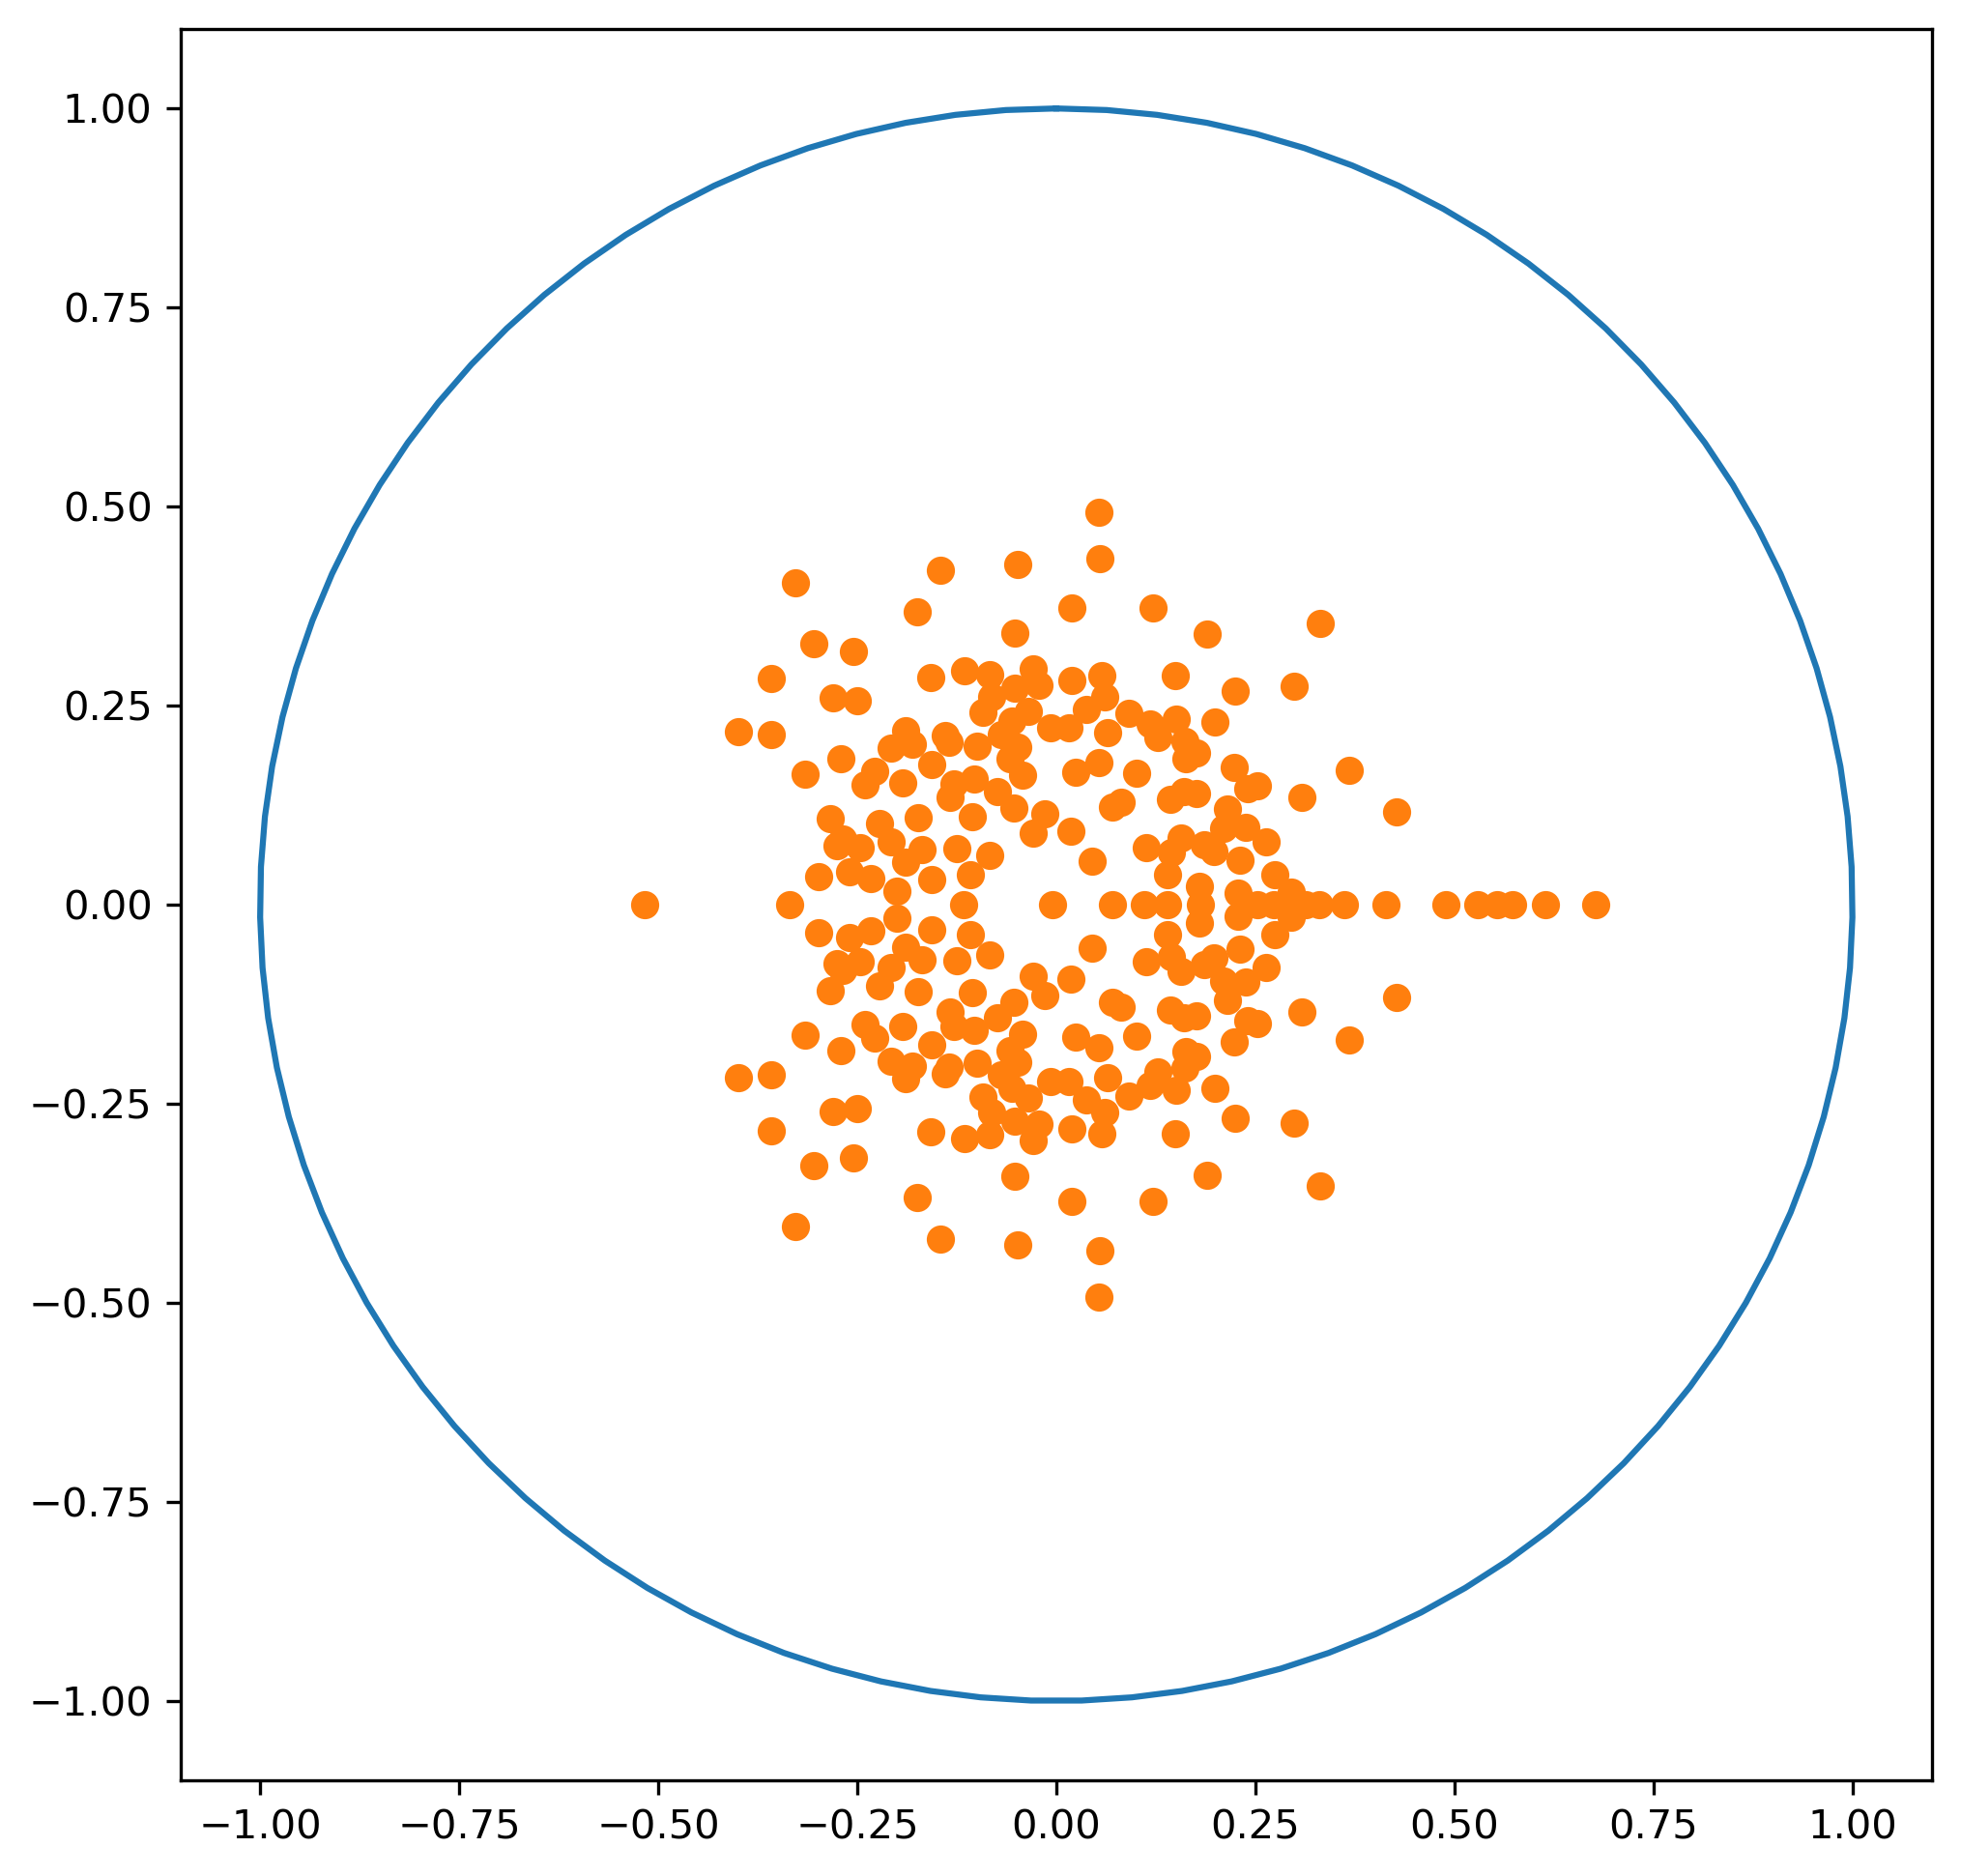

In [23]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle)
plt.plot(*spectrum, "o")
plt.show()

## Variational Circuit

In [19]:
n = 3
d = 2**n

inputs_map, inputs_spam, counts_map_list =  pickle.load(open("../../data/threeQubits_variational.p", "rb"))

targets_map = counts_to_probs(counts_map_list[:1000-6**n])
targets_spam = counts_to_probs(counts_map_list[1000-6**n:])

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

U = circuit_to_matrix(variational_circuit(3, 1))

spam_model = SPAM(d=d,
                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                    num_iter = 300,
                    )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                )

#train kraus model
kraus_model = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = d**2,
                       spam = spam_model,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model.train(inputs = inputs_map,
            targets = targets_map,
            num_iter = 2000,
            )

  0%|          | 0/300 [00:00<?, ?it/s]

0 0.030391649748237826
1 0.030193833652057585
2 0.029996690673449143
3 0.029800183213352042
4 0.029603993674795517
5 0.02940760452609381
6 0.02921080470535551
7 0.029013345489847117
8 0.028814450633711963
9 0.02861423875912336
10 0.02841222559325119
11 0.028208941305226182
12 0.028003511803211673
13 0.02779574016944402
14 0.02758491895993849
15 0.027370452716990873
16 0.02715227312040516
17 0.02693054386670901
18 0.026705158245408568
19 0.02647607269906143
20 0.02624227207417007
21 0.026004272516189086
22 0.0257620268850745
23 0.02551609857298217
24 0.02526612010890219
25 0.02501196569627355
26 0.024753264530415525
27 0.02448937734851511
28 0.02422089414116265
29 0.02394817503440442
30 0.023671911402174475
31 0.023390966095249897
32 0.023105527469317585
33 0.022815617339747723
34 0.022520851113807017
35 0.022222548569472183
36 0.02191723044371114
37 0.021611434981832343
38 0.02130307135441962
39 0.020989723513829377
40 0.020672844351233923
41 0.020353444041446372
42 0.02002979106326109

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.00845258542245376
1 0.005998441397284869
2 0.0037036137798306
3 0.0035039620333344726
4 0.003979088684016714
5 0.004219762717840188
6 0.004038467037635095
7 0.003738995115796063
8 0.003266151207221905
9 0.0028560434939739416
10 0.00262441533200072
11 0.0025224409162843873
12 0.0025153326533883273
13 0.0024982074807031883
14 0.0025052816781296677
15 0.0025126972008069183
16 0.002500924203783533
17 0.0024424328082029885
18 0.0023866943807617637
19 0.0023265374760071365
20 0.0022565792263582155
21 0.0022016326469336527
22 0.0021579036382075806
23 0.002140941625167771
24 0.002117918730093423
25 0.0021092070007014984
26 0.002094196624171166
27 0.002063044934895373
28 0.0020219097375148904
29 0.0019899156118923893
30 0.001985999074431602
31 0.0019953828664459115
32 0.0019844150592194594
33 0.0019599379511284977
34 0.0019488336870543683
35 0.001936858694646988
36 0.0019346661127983339
37 0.001931910460850708
38 0.0019280377755885767
39 0.0019154563592900025
40 0.0018988853363175993
41 0.0

325 0.0017292944380514457
326 0.0017325095177506368
327 0.0017318216534899173
328 0.001730433282192699
329 0.0017309161905874734
330 0.0017289636750850187
331 0.0017298887512847414
332 0.0017317029754684253
333 0.001729417823879172
334 0.001729290050746933
335 0.0017278232265000803
336 0.001729358100264618
337 0.0017309174951544942
338 0.0017289621396892833
339 0.0017277843719590343
340 0.0017306426856664022
341 0.0017317090046911454
342 0.0017286633349213485
343 0.0017278758284007226
344 0.0017301402827204816
345 0.0017308837087521608
346 0.001728392170959482
347 0.0017280099423620976
348 0.0017291667331895662
349 0.001731587181380014
350 0.0017299513589483283
351 0.00172864633084589
352 0.0017296983884455646
353 0.0017295248445353287
354 0.0017272234022673567
355 0.001729041776005237
356 0.0017316217274311525
357 0.0017286807801632667
358 0.0017288832618913882
359 0.0017305163265620782
360 0.0017311328373869202
361 0.0017302403045916217
362 0.0017266396691854704
363 0.001727365174632

652 0.0017182141708026535
653 0.001720941970589365
654 0.00172041089146682
655 0.0017191756556289156
656 0.0017188838082279967
657 0.0017202520937392044
658 0.0017196274529074857
659 0.0017178328371109987
660 0.0017180272683387867
661 0.0017186386947841904
662 0.001719295614933891
663 0.0017193295374884098
664 0.0017173843835213934
665 0.0017192926594029041
666 0.0017200648354293334
667 0.001718324821159778
668 0.001718913904894108
669 0.0017202047762690123
670 0.0017199287700102287
671 0.0017194636642992854
672 0.0017180862045251323
673 0.0017175180884545509
674 0.0017189555607841
675 0.0017160536108306176
676 0.001717161877724077
677 0.0017176417042112715
678 0.0017169754110258411
679 0.0017176280858608405
680 0.0017194582604919946
681 0.0017175442471898826
682 0.0017178249052730245
683 0.0017182356114698765
684 0.0017180492247973866
685 0.0017169421285251221
686 0.0017202474815579622
687 0.001719770765146984
688 0.0017193741862610182
689 0.0017187048328108161
690 0.00171824907000815

972 0.0018852584568894238
973 0.0018758883453281231
974 0.0019223739648949463
975 0.0019567094913764786
976 0.002003000220820911
977 0.0019724219249038937
978 0.0019889842129517145
979 0.0020704783077363374
980 0.0021888528928620133
981 0.0022264565803690687
982 0.0021741801882674745
983 0.002253875656915041
984 0.0023426467395515366
985 0.0026142392926460697
986 0.0027082581933986854
987 0.002604129966882563
988 0.0023266126587494352
989 0.002156576152248361
990 0.002340032179024873
991 0.0026655842443956833
992 0.0028593237027571116
993 0.002608700364373453
994 0.002328117071613703
995 0.002149860335053676
996 0.001993113900985682
997 0.002081776773633292
998 0.002284042813725289
999 0.002388012327400883


  0%|          | 0/2000 [00:00<?, ?it/s]

Step:0, train: 0.63929, val: 0.00000
Step:1, train: 0.63393, val: 0.00000
Step:2, train: 0.62858, val: 0.00000
Step:3, train: 0.62324, val: 0.00000
Step:4, train: 0.61790, val: 0.00000
Step:5, train: 0.61256, val: 0.00000
Step:6, train: 0.60723, val: 0.00000
Step:7, train: 0.60191, val: 0.00000
Step:8, train: 0.59659, val: 0.00000
Step:9, train: 0.59128, val: 0.00000
Step:10, train: 0.58599, val: 0.00000
Step:11, train: 0.58070, val: 0.00000
Step:12, train: 0.57542, val: 0.00000
Step:13, train: 0.57015, val: 0.00000
Step:14, train: 0.56490, val: 0.00000
Step:15, train: 0.55965, val: 0.00000
Step:16, train: 0.55441, val: 0.00000
Step:17, train: 0.54918, val: 0.00000
Step:18, train: 0.54396, val: 0.00000
Step:19, train: 0.53875, val: 0.00000
Step:20, train: 0.53355, val: 0.00000
Step:21, train: 0.52835, val: 0.00000
Step:22, train: 0.52316, val: 0.00000
Step:23, train: 0.51797, val: 0.00000
Step:24, train: 0.51280, val: 0.00000
Step:25, train: 0.50763, val: 0.00000
Step:26, train: 0.5024

Step:214, train: 0.01185, val: 0.00000
Step:215, train: 0.01168, val: 0.00000
Step:216, train: 0.01152, val: 0.00000
Step:217, train: 0.01136, val: 0.00000
Step:218, train: 0.01120, val: 0.00000
Step:219, train: 0.01105, val: 0.00000
Step:220, train: 0.01091, val: 0.00000
Step:221, train: 0.01076, val: 0.00000
Step:222, train: 0.01062, val: 0.00000
Step:223, train: 0.01048, val: 0.00000
Step:224, train: 0.01034, val: 0.00000
Step:225, train: 0.01021, val: 0.00000
Step:226, train: 0.01008, val: 0.00000
Step:227, train: 0.00996, val: 0.00000
Step:228, train: 0.00983, val: 0.00000
Step:229, train: 0.00971, val: 0.00000
Step:230, train: 0.00959, val: 0.00000
Step:231, train: 0.00947, val: 0.00000
Step:232, train: 0.00936, val: 0.00000
Step:233, train: 0.00925, val: 0.00000
Step:234, train: 0.00914, val: 0.00000
Step:235, train: 0.00903, val: 0.00000
Step:236, train: 0.00893, val: 0.00000
Step:237, train: 0.00882, val: 0.00000
Step:238, train: 0.00872, val: 0.00000
Step:239, train: 0.00862,

Step:426, train: 0.00309, val: 0.00000
Step:427, train: 0.00308, val: 0.00000
Step:428, train: 0.00307, val: 0.00000
Step:429, train: 0.00307, val: 0.00000
Step:430, train: 0.00306, val: 0.00000
Step:431, train: 0.00305, val: 0.00000
Step:432, train: 0.00305, val: 0.00000
Step:433, train: 0.00304, val: 0.00000
Step:434, train: 0.00304, val: 0.00000
Step:435, train: 0.00303, val: 0.00000
Step:436, train: 0.00302, val: 0.00000
Step:437, train: 0.00302, val: 0.00000
Step:438, train: 0.00301, val: 0.00000
Step:439, train: 0.00300, val: 0.00000
Step:440, train: 0.00300, val: 0.00000
Step:441, train: 0.00299, val: 0.00000
Step:442, train: 0.00299, val: 0.00000
Step:443, train: 0.00298, val: 0.00000
Step:444, train: 0.00298, val: 0.00000
Step:445, train: 0.00297, val: 0.00000
Step:446, train: 0.00296, val: 0.00000
Step:447, train: 0.00296, val: 0.00000
Step:448, train: 0.00295, val: 0.00000
Step:449, train: 0.00295, val: 0.00000
Step:450, train: 0.00294, val: 0.00000
Step:451, train: 0.00294,

Step:638, train: 0.00241, val: 0.00000
Step:639, train: 0.00241, val: 0.00000
Step:640, train: 0.00241, val: 0.00000
Step:641, train: 0.00241, val: 0.00000
Step:642, train: 0.00241, val: 0.00000
Step:643, train: 0.00241, val: 0.00000
Step:644, train: 0.00240, val: 0.00000
Step:645, train: 0.00240, val: 0.00000
Step:646, train: 0.00240, val: 0.00000
Step:647, train: 0.00240, val: 0.00000
Step:648, train: 0.00240, val: 0.00000
Step:649, train: 0.00240, val: 0.00000
Step:650, train: 0.00240, val: 0.00000
Step:651, train: 0.00239, val: 0.00000
Step:652, train: 0.00239, val: 0.00000
Step:653, train: 0.00239, val: 0.00000
Step:654, train: 0.00239, val: 0.00000
Step:655, train: 0.00239, val: 0.00000
Step:656, train: 0.00239, val: 0.00000
Step:657, train: 0.00239, val: 0.00000
Step:658, train: 0.00239, val: 0.00000
Step:659, train: 0.00238, val: 0.00000
Step:660, train: 0.00238, val: 0.00000
Step:661, train: 0.00238, val: 0.00000
Step:662, train: 0.00238, val: 0.00000
Step:663, train: 0.00238,

Step:850, train: 0.00222, val: 0.00000
Step:851, train: 0.00222, val: 0.00000
Step:852, train: 0.00222, val: 0.00000
Step:853, train: 0.00222, val: 0.00000
Step:854, train: 0.00222, val: 0.00000
Step:855, train: 0.00222, val: 0.00000
Step:856, train: 0.00222, val: 0.00000
Step:857, train: 0.00222, val: 0.00000
Step:858, train: 0.00222, val: 0.00000
Step:859, train: 0.00222, val: 0.00000
Step:860, train: 0.00222, val: 0.00000
Step:861, train: 0.00222, val: 0.00000
Step:862, train: 0.00222, val: 0.00000
Step:863, train: 0.00222, val: 0.00000
Step:864, train: 0.00222, val: 0.00000
Step:865, train: 0.00222, val: 0.00000
Step:866, train: 0.00222, val: 0.00000
Step:867, train: 0.00222, val: 0.00000
Step:868, train: 0.00221, val: 0.00000
Step:869, train: 0.00221, val: 0.00000
Step:870, train: 0.00221, val: 0.00000
Step:871, train: 0.00221, val: 0.00000
Step:872, train: 0.00221, val: 0.00000
Step:873, train: 0.00221, val: 0.00000
Step:874, train: 0.00221, val: 0.00000
Step:875, train: 0.00221,

Step:1061, train: 0.00214, val: 0.00000
Step:1062, train: 0.00214, val: 0.00000
Step:1063, train: 0.00214, val: 0.00000
Step:1064, train: 0.00214, val: 0.00000
Step:1065, train: 0.00214, val: 0.00000
Step:1066, train: 0.00214, val: 0.00000
Step:1067, train: 0.00214, val: 0.00000
Step:1068, train: 0.00214, val: 0.00000
Step:1069, train: 0.00214, val: 0.00000
Step:1070, train: 0.00214, val: 0.00000
Step:1071, train: 0.00214, val: 0.00000
Step:1072, train: 0.00214, val: 0.00000
Step:1073, train: 0.00214, val: 0.00000
Step:1074, train: 0.00214, val: 0.00000
Step:1075, train: 0.00214, val: 0.00000
Step:1076, train: 0.00214, val: 0.00000
Step:1077, train: 0.00214, val: 0.00000
Step:1078, train: 0.00214, val: 0.00000
Step:1079, train: 0.00214, val: 0.00000
Step:1080, train: 0.00214, val: 0.00000
Step:1081, train: 0.00214, val: 0.00000
Step:1082, train: 0.00213, val: 0.00000
Step:1083, train: 0.00213, val: 0.00000
Step:1084, train: 0.00213, val: 0.00000
Step:1085, train: 0.00213, val: 0.00000


Step:1267, train: 0.00210, val: 0.00000
Step:1268, train: 0.00210, val: 0.00000
Step:1269, train: 0.00210, val: 0.00000
Step:1270, train: 0.00210, val: 0.00000
Step:1271, train: 0.00210, val: 0.00000
Step:1272, train: 0.00210, val: 0.00000
Step:1273, train: 0.00209, val: 0.00000
Step:1274, train: 0.00209, val: 0.00000
Step:1275, train: 0.00209, val: 0.00000
Step:1276, train: 0.00209, val: 0.00000
Step:1277, train: 0.00209, val: 0.00000
Step:1278, train: 0.00209, val: 0.00000
Step:1279, train: 0.00209, val: 0.00000
Step:1280, train: 0.00209, val: 0.00000
Step:1281, train: 0.00209, val: 0.00000
Step:1282, train: 0.00209, val: 0.00000
Step:1283, train: 0.00209, val: 0.00000
Step:1284, train: 0.00209, val: 0.00000
Step:1285, train: 0.00209, val: 0.00000
Step:1286, train: 0.00209, val: 0.00000
Step:1287, train: 0.00209, val: 0.00000
Step:1288, train: 0.00209, val: 0.00000
Step:1289, train: 0.00209, val: 0.00000
Step:1290, train: 0.00209, val: 0.00000
Step:1291, train: 0.00209, val: 0.00000


Step:1472, train: 0.00207, val: 0.00000
Step:1473, train: 0.00207, val: 0.00000
Step:1474, train: 0.00207, val: 0.00000
Step:1475, train: 0.00207, val: 0.00000
Step:1476, train: 0.00207, val: 0.00000
Step:1477, train: 0.00207, val: 0.00000
Step:1478, train: 0.00207, val: 0.00000
Step:1479, train: 0.00207, val: 0.00000
Step:1480, train: 0.00207, val: 0.00000
Step:1481, train: 0.00207, val: 0.00000
Step:1482, train: 0.00207, val: 0.00000
Step:1483, train: 0.00207, val: 0.00000
Step:1484, train: 0.00207, val: 0.00000
Step:1485, train: 0.00207, val: 0.00000
Step:1486, train: 0.00207, val: 0.00000
Step:1487, train: 0.00207, val: 0.00000
Step:1488, train: 0.00207, val: 0.00000
Step:1489, train: 0.00207, val: 0.00000
Step:1490, train: 0.00207, val: 0.00000
Step:1491, train: 0.00207, val: 0.00000
Step:1492, train: 0.00207, val: 0.00000
Step:1493, train: 0.00207, val: 0.00000
Step:1494, train: 0.00207, val: 0.00000
Step:1495, train: 0.00207, val: 0.00000
Step:1496, train: 0.00207, val: 0.00000


Step:1677, train: 0.00205, val: 0.00000
Step:1678, train: 0.00205, val: 0.00000
Step:1679, train: 0.00205, val: 0.00000
Step:1680, train: 0.00205, val: 0.00000
Step:1681, train: 0.00205, val: 0.00000
Step:1682, train: 0.00205, val: 0.00000
Step:1683, train: 0.00205, val: 0.00000
Step:1684, train: 0.00205, val: 0.00000
Step:1685, train: 0.00205, val: 0.00000
Step:1686, train: 0.00205, val: 0.00000
Step:1687, train: 0.00205, val: 0.00000
Step:1688, train: 0.00205, val: 0.00000
Step:1689, train: 0.00205, val: 0.00000
Step:1690, train: 0.00205, val: 0.00000
Step:1691, train: 0.00205, val: 0.00000
Step:1692, train: 0.00205, val: 0.00000
Step:1693, train: 0.00205, val: 0.00000
Step:1694, train: 0.00205, val: 0.00000
Step:1695, train: 0.00205, val: 0.00000
Step:1696, train: 0.00205, val: 0.00000
Step:1697, train: 0.00205, val: 0.00000
Step:1698, train: 0.00205, val: 0.00000
Step:1699, train: 0.00205, val: 0.00000
Step:1700, train: 0.00205, val: 0.00000
Step:1701, train: 0.00205, val: 0.00000


Step:1884, train: 0.00204, val: 0.00000
Step:1885, train: 0.00204, val: 0.00000
Step:1886, train: 0.00204, val: 0.00000
Step:1887, train: 0.00204, val: 0.00000
Step:1888, train: 0.00204, val: 0.00000
Step:1889, train: 0.00204, val: 0.00000
Step:1890, train: 0.00204, val: 0.00000
Step:1891, train: 0.00204, val: 0.00000
Step:1892, train: 0.00204, val: 0.00000
Step:1893, train: 0.00204, val: 0.00000
Step:1894, train: 0.00204, val: 0.00000
Step:1895, train: 0.00204, val: 0.00000
Step:1896, train: 0.00204, val: 0.00000
Step:1897, train: 0.00204, val: 0.00000
Step:1898, train: 0.00204, val: 0.00000
Step:1899, train: 0.00204, val: 0.00000
Step:1900, train: 0.00204, val: 0.00000
Step:1901, train: 0.00204, val: 0.00000
Step:1902, train: 0.00204, val: 0.00000
Step:1903, train: 0.00204, val: 0.00000
Step:1904, train: 0.00204, val: 0.00000
Step:1905, train: 0.00204, val: 0.00000
Step:1906, train: 0.00204, val: 0.00000
Step:1907, train: 0.00204, val: 0.00000
Step:1908, train: 0.00204, val: 0.00000


None


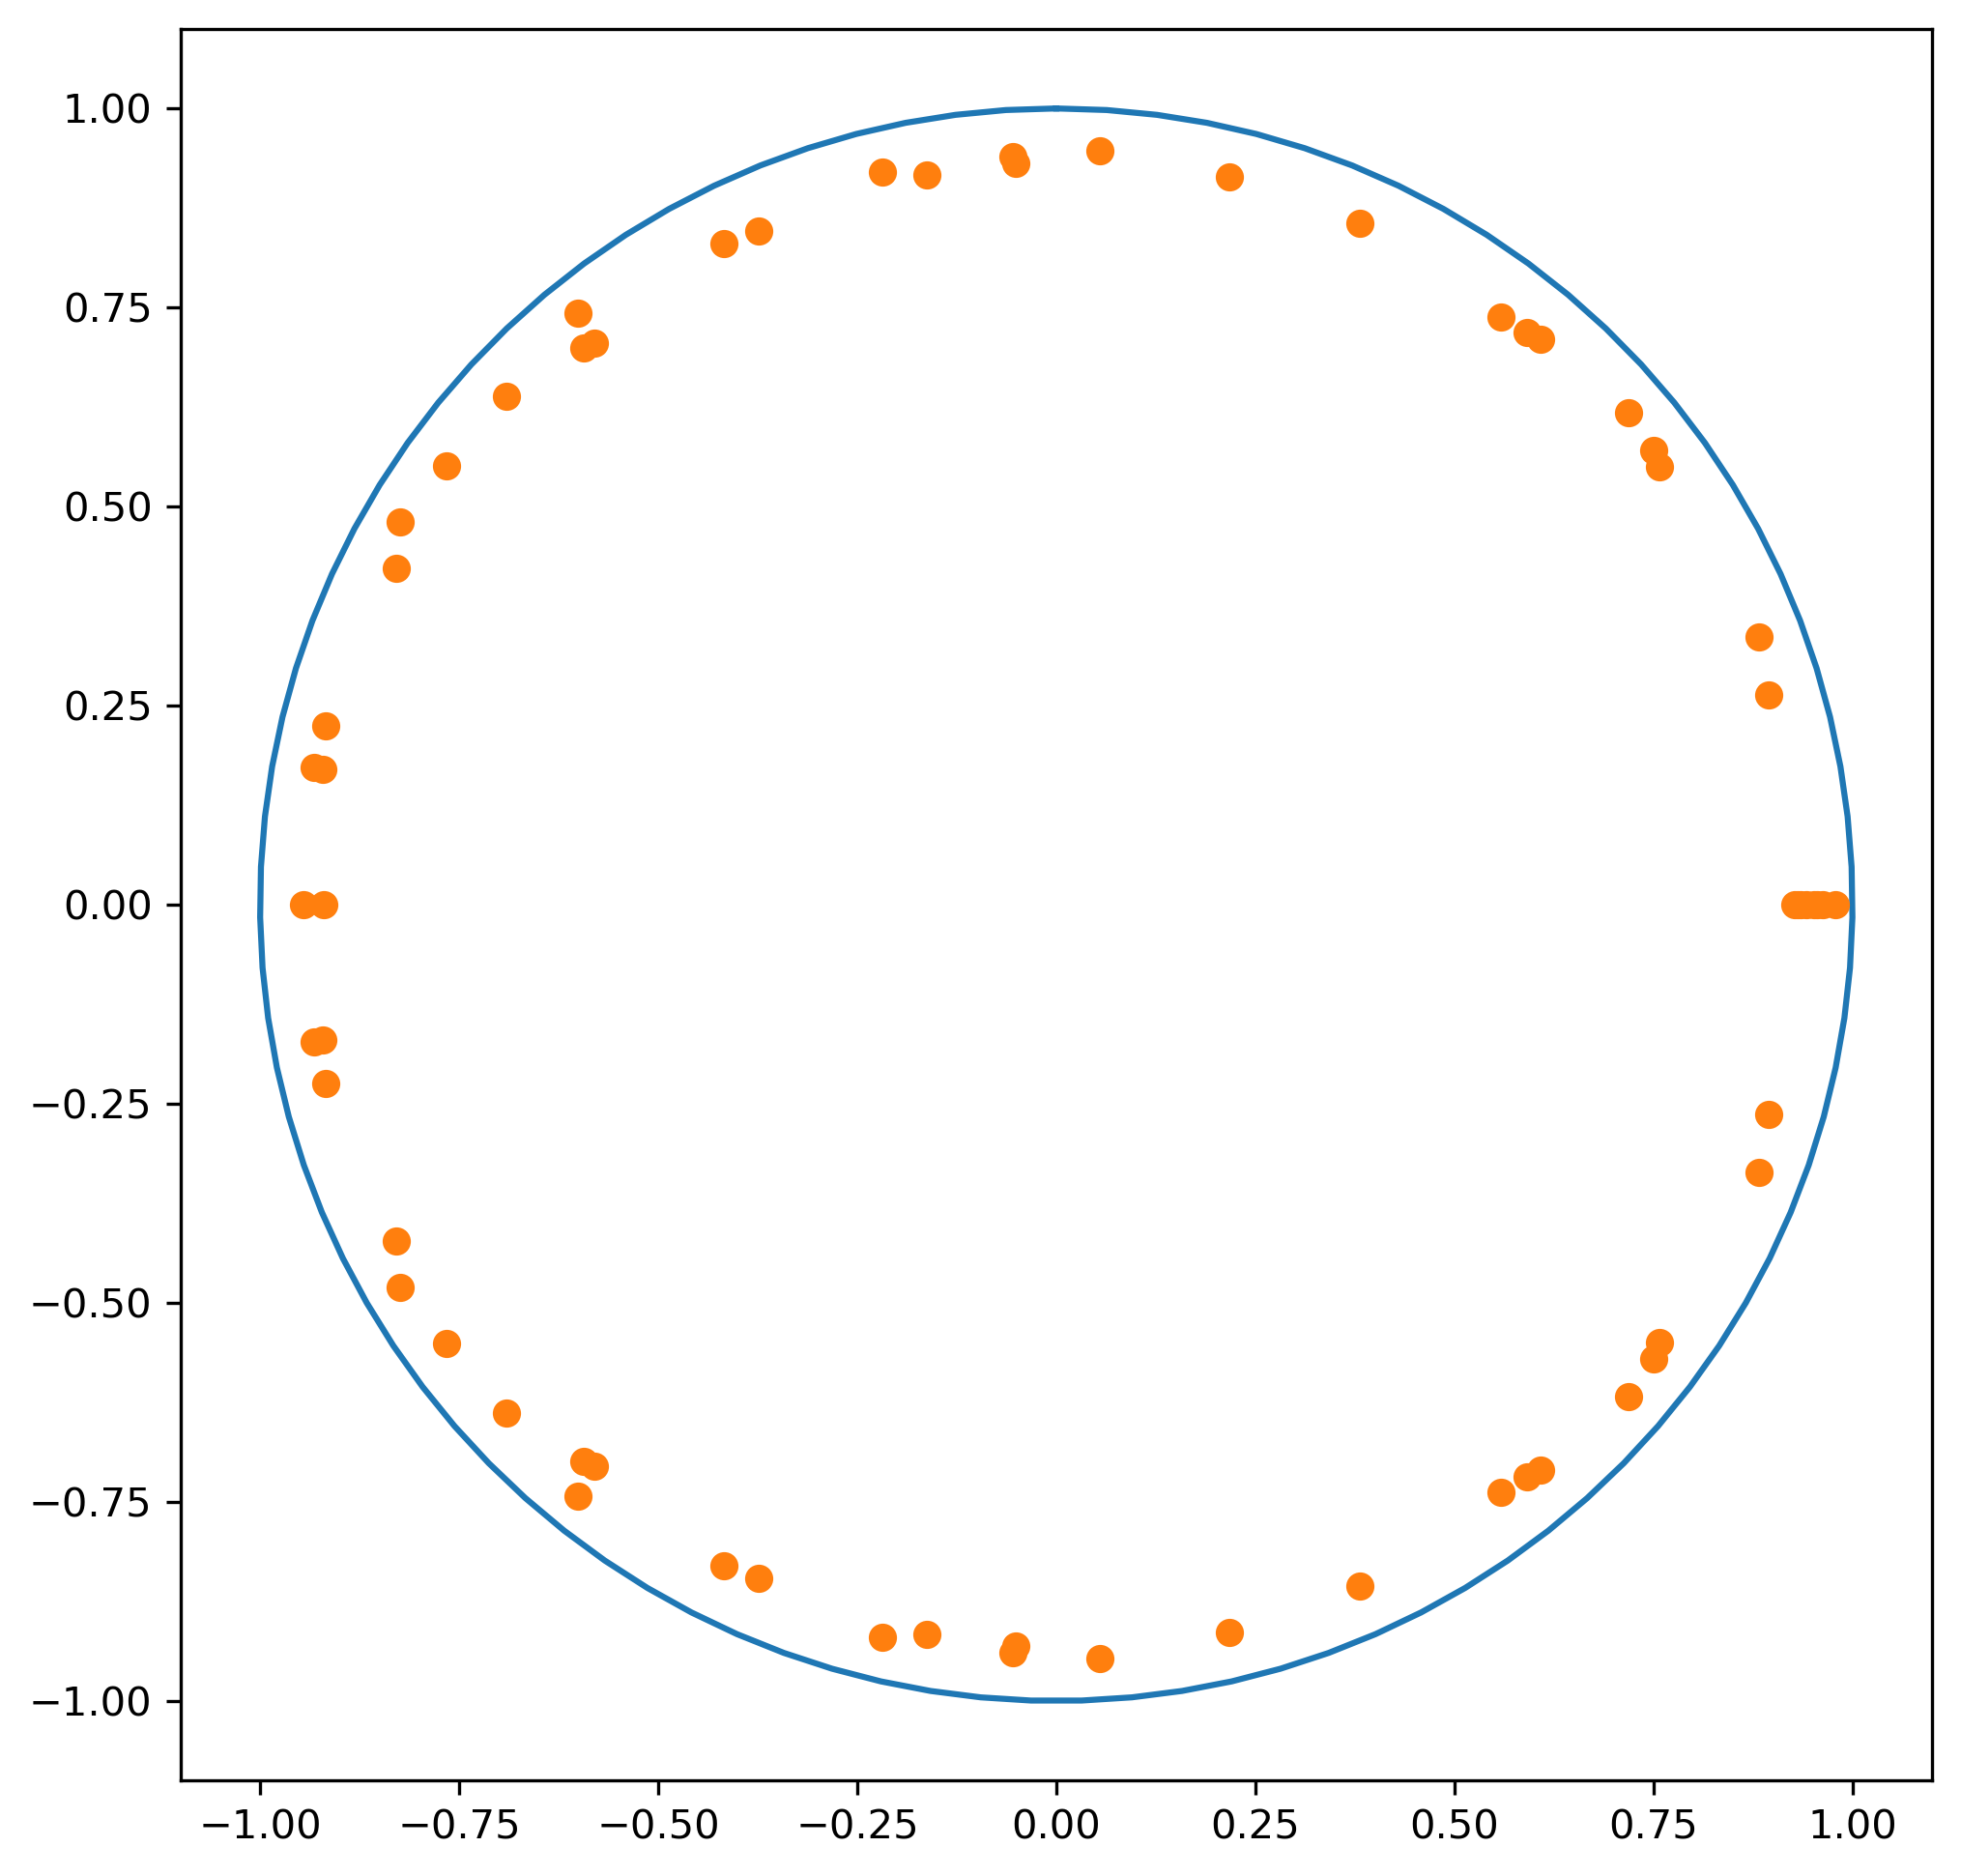

In [20]:
print(kraus_model.c)
choi = kraus_to_choi(kraus_model)
spectrum = choi_spectrum(choi)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle)
plt.plot(*spectrum, "o")
plt.show()

In [21]:
n = 3
d = 2**n

inputs_map, inputs_spam, counts_map_list =  pickle.load(open("../../data/threeQubits_variational_2.p", "rb"))

targets_map = counts_to_probs(counts_map_list[:1000-6**n])
targets_spam = counts_to_probs(counts_map_list[1000-6**n:])

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

U = circuit_to_matrix(variational_circuit(3, 2))

spam_model = SPAM(d=d,
                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                    num_iter = 300,
                    )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                )

#train kraus model
kraus_model = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = d**2,
                       spam = spam_model,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model.train(inputs = inputs_map,
            targets = targets_map,
            num_iter = 2000,
            )


  0%|          | 0/300 [00:00<?, ?it/s]

0 0.030391649748237826
1 0.030193833652057585
2 0.029996690673449143
3 0.029800183213352042
4 0.029603993674795517
5 0.02940760452609381
6 0.02921080470535551
7 0.029013345489847117
8 0.028814450633711963
9 0.02861423875912336
10 0.02841222559325119
11 0.028208941305226182
12 0.028003511803211673
13 0.02779574016944402
14 0.02758491895993849
15 0.027370452716990873
16 0.02715227312040516
17 0.02693054386670901
18 0.026705158245408568
19 0.02647607269906143
20 0.02624227207417007
21 0.026004272516189086
22 0.0257620268850745
23 0.02551609857298217
24 0.02526612010890219
25 0.02501196569627355
26 0.024753264530415525
27 0.02448937734851511
28 0.02422089414116265
29 0.02394817503440442
30 0.023671911402174475
31 0.023390966095249897
32 0.023105527469317585
33 0.022815617339747723
34 0.022520851113807017
35 0.022222548569472183
36 0.02191723044371114
37 0.021611434981832343
38 0.02130307135441962
39 0.020989723513829377
40 0.020672844351233923
41 0.020353444041446372
42 0.02002979106326109

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.008017024502767766
1 0.004787812241911462
2 0.0032118422891808606
3 0.0032820515590799787
4 0.003355839066064355
5 0.0032028893460360475
6 0.0028426769717293378
7 0.0025042851884847822
8 0.0021384163152248833
9 0.0018964350369145423
10 0.001677151883297708
11 0.0015184031783355202
12 0.0014305902745078531
13 0.0014233792960243843
14 0.001440093728645864
15 0.0014121473881350782
16 0.001364538551060622
17 0.0013219815721273829
18 0.0012821758978168718
19 0.0012361364589584627
20 0.0011874541142520062
21 0.0011334970816278672
22 0.001090756738059413
23 0.0010602803571796516
24 0.0010375584900060584
25 0.001017977139691469
26 0.0009888506872952414
27 0.0009603182964535015
28 0.0009325605003851651
29 0.0009129281396512817
30 0.000898427965437785
31 0.0008785913338736838
32 0.000864142042754182
33 0.0008524229925656967
34 0.0008442340941515582
35 0.0008377554082175451
36 0.0008357711299433537
37 0.0008270641715512761
38 0.000814149759832813
39 0.0008093609681463776
40 0.0008034223887221

324 0.000608851573073696
325 0.0006079871326971609
326 0.000609103669403284
327 0.0006080258010598002
328 0.0006103187162028875
329 0.000607677984006304
330 0.0006079483160164595
331 0.0006095542932010666
332 0.000609495446406459
333 0.0006090176348476359
334 0.0006088202122234806
335 0.000608547310706011
336 0.0006081063449413422
337 0.000608072690830056
338 0.0006077414459096266
339 0.0006069248899247753
340 0.0006076561016495641
341 0.0006070131214782714
342 0.0006069773613942733
343 0.0006069646495424991
344 0.0006067417631564245
345 0.0006065048355617804
346 0.000606351422277431
347 0.0006061263224020536
348 0.0006067955109253205
349 0.0006064211221829526
350 0.0006063946031013798
351 0.0006062351899232828
352 0.0006062872537373677
353 0.0006064518621598819
354 0.0006065755165094507
355 0.0006070559996657074
356 0.0006063988878029198
357 0.0006063322491485528
358 0.0006065561249809384
359 0.0006061865065388356
360 0.0006075263097715126
361 0.0006076901832631644
362 0.0006072740251

647 0.0006036539471689133
648 0.0006037171322387186
649 0.0006036139812033485
650 0.000602711369057641
651 0.0006022792865234181
652 0.0006039348328684398
653 0.0006036430794371584
654 0.0006032522943853467
655 0.0006029942529692153
656 0.0006030980847084657
657 0.0006042201726338954
658 0.000602847773880584
659 0.000602350837207609
660 0.0006032511834423527
661 0.000602940430504073
662 0.0006029420049481482
663 0.0006043114628743281
664 0.0006028553786016502
665 0.0006038961359336206
666 0.0006037130212935975
667 0.0006028950112561855
668 0.0006031675033512407
669 0.0006037401726798679
670 0.0006041669858191135
671 0.000604184185669704
672 0.0006040326555688349
673 0.0006037359086558639
674 0.0006047563790045084
675 0.000604566247397514
676 0.00060313445486979
677 0.0006049529508411609
678 0.000604333802013101
679 0.0006039637906932381
680 0.0006036462386870754
681 0.0006028154819060479
682 0.000603509411319849
683 0.0006038674022277265
684 0.0006031554209379691
685 0.0006045858598415

970 0.0006033525335324184
971 0.0006044622232618435
972 0.0006048773908127707
973 0.00060413034611709
974 0.000604149012729606
975 0.0006048629202979285
976 0.000604623441985196
977 0.0006043265942818328
978 0.0006045751993056643
979 0.0006036200795114745
980 0.000604326749843099
981 0.0006047353800692365
982 0.0006054161404341979
983 0.0006045794824831097
984 0.0006043992535633807
985 0.000605703674742761
986 0.0006052288521120936
987 0.0006057520351220965
988 0.0006048640524077733
989 0.0006043776661262558
990 0.0006058023126942127
991 0.0006053719652392768
992 0.0006046891100294591
993 0.0006042545525051815
994 0.0006043152492349352
995 0.0006043539563845923
996 0.0006040660653111036
997 0.0006051826898073002
998 0.0006058765929346913
999 0.0006045752797147508


  0%|          | 0/2000 [00:00<?, ?it/s]

Step:0, train: 0.69398, val: 0.00000
Step:1, train: 0.68772, val: 0.00000
Step:2, train: 0.68145, val: 0.00000
Step:3, train: 0.67518, val: 0.00000
Step:4, train: 0.66891, val: 0.00000
Step:5, train: 0.66263, val: 0.00000
Step:6, train: 0.65635, val: 0.00000
Step:7, train: 0.65008, val: 0.00000
Step:8, train: 0.64381, val: 0.00000
Step:9, train: 0.63754, val: 0.00000
Step:10, train: 0.63127, val: 0.00000
Step:11, train: 0.62502, val: 0.00000
Step:12, train: 0.61877, val: 0.00000
Step:13, train: 0.61253, val: 0.00000
Step:14, train: 0.60630, val: 0.00000
Step:15, train: 0.60008, val: 0.00000
Step:16, train: 0.59387, val: 0.00000
Step:17, train: 0.58768, val: 0.00000
Step:18, train: 0.58149, val: 0.00000
Step:19, train: 0.57531, val: 0.00000
Step:20, train: 0.56915, val: 0.00000
Step:21, train: 0.56300, val: 0.00000
Step:22, train: 0.55687, val: 0.00000
Step:23, train: 0.55074, val: 0.00000
Step:24, train: 0.54463, val: 0.00000
Step:25, train: 0.53853, val: 0.00000
Step:26, train: 0.5324

Step:214, train: 0.01389, val: 0.00000
Step:215, train: 0.01369, val: 0.00000
Step:216, train: 0.01349, val: 0.00000
Step:217, train: 0.01330, val: 0.00000
Step:218, train: 0.01311, val: 0.00000
Step:219, train: 0.01293, val: 0.00000
Step:220, train: 0.01275, val: 0.00000
Step:221, train: 0.01257, val: 0.00000
Step:222, train: 0.01240, val: 0.00000
Step:223, train: 0.01223, val: 0.00000
Step:224, train: 0.01206, val: 0.00000
Step:225, train: 0.01190, val: 0.00000
Step:226, train: 0.01174, val: 0.00000
Step:227, train: 0.01159, val: 0.00000
Step:228, train: 0.01144, val: 0.00000
Step:229, train: 0.01129, val: 0.00000
Step:230, train: 0.01115, val: 0.00000
Step:231, train: 0.01100, val: 0.00000
Step:232, train: 0.01087, val: 0.00000
Step:233, train: 0.01073, val: 0.00000
Step:234, train: 0.01060, val: 0.00000
Step:235, train: 0.01047, val: 0.00000
Step:236, train: 0.01034, val: 0.00000
Step:237, train: 0.01021, val: 0.00000
Step:238, train: 0.01009, val: 0.00000
Step:239, train: 0.00997,

Step:425, train: 0.00351, val: 0.00000
Step:426, train: 0.00351, val: 0.00000
Step:427, train: 0.00350, val: 0.00000
Step:428, train: 0.00349, val: 0.00000
Step:429, train: 0.00348, val: 0.00000
Step:430, train: 0.00348, val: 0.00000
Step:431, train: 0.00347, val: 0.00000
Step:432, train: 0.00346, val: 0.00000
Step:433, train: 0.00346, val: 0.00000
Step:434, train: 0.00345, val: 0.00000
Step:435, train: 0.00344, val: 0.00000
Step:436, train: 0.00344, val: 0.00000
Step:437, train: 0.00343, val: 0.00000
Step:438, train: 0.00342, val: 0.00000
Step:439, train: 0.00342, val: 0.00000
Step:440, train: 0.00341, val: 0.00000
Step:441, train: 0.00340, val: 0.00000
Step:442, train: 0.00340, val: 0.00000
Step:443, train: 0.00339, val: 0.00000
Step:444, train: 0.00339, val: 0.00000
Step:445, train: 0.00338, val: 0.00000
Step:446, train: 0.00337, val: 0.00000
Step:447, train: 0.00337, val: 0.00000
Step:448, train: 0.00336, val: 0.00000
Step:449, train: 0.00336, val: 0.00000
Step:450, train: 0.00335,

Step:637, train: 0.00280, val: 0.00000
Step:638, train: 0.00279, val: 0.00000
Step:639, train: 0.00279, val: 0.00000
Step:640, train: 0.00279, val: 0.00000
Step:641, train: 0.00279, val: 0.00000
Step:642, train: 0.00279, val: 0.00000
Step:643, train: 0.00279, val: 0.00000
Step:644, train: 0.00279, val: 0.00000
Step:645, train: 0.00278, val: 0.00000
Step:646, train: 0.00278, val: 0.00000
Step:647, train: 0.00278, val: 0.00000
Step:648, train: 0.00278, val: 0.00000
Step:649, train: 0.00278, val: 0.00000
Step:650, train: 0.00278, val: 0.00000
Step:651, train: 0.00278, val: 0.00000
Step:652, train: 0.00277, val: 0.00000
Step:653, train: 0.00277, val: 0.00000
Step:654, train: 0.00277, val: 0.00000
Step:655, train: 0.00277, val: 0.00000
Step:656, train: 0.00277, val: 0.00000
Step:657, train: 0.00277, val: 0.00000
Step:658, train: 0.00277, val: 0.00000
Step:659, train: 0.00276, val: 0.00000
Step:660, train: 0.00276, val: 0.00000
Step:661, train: 0.00276, val: 0.00000
Step:662, train: 0.00276,

Step:850, train: 0.00258, val: 0.00000
Step:851, train: 0.00258, val: 0.00000
Step:852, train: 0.00258, val: 0.00000
Step:853, train: 0.00258, val: 0.00000
Step:854, train: 0.00258, val: 0.00000
Step:855, train: 0.00258, val: 0.00000
Step:856, train: 0.00258, val: 0.00000
Step:857, train: 0.00258, val: 0.00000
Step:858, train: 0.00258, val: 0.00000
Step:859, train: 0.00257, val: 0.00000
Step:860, train: 0.00257, val: 0.00000
Step:861, train: 0.00257, val: 0.00000
Step:862, train: 0.00257, val: 0.00000
Step:863, train: 0.00257, val: 0.00000
Step:864, train: 0.00257, val: 0.00000
Step:865, train: 0.00257, val: 0.00000
Step:866, train: 0.00257, val: 0.00000
Step:867, train: 0.00257, val: 0.00000
Step:868, train: 0.00257, val: 0.00000
Step:869, train: 0.00257, val: 0.00000
Step:870, train: 0.00257, val: 0.00000
Step:871, train: 0.00257, val: 0.00000
Step:872, train: 0.00257, val: 0.00000
Step:873, train: 0.00257, val: 0.00000
Step:874, train: 0.00256, val: 0.00000
Step:875, train: 0.00256,

Step:1059, train: 0.00248, val: 0.00000
Step:1060, train: 0.00248, val: 0.00000
Step:1061, train: 0.00248, val: 0.00000
Step:1062, train: 0.00247, val: 0.00000
Step:1063, train: 0.00247, val: 0.00000
Step:1064, train: 0.00247, val: 0.00000
Step:1065, train: 0.00247, val: 0.00000
Step:1066, train: 0.00247, val: 0.00000
Step:1067, train: 0.00247, val: 0.00000
Step:1068, train: 0.00247, val: 0.00000
Step:1069, train: 0.00247, val: 0.00000
Step:1070, train: 0.00247, val: 0.00000
Step:1071, train: 0.00247, val: 0.00000
Step:1072, train: 0.00247, val: 0.00000
Step:1073, train: 0.00247, val: 0.00000
Step:1074, train: 0.00247, val: 0.00000
Step:1075, train: 0.00247, val: 0.00000
Step:1076, train: 0.00247, val: 0.00000
Step:1077, train: 0.00247, val: 0.00000
Step:1078, train: 0.00247, val: 0.00000
Step:1079, train: 0.00247, val: 0.00000
Step:1080, train: 0.00247, val: 0.00000
Step:1081, train: 0.00247, val: 0.00000
Step:1082, train: 0.00247, val: 0.00000
Step:1083, train: 0.00247, val: 0.00000


Step:1264, train: 0.00242, val: 0.00000
Step:1265, train: 0.00242, val: 0.00000
Step:1266, train: 0.00242, val: 0.00000
Step:1267, train: 0.00242, val: 0.00000
Step:1268, train: 0.00242, val: 0.00000
Step:1269, train: 0.00241, val: 0.00000
Step:1270, train: 0.00241, val: 0.00000
Step:1271, train: 0.00241, val: 0.00000
Step:1272, train: 0.00241, val: 0.00000
Step:1273, train: 0.00241, val: 0.00000
Step:1274, train: 0.00241, val: 0.00000
Step:1275, train: 0.00241, val: 0.00000
Step:1276, train: 0.00241, val: 0.00000
Step:1277, train: 0.00241, val: 0.00000
Step:1278, train: 0.00241, val: 0.00000
Step:1279, train: 0.00241, val: 0.00000
Step:1280, train: 0.00241, val: 0.00000
Step:1281, train: 0.00241, val: 0.00000
Step:1282, train: 0.00241, val: 0.00000
Step:1283, train: 0.00241, val: 0.00000
Step:1284, train: 0.00241, val: 0.00000
Step:1285, train: 0.00241, val: 0.00000
Step:1286, train: 0.00241, val: 0.00000
Step:1287, train: 0.00241, val: 0.00000
Step:1288, train: 0.00241, val: 0.00000


Step:1470, train: 0.00238, val: 0.00000
Step:1471, train: 0.00238, val: 0.00000
Step:1472, train: 0.00238, val: 0.00000
Step:1473, train: 0.00238, val: 0.00000
Step:1474, train: 0.00238, val: 0.00000
Step:1475, train: 0.00238, val: 0.00000
Step:1476, train: 0.00238, val: 0.00000
Step:1477, train: 0.00238, val: 0.00000
Step:1478, train: 0.00238, val: 0.00000
Step:1479, train: 0.00238, val: 0.00000
Step:1480, train: 0.00238, val: 0.00000
Step:1481, train: 0.00238, val: 0.00000
Step:1482, train: 0.00238, val: 0.00000
Step:1483, train: 0.00238, val: 0.00000
Step:1484, train: 0.00238, val: 0.00000
Step:1485, train: 0.00238, val: 0.00000
Step:1486, train: 0.00238, val: 0.00000
Step:1487, train: 0.00238, val: 0.00000
Step:1488, train: 0.00238, val: 0.00000
Step:1489, train: 0.00238, val: 0.00000
Step:1490, train: 0.00238, val: 0.00000
Step:1491, train: 0.00237, val: 0.00000
Step:1492, train: 0.00237, val: 0.00000
Step:1493, train: 0.00237, val: 0.00000
Step:1494, train: 0.00237, val: 0.00000


Step:1675, train: 0.00235, val: 0.00000
Step:1676, train: 0.00235, val: 0.00000
Step:1677, train: 0.00235, val: 0.00000
Step:1678, train: 0.00235, val: 0.00000
Step:1679, train: 0.00235, val: 0.00000
Step:1680, train: 0.00235, val: 0.00000
Step:1681, train: 0.00235, val: 0.00000
Step:1682, train: 0.00235, val: 0.00000
Step:1683, train: 0.00235, val: 0.00000
Step:1684, train: 0.00235, val: 0.00000
Step:1685, train: 0.00235, val: 0.00000
Step:1686, train: 0.00235, val: 0.00000
Step:1687, train: 0.00235, val: 0.00000
Step:1688, train: 0.00235, val: 0.00000
Step:1689, train: 0.00235, val: 0.00000
Step:1690, train: 0.00235, val: 0.00000
Step:1691, train: 0.00235, val: 0.00000
Step:1692, train: 0.00235, val: 0.00000
Step:1693, train: 0.00235, val: 0.00000
Step:1694, train: 0.00235, val: 0.00000
Step:1695, train: 0.00235, val: 0.00000
Step:1696, train: 0.00235, val: 0.00000
Step:1697, train: 0.00235, val: 0.00000
Step:1698, train: 0.00235, val: 0.00000
Step:1699, train: 0.00235, val: 0.00000


Step:1880, train: 0.00234, val: 0.00000
Step:1881, train: 0.00234, val: 0.00000
Step:1882, train: 0.00234, val: 0.00000
Step:1883, train: 0.00234, val: 0.00000
Step:1884, train: 0.00234, val: 0.00000
Step:1885, train: 0.00234, val: 0.00000
Step:1886, train: 0.00234, val: 0.00000
Step:1887, train: 0.00234, val: 0.00000
Step:1888, train: 0.00234, val: 0.00000
Step:1889, train: 0.00234, val: 0.00000
Step:1890, train: 0.00234, val: 0.00000
Step:1891, train: 0.00234, val: 0.00000
Step:1892, train: 0.00234, val: 0.00000
Step:1893, train: 0.00234, val: 0.00000
Step:1894, train: 0.00234, val: 0.00000
Step:1895, train: 0.00234, val: 0.00000
Step:1896, train: 0.00234, val: 0.00000
Step:1897, train: 0.00234, val: 0.00000
Step:1898, train: 0.00234, val: 0.00000
Step:1899, train: 0.00234, val: 0.00000
Step:1900, train: 0.00234, val: 0.00000
Step:1901, train: 0.00234, val: 0.00000
Step:1902, train: 0.00234, val: 0.00000
Step:1903, train: 0.00234, val: 0.00000
Step:1904, train: 0.00233, val: 0.00000


None


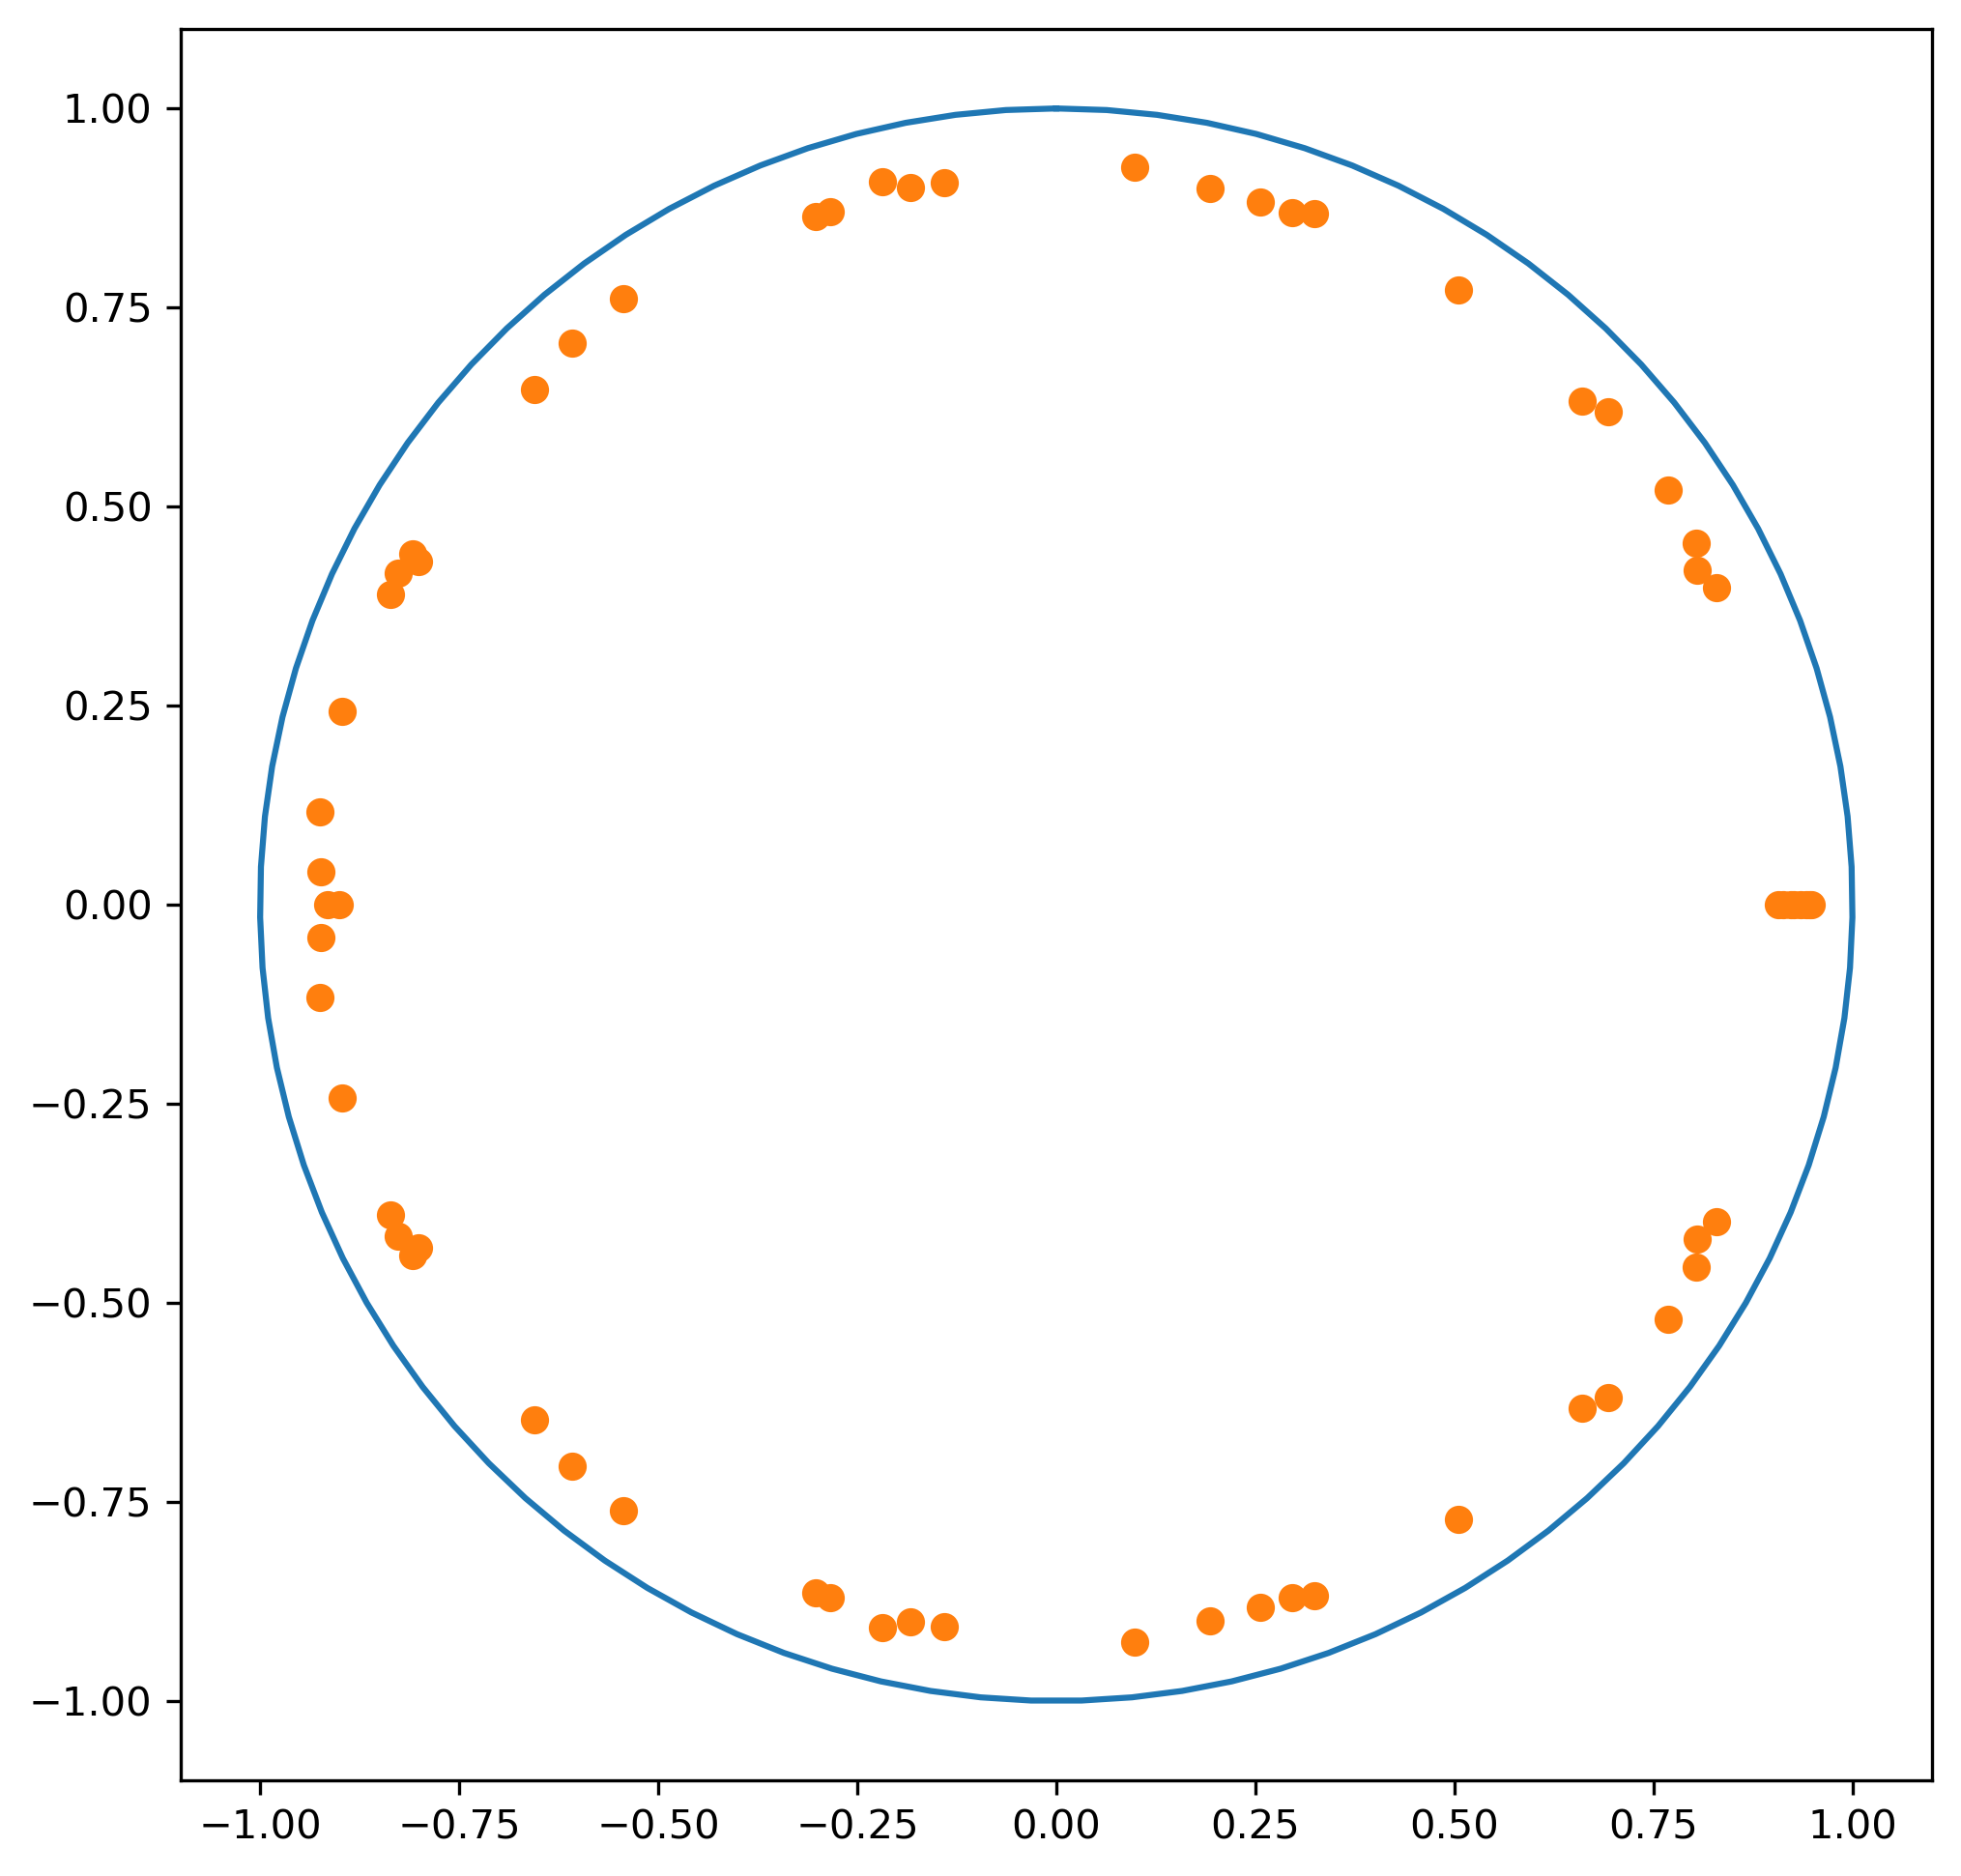

In [22]:
print(kraus_model.c)

choi = kraus_to_choi(kraus_model)
spectrum = choi_spectrum(choi)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle)
plt.plot(*spectrum, "o")
plt.show()

In [3]:
n = 3
d = 2**n

inputs_map, inputs_spam, counts_map_list =  pickle.load(open("../../data/threeQubits_variational_4.p", "rb"))

targets_map = counts_to_probs(counts_map_list[:1000-6**n])
targets_spam = counts_to_probs(counts_map_list[1000-6**n:])

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

U = circuit_to_matrix(variational_circuit(3, 2))

spam_model = SPAM(d=d,
                  use_corr_mat=True,
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                    num_iter = 300,
                    )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 1000,
                )

#train kraus model
kraus_model = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = d**2,
                       spam = spam_model,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

model.train(inputs = inputs_map,
            targets = targets_map,
            num_iter = 2000,
            )

  0%|          | 0/300 [00:00<?, ?it/s]

0 0.030391649748237826
1 0.030193833652057585
2 0.029996690673449143
3 0.029800183213352042
4 0.029603993674795517
5 0.02940760452609381
6 0.02921080470535551
7 0.029013345489847117
8 0.028814450633711963
9 0.02861423875912336
10 0.02841222559325119
11 0.028208941305226182
12 0.028003511803211673
13 0.02779574016944402
14 0.02758491895993849
15 0.027370452716990873
16 0.02715227312040516
17 0.02693054386670901
18 0.026705158245408568
19 0.02647607269906143
20 0.02624227207417007
21 0.026004272516189086
22 0.0257620268850745
23 0.02551609857298217
24 0.02526612010890219
25 0.02501196569627355
26 0.024753264530415525
27 0.02448937734851511
28 0.02422089414116265
29 0.02394817503440442
30 0.023671911402174475
31 0.023390966095249897
32 0.023105527469317585
33 0.022815617339747723
34 0.022520851113807017
35 0.022222548569472183
36 0.02191723044371114
37 0.021611434981832343
38 0.02130307135441962
39 0.020989723513829377
40 0.020672844351233923
41 0.020353444041446372
42 0.02002979106326109

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.006090157689816027
1 0.004732868455369229
2 0.0030192776074524897
3 0.0022720954813756715
4 0.0023507120572167674
5 0.0024513437204269043
6 0.002409116747727242
7 0.002128497980576047
8 0.0017924584095146802
9 0.001505856042756065
10 0.0012678782427055348
11 0.0010913889216822303
12 0.0010381945514644586
13 0.001061345312421346
14 0.001091065192718132
15 0.001102356978381303
16 0.0010968130833598484
17 0.001080659143710253
18 0.0010617746339841505
19 0.0010209324910027877
20 0.0009628966248121407
21 0.0009018628527957301
22 0.0008582184347804055
23 0.0008338574980334967
24 0.0008181937749559906
25 0.0008003088547009131
26 0.0007839972280353761
27 0.0007701237172759645
28 0.0007482705203576924
29 0.0007193327417504597
30 0.0006925485058725057
31 0.0006745341119929463
32 0.0006648268992014865
33 0.0006780146279870078
34 0.0006827887446081393
35 0.0006778345480844527
36 0.0006688774119712544
37 0.0006579988545038557
38 0.0006521037839029476
39 0.0006346847169582145
40 0.00062287736590

324 0.00044941398138169755
325 0.00044964185159371663
326 0.00044969810541414134
327 0.0004506588856004145
328 0.0004507344200317016
329 0.00045127560102859593
330 0.0004527073174112012
331 0.0004539031245026741
332 0.00045517658264455533
333 0.0004555427703369255
334 0.0004559635314933453
335 0.00045713490720979144
336 0.00045764623923479845
337 0.0004585372785208124
338 0.0004604203499689887
339 0.0004611604723990845
340 0.0004618611790391341
341 0.0004626736007111007
342 0.0004636462002187179
343 0.00046530497518610736
344 0.00046685998876482866
345 0.00046765858977103336
346 0.00046905370163312235
347 0.00047023416371112765
348 0.0004708026423147727
349 0.0004719864709435103
350 0.00047451001500008286
351 0.00046803609879144265
352 0.00047042130382603714
353 0.0004738718830693181
354 0.0004766913816052279
355 0.0004787223821223337
356 0.0004797039031726541
357 0.0004798955438527221
358 0.0004720468226901896
359 0.00046582255279656586
360 0.00046311708275133923
361 0.000470874275675

638 0.0004146254618129399
639 0.00041463570848782755
640 0.00041478687032846343
641 0.00041463215989303925
642 0.00041493104370130023
643 0.0004151205166391856
644 0.00041502173751881193
645 0.00041524914923767476
646 0.0004150509653310927
647 0.0004146368840241783
648 0.0004154798746889556
649 0.0004156008015177415
650 0.0004152325949693648
651 0.00041502110578486916
652 0.0004153831088906969
653 0.00041535725854852795
654 0.0004158336496282926
655 0.00041566561744385837
656 0.00041550330476316626
657 0.000415928159032308
658 0.000416038834324044
659 0.00041582871516770146
660 0.0004161138245035139
661 0.0004163443240594811
662 0.0004159764490234898
663 0.0004162049752213237
664 0.00041642239700840245
665 0.0004161095023476432
666 0.00041636391131891535
667 0.00041691776140857345
668 0.00041649883102040907
669 0.000416784747694221
670 0.00041698010627505945
671 0.0004167649685451766
672 0.00041681358088450747
673 0.0004175097426839115
674 0.00041711253586863216
675 0.00041754658612645

949 0.00042085606021942813
950 0.0004205082431978094
951 0.00041667598368790834
952 0.0004139051781161096
953 0.0004140007472052509
954 0.00041598661132464317
955 0.00041680572769789876
956 0.0004152255209502863
957 0.0004140755763197018
958 0.00041319399295155704
959 0.0004131598813267782
960 0.00041483242772371
961 0.0004147063918885756
962 0.00041339091353745193
963 0.00041313668842681044
964 0.00041274670523798565
965 0.00041315911152414015
966 0.00041414222393524697
967 0.00041338224630273803
968 0.0004129149206045931
969 0.0004125384064513805
970 0.0004123048902007355
971 0.00041385812953828724
972 0.000414221034998364
973 0.00041317844890441065
974 0.0004126184330395077
975 0.0004129464823562215
976 0.0004125212066569376
977 0.0004133203199592216
978 0.00041328545320804504
979 0.000412115241381675
980 0.0004126057371385155
981 0.0004130775751852341
982 0.0004119849367723628
983 0.00041253513412454074
984 0.0004126745920988284
985 0.00041274743857617547
986 0.0004124208384583745


  0%|          | 0/2000 [00:00<?, ?it/s]

Step:0, train: 0.43998, val: 0.00000
Step:1, train: 0.43584, val: 0.00000
Step:2, train: 0.43170, val: 0.00000
Step:3, train: 0.42756, val: 0.00000
Step:4, train: 0.42342, val: 0.00000
Step:5, train: 0.41929, val: 0.00000
Step:6, train: 0.41516, val: 0.00000
Step:7, train: 0.41103, val: 0.00000
Step:8, train: 0.40691, val: 0.00000
Step:9, train: 0.40279, val: 0.00000
Step:10, train: 0.39867, val: 0.00000
Step:11, train: 0.39456, val: 0.00000
Step:12, train: 0.39046, val: 0.00000
Step:13, train: 0.38636, val: 0.00000
Step:14, train: 0.38226, val: 0.00000
Step:15, train: 0.37817, val: 0.00000
Step:16, train: 0.37408, val: 0.00000
Step:17, train: 0.36999, val: 0.00000
Step:18, train: 0.36590, val: 0.00000
Step:19, train: 0.36182, val: 0.00000
Step:20, train: 0.35774, val: 0.00000
Step:21, train: 0.35366, val: 0.00000
Step:22, train: 0.34958, val: 0.00000
Step:23, train: 0.34550, val: 0.00000
Step:24, train: 0.34142, val: 0.00000
Step:25, train: 0.33734, val: 0.00000
Step:26, train: 0.3332

Step:215, train: 0.00567, val: 0.00000
Step:216, train: 0.00562, val: 0.00000
Step:217, train: 0.00558, val: 0.00000
Step:218, train: 0.00554, val: 0.00000
Step:219, train: 0.00550, val: 0.00000
Step:220, train: 0.00546, val: 0.00000
Step:221, train: 0.00542, val: 0.00000
Step:222, train: 0.00538, val: 0.00000
Step:223, train: 0.00534, val: 0.00000
Step:224, train: 0.00531, val: 0.00000
Step:225, train: 0.00527, val: 0.00000
Step:226, train: 0.00524, val: 0.00000
Step:227, train: 0.00520, val: 0.00000
Step:228, train: 0.00517, val: 0.00000
Step:229, train: 0.00514, val: 0.00000
Step:230, train: 0.00511, val: 0.00000
Step:231, train: 0.00508, val: 0.00000
Step:232, train: 0.00505, val: 0.00000
Step:233, train: 0.00502, val: 0.00000
Step:234, train: 0.00499, val: 0.00000
Step:235, train: 0.00497, val: 0.00000
Step:236, train: 0.00494, val: 0.00000
Step:237, train: 0.00491, val: 0.00000
Step:238, train: 0.00489, val: 0.00000
Step:239, train: 0.00486, val: 0.00000
Step:240, train: 0.00484,

Step:426, train: 0.00336, val: 0.00000
Step:427, train: 0.00336, val: 0.00000
Step:428, train: 0.00336, val: 0.00000
Step:429, train: 0.00336, val: 0.00000
Step:430, train: 0.00335, val: 0.00000
Step:431, train: 0.00335, val: 0.00000
Step:432, train: 0.00335, val: 0.00000
Step:433, train: 0.00334, val: 0.00000
Step:434, train: 0.00334, val: 0.00000
Step:435, train: 0.00334, val: 0.00000
Step:436, train: 0.00333, val: 0.00000
Step:437, train: 0.00333, val: 0.00000
Step:438, train: 0.00333, val: 0.00000
Step:439, train: 0.00333, val: 0.00000
Step:440, train: 0.00332, val: 0.00000
Step:441, train: 0.00332, val: 0.00000
Step:442, train: 0.00332, val: 0.00000
Step:443, train: 0.00331, val: 0.00000
Step:444, train: 0.00331, val: 0.00000
Step:445, train: 0.00331, val: 0.00000
Step:446, train: 0.00331, val: 0.00000
Step:447, train: 0.00330, val: 0.00000
Step:448, train: 0.00330, val: 0.00000
Step:449, train: 0.00330, val: 0.00000
Step:450, train: 0.00329, val: 0.00000
Step:451, train: 0.00329,

Step:639, train: 0.00294, val: 0.00000
Step:640, train: 0.00294, val: 0.00000
Step:641, train: 0.00294, val: 0.00000
Step:642, train: 0.00294, val: 0.00000
Step:643, train: 0.00294, val: 0.00000
Step:644, train: 0.00293, val: 0.00000
Step:645, train: 0.00293, val: 0.00000
Step:646, train: 0.00293, val: 0.00000
Step:647, train: 0.00293, val: 0.00000
Step:648, train: 0.00293, val: 0.00000
Step:649, train: 0.00293, val: 0.00000
Step:650, train: 0.00293, val: 0.00000
Step:651, train: 0.00293, val: 0.00000
Step:652, train: 0.00292, val: 0.00000
Step:653, train: 0.00292, val: 0.00000
Step:654, train: 0.00292, val: 0.00000
Step:655, train: 0.00292, val: 0.00000
Step:656, train: 0.00292, val: 0.00000
Step:657, train: 0.00292, val: 0.00000
Step:658, train: 0.00292, val: 0.00000
Step:659, train: 0.00292, val: 0.00000
Step:660, train: 0.00291, val: 0.00000
Step:661, train: 0.00291, val: 0.00000
Step:662, train: 0.00291, val: 0.00000
Step:663, train: 0.00291, val: 0.00000
Step:664, train: 0.00291,

Step:851, train: 0.00275, val: 0.00000
Step:852, train: 0.00274, val: 0.00000
Step:853, train: 0.00274, val: 0.00000
Step:854, train: 0.00274, val: 0.00000
Step:855, train: 0.00274, val: 0.00000
Step:856, train: 0.00274, val: 0.00000
Step:857, train: 0.00274, val: 0.00000
Step:858, train: 0.00274, val: 0.00000
Step:859, train: 0.00274, val: 0.00000
Step:860, train: 0.00274, val: 0.00000
Step:861, train: 0.00274, val: 0.00000
Step:862, train: 0.00274, val: 0.00000
Step:863, train: 0.00274, val: 0.00000
Step:864, train: 0.00274, val: 0.00000
Step:865, train: 0.00274, val: 0.00000
Step:866, train: 0.00274, val: 0.00000
Step:867, train: 0.00273, val: 0.00000
Step:868, train: 0.00273, val: 0.00000
Step:869, train: 0.00273, val: 0.00000
Step:870, train: 0.00273, val: 0.00000
Step:871, train: 0.00273, val: 0.00000
Step:872, train: 0.00273, val: 0.00000
Step:873, train: 0.00273, val: 0.00000
Step:874, train: 0.00273, val: 0.00000
Step:875, train: 0.00273, val: 0.00000
Step:876, train: 0.00273,

Step:1060, train: 0.00264, val: 0.00000
Step:1061, train: 0.00264, val: 0.00000
Step:1062, train: 0.00264, val: 0.00000
Step:1063, train: 0.00264, val: 0.00000
Step:1064, train: 0.00264, val: 0.00000
Step:1065, train: 0.00264, val: 0.00000
Step:1066, train: 0.00264, val: 0.00000
Step:1067, train: 0.00264, val: 0.00000
Step:1068, train: 0.00264, val: 0.00000
Step:1069, train: 0.00264, val: 0.00000
Step:1070, train: 0.00264, val: 0.00000
Step:1071, train: 0.00264, val: 0.00000
Step:1072, train: 0.00264, val: 0.00000
Step:1073, train: 0.00264, val: 0.00000
Step:1074, train: 0.00264, val: 0.00000
Step:1075, train: 0.00263, val: 0.00000
Step:1076, train: 0.00263, val: 0.00000
Step:1077, train: 0.00263, val: 0.00000
Step:1078, train: 0.00263, val: 0.00000
Step:1079, train: 0.00263, val: 0.00000
Step:1080, train: 0.00263, val: 0.00000
Step:1081, train: 0.00263, val: 0.00000
Step:1082, train: 0.00263, val: 0.00000
Step:1083, train: 0.00263, val: 0.00000
Step:1084, train: 0.00263, val: 0.00000


Step:1265, train: 0.00258, val: 0.00000
Step:1266, train: 0.00258, val: 0.00000
Step:1267, train: 0.00258, val: 0.00000
Step:1268, train: 0.00258, val: 0.00000
Step:1269, train: 0.00258, val: 0.00000
Step:1270, train: 0.00258, val: 0.00000
Step:1271, train: 0.00258, val: 0.00000
Step:1272, train: 0.00258, val: 0.00000
Step:1273, train: 0.00258, val: 0.00000
Step:1274, train: 0.00258, val: 0.00000
Step:1275, train: 0.00258, val: 0.00000
Step:1276, train: 0.00258, val: 0.00000
Step:1277, train: 0.00258, val: 0.00000
Step:1278, train: 0.00258, val: 0.00000
Step:1279, train: 0.00258, val: 0.00000
Step:1280, train: 0.00258, val: 0.00000
Step:1281, train: 0.00258, val: 0.00000
Step:1282, train: 0.00258, val: 0.00000
Step:1283, train: 0.00258, val: 0.00000
Step:1284, train: 0.00258, val: 0.00000
Step:1285, train: 0.00257, val: 0.00000
Step:1286, train: 0.00257, val: 0.00000
Step:1287, train: 0.00257, val: 0.00000
Step:1288, train: 0.00257, val: 0.00000
Step:1289, train: 0.00257, val: 0.00000


Step:1472, train: 0.00254, val: 0.00000
Step:1473, train: 0.00254, val: 0.00000
Step:1474, train: 0.00254, val: 0.00000
Step:1475, train: 0.00254, val: 0.00000
Step:1476, train: 0.00254, val: 0.00000
Step:1477, train: 0.00254, val: 0.00000
Step:1478, train: 0.00254, val: 0.00000
Step:1479, train: 0.00254, val: 0.00000
Step:1480, train: 0.00254, val: 0.00000
Step:1481, train: 0.00254, val: 0.00000
Step:1482, train: 0.00254, val: 0.00000
Step:1483, train: 0.00254, val: 0.00000
Step:1484, train: 0.00254, val: 0.00000
Step:1485, train: 0.00254, val: 0.00000
Step:1486, train: 0.00254, val: 0.00000
Step:1487, train: 0.00254, val: 0.00000
Step:1488, train: 0.00254, val: 0.00000
Step:1489, train: 0.00254, val: 0.00000
Step:1490, train: 0.00254, val: 0.00000
Step:1491, train: 0.00254, val: 0.00000
Step:1492, train: 0.00254, val: 0.00000
Step:1493, train: 0.00254, val: 0.00000
Step:1494, train: 0.00254, val: 0.00000
Step:1495, train: 0.00254, val: 0.00000
Step:1496, train: 0.00254, val: 0.00000


KeyboardInterrupt: 

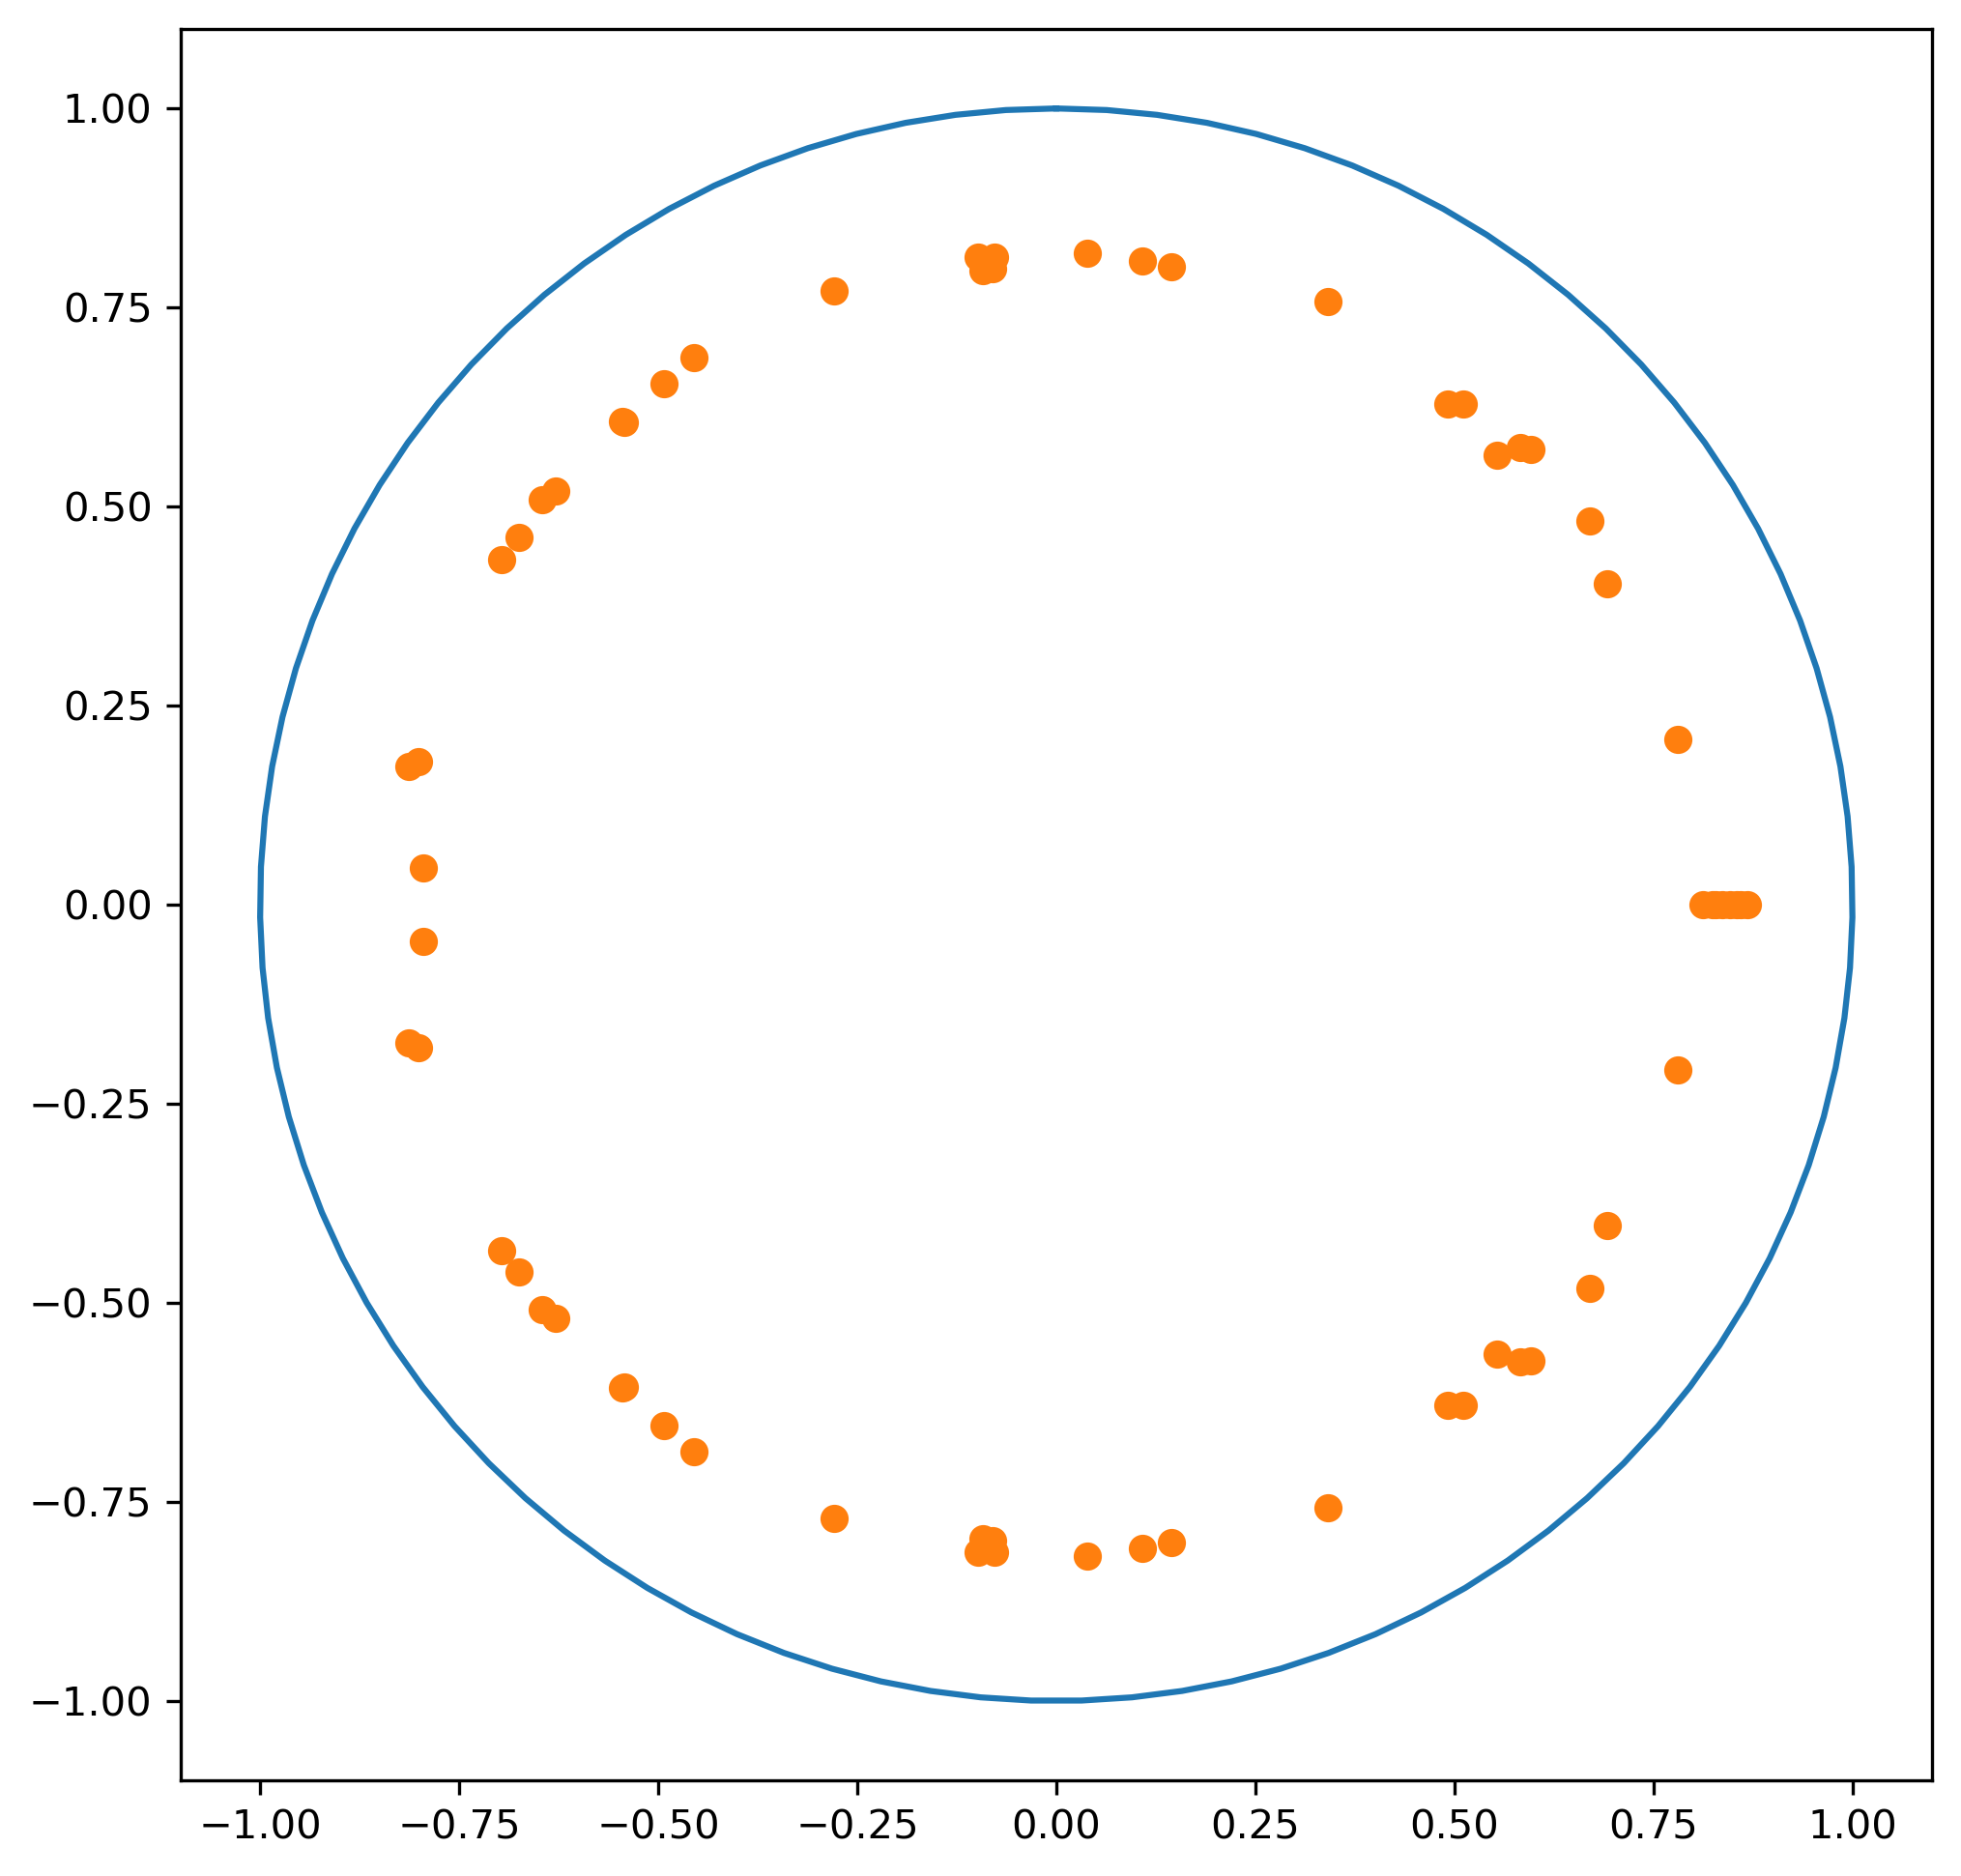

In [4]:
choi = kraus_to_choi(kraus_model)
spectrum = choi_spectrum(choi)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle)
plt.plot(*spectrum, "o")
plt.show()